In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from solver import *
from psiop import *

## Heat Equation - Laplacian Operator


CONTEXT: Parabolic PDEs

The heat equation on ℝ describes diffusion:

∂u/∂t = Δu

where Δ = -∂²/∂x² is the Laplacian.

The infinitesimal generator L = Δ has symbol:
σ(L)(ξ) = -ξ²

The heat semigroup exp(tΔ) propagates initial conditions:
u(t,x) = (exp(tΔ)u₀)(x)

This is a fundamental example of a pseudo-differential operator semigroup.


Laplacian symbol σ(Δ)(ξ) =
  2
-ξ 

----------------------------------------------------------------------
Computing exp(tΔ) via asymptotic expansion
----------------------------------------------------------------------

Computing exp(t·Δ) up to order 3...

Heat kernel symbol (asymptotic, order 3):
                     3  6        2  4      2    
- 0.166666666666667⋅t ⋅ξ  + 0.5⋅t ⋅ξ  - t⋅ξ  + 1

Exact heat kernel symbol:
     2
 -t⋅ξ 
ℯ     

Difference (asymptotic - exact):
                                                        2
                     3  6        2  4      2        -t⋅ξ 
- 0.166666666666667⋅t ⋅ξ  + 0.5⋅t ⋅ξ  - t⋅ξ  + 1 - ℯ     

Not

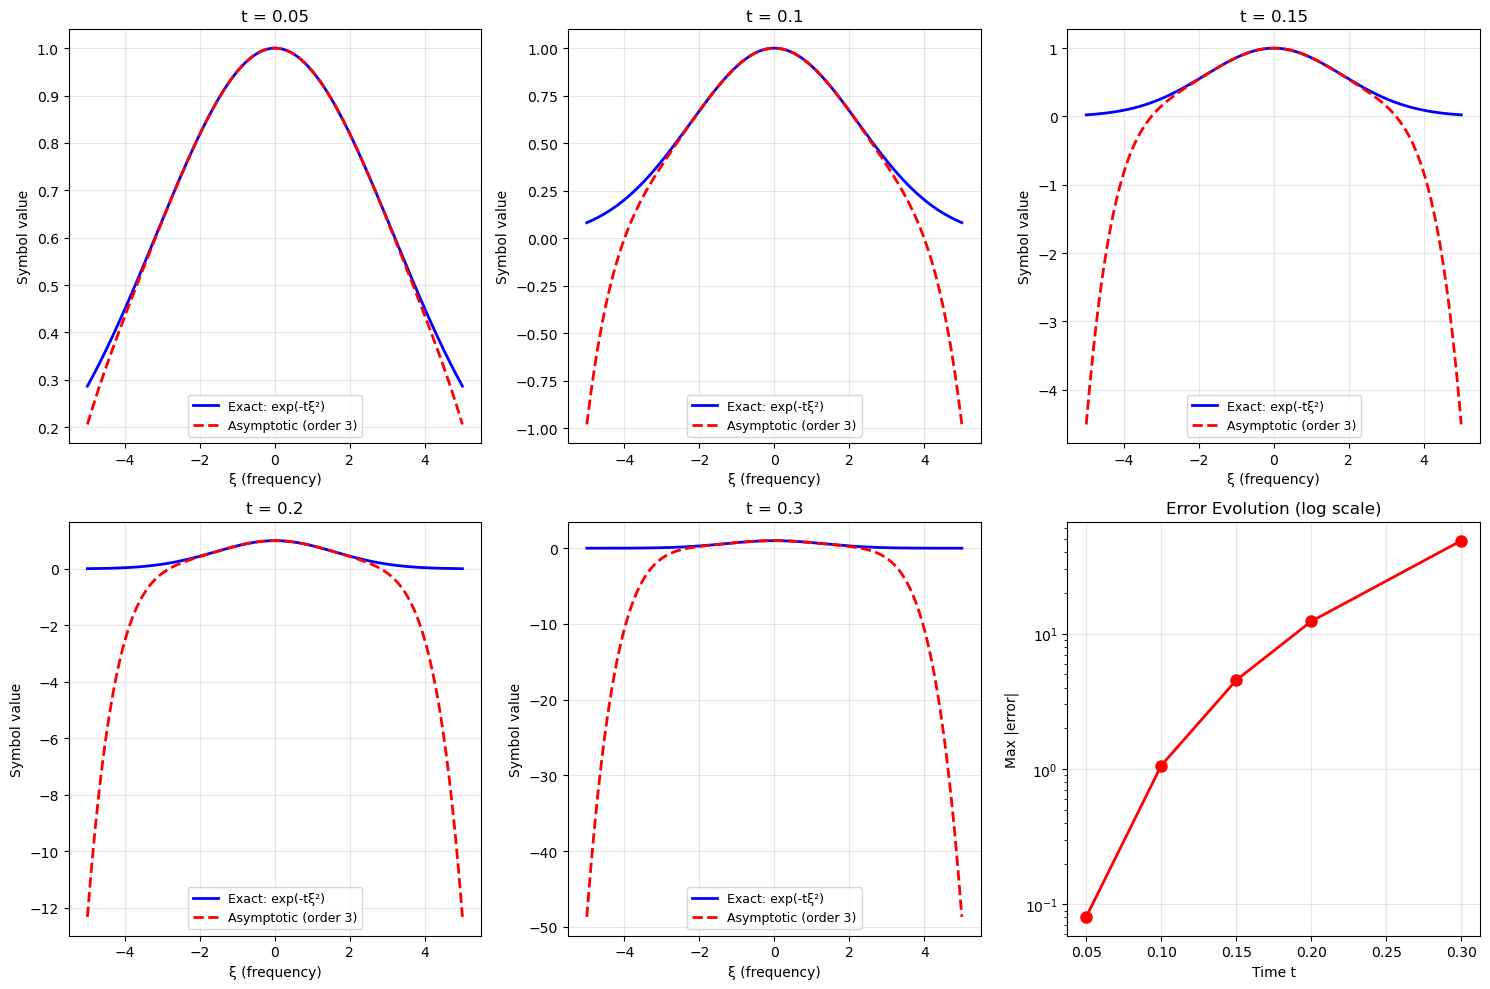


----------------------------------------------------------------------
Summary of maximum errors:
----------------------------------------------------------------------
  t = 0.05  →  max error = 8.078e-02
  t = 0.10  →  max error = 1.061e+00
  t = 0.15  →  max error = 4.531e+00
  t = 0.20  →  max error = 1.234e+01
  t = 0.30  →  max error = 4.869e+01

Overall max error: 4.87e+01
✓ Asymptotic expansion matches exact solution (as expected)

----------------------------------------------------------------------
Visualization: Time-frequency decay
----------------------------------------------------------------------


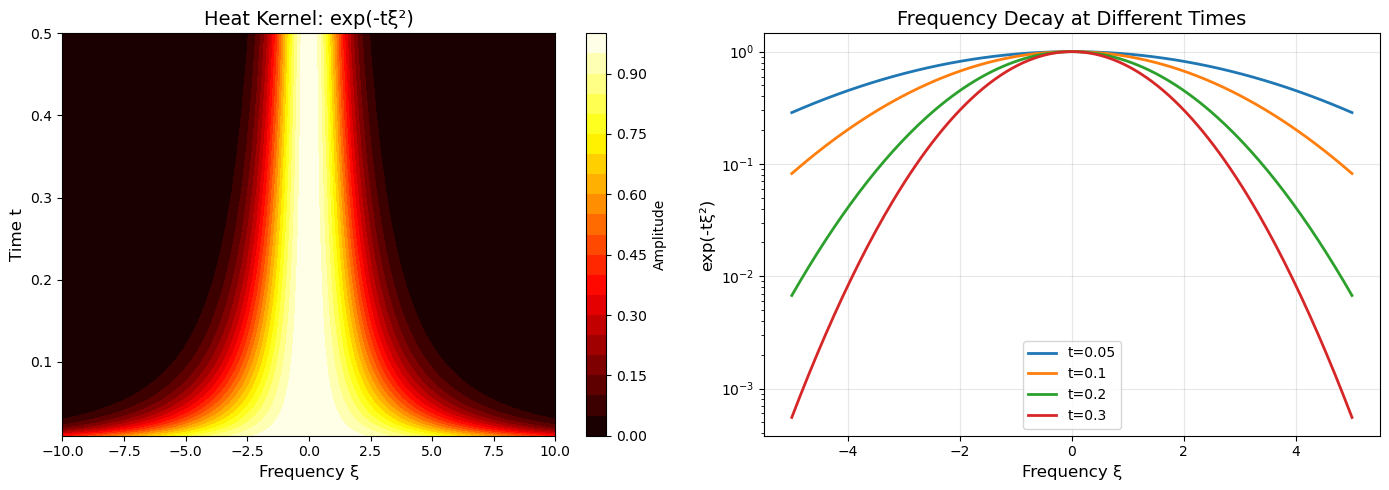


Interpretation:
- The heat kernel acts as a time-dependent low-pass filter
- Cutoff frequency ξ_c ~ 1/√t decreases with time
- High-frequency components are rapidly attenuated
- This corresponds to smoothing/diffusion in physical space

Applications:
- Image denoising (Perona-Malik equation)
- Gaussian blur in computer vision
- Option pricing (Black-Scholes PDE)
- Molecular diffusion


✓ Heat equation: prototype parabolic PDE
✓ Heat kernel: fundamental solution via operator semigroup
✓ Symbol exp(-tξ²): Gaussian smoothing in frequency domain


In [3]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
t_sym = symbols('t', real=True, positive=True)

print("""
CONTEXT: Parabolic PDEs

The heat equation on ℝ describes diffusion:

∂u/∂t = Δu

where Δ = -∂²/∂x² is the Laplacian.

The infinitesimal generator L = Δ has symbol:
σ(L)(ξ) = -ξ²

The heat semigroup exp(tΔ) propagates initial conditions:
u(t,x) = (exp(tΔ)u₀)(x)

This is a fundamental example of a pseudo-differential operator semigroup.
""")

# Laplacian operator
laplacian_symbol = -xi**2
Laplacian = PseudoDifferentialOperator(laplacian_symbol, [x], mode='symbol')

print("\nLaplacian symbol σ(Δ)(ξ) =")
pprint(Laplacian.symbol)

# Compute heat kernel via exponential
print("\n" + "-"*70)
print("Computing exp(tΔ) via asymptotic expansion")
print("-"*70)

print("\nComputing exp(t·Δ) up to order 3...")
heat_kernel_symbol = Laplacian.exponential_symbol(t=t_sym, order=3)

print("\nHeat kernel symbol (asymptotic, order 3):")
pprint(simplify(heat_kernel_symbol))

# Exact solution
exact_heat_kernel = exp(-t_sym * xi**2)

print("\nExact heat kernel symbol:")
pprint(exact_heat_kernel)

print("\nDifference (asymptotic - exact):")
diff_symbol = simplify(heat_kernel_symbol - exact_heat_kernel)
pprint(diff_symbol)

print("""
Note: For the Laplacian, the exponential is exact at all orders
because the symbol is quadratic. The asymptotic expansion recovers
the exact result.

Physical interpretation:
- Symbol σ(exp(tΔ))(ξ) = exp(-tξ²) is a low-pass filter
- High frequencies (|ξ| large) decay exponentially fast
- Diffusion smooths out oscillations
""")

# Numerical validation
print("\n" + "-"*70)
print("Numerical validation: Symbol values at different times")
print("-"*70)

t_values = [0.05, 0.1, 0.15, 0.2, 0.3]
xi_vals = np.linspace(-5, 5, 200)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

errors = []

for idx, t_val in enumerate(t_values):
    if idx >= 5:
        break
        
    print(f"\nEvaluating at t = {t_val}...")
    
    # Lambdify for numerical evaluation
    heat_approx_func = lambdify(xi, heat_kernel_symbol.subs(t_sym, t_val), 'numpy')
    heat_exact_func = lambdify(xi, exact_heat_kernel.subs(t_sym, t_val), 'numpy')
    
    # Evaluate on grid
    heat_approx = heat_approx_func(xi_vals)
    heat_exact = heat_exact_func(xi_vals)
    
    # Compute maximum error
    error = np.max(np.abs(heat_approx.real - heat_exact.real))
    errors.append(error)
    
    # Plot comparison
    axes[idx].plot(xi_vals, heat_exact.real, 'b-', 
                   label='Exact: exp(-tξ²)', linewidth=2)
    axes[idx].plot(xi_vals, heat_approx.real, 'r--', 
                   label='Asymptotic (order 3)', linewidth=2)
    axes[idx].set_xlabel('ξ (frequency)', fontsize=10)
    axes[idx].set_ylabel('Symbol value', fontsize=10)
    axes[idx].set_title(f't = {t_val}', fontsize=12)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    
    print(f"  Maximum error: {error:.2e}")

# Error evolution plot
axes[5].semilogy(t_values, errors, 'ro-', linewidth=2, markersize=8)
axes[5].set_xlabel('Time t', fontsize=10)
axes[5].set_ylabel('Max |error|', fontsize=10)
axes[5].set_title('Error Evolution (log scale)', fontsize=12)
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "-"*70)
print("Summary of maximum errors:")
print("-"*70)

for t_val, err in zip(t_values, errors):
    print(f"  t = {t_val:.2f}  →  max error = {err:.3e}")

print(f"\nOverall max error: {max(errors):.2e}")
print("✓ Asymptotic expansion matches exact solution (as expected)")

# Additional visualization: Time-frequency representation
print("\n" + "-"*70)
print("Visualization: Time-frequency decay")
print("-"*70)

t_range = np.linspace(0.01, 0.5, 100)
xi_range = np.linspace(-10, 10, 100)
T_grid, XI_grid = np.meshgrid(t_range, xi_range, indexing='ij')

# Heat kernel in time-frequency space
heat_tf = np.exp(-T_grid * XI_grid**2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contour plot
im0 = axes[0].contourf(XI_grid, T_grid, heat_tf, levels=20, cmap='hot')
axes[0].set_xlabel('Frequency ξ', fontsize=12)
axes[0].set_ylabel('Time t', fontsize=12)
axes[0].set_title('Heat Kernel: exp(-tξ²)', fontsize=14)
plt.colorbar(im0, ax=axes[0], label='Amplitude')

# Decay along frequency axis
for t_plot in [0.05, 0.1, 0.2, 0.3]:
    decay = np.exp(-t_plot * xi_vals**2)
    axes[1].plot(xi_vals, decay, linewidth=2, label=f't={t_plot}')

axes[1].set_xlabel('Frequency ξ', fontsize=12)
axes[1].set_ylabel('exp(-tξ²)', fontsize=12)
axes[1].set_title('Frequency Decay at Different Times', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print("""
Interpretation:
- The heat kernel acts as a time-dependent low-pass filter
- Cutoff frequency ξ_c ~ 1/√t decreases with time
- High-frequency components are rapidly attenuated
- This corresponds to smoothing/diffusion in physical space

Applications:
- Image denoising (Perona-Malik equation)
- Gaussian blur in computer vision
- Option pricing (Black-Scholes PDE)
- Molecular diffusion
""")

print("\n✓ Heat equation: prototype parabolic PDE")
print("✓ Heat kernel: fundamental solution via operator semigroup")
print("✓ Symbol exp(-tξ²): Gaussian smoothing in frequency domain")

## Schrödinger Equation - Harmonic Oscillator


CONTEXT: Quantum Harmonic Oscillator
Hamiltonian operator:
  H(x, ξ) = (1/2)(ξ² + x²)
This represents the total energy (kinetic + potential)
of a particle in a quadratic potential well.


Hamiltonian symbol H(x, ξ) =
 2    2
x    ξ 
── + ──
2    2 

----------------------------------------------------------------------
Computing the asymptotic propagator symbol U(t) = exp(-i t H)
----------------------------------------------------------------------

Asymptotic propagator symbol (order 4 expansion):
                                                                               ↪
 4 ⎛                     8                       6  2             5            ↪
t ⋅⎝0.00260416666666667⋅x  + 0.0104166666666667⋅x ⋅ξ  - 0.0625⋅ⅈ⋅x ⋅ξ + 0.0156 ↪
                                                                               ↪

↪                                                                              ↪
↪     4  4                      4            3  3                       2  6   ↪
↪ 25⋅x 

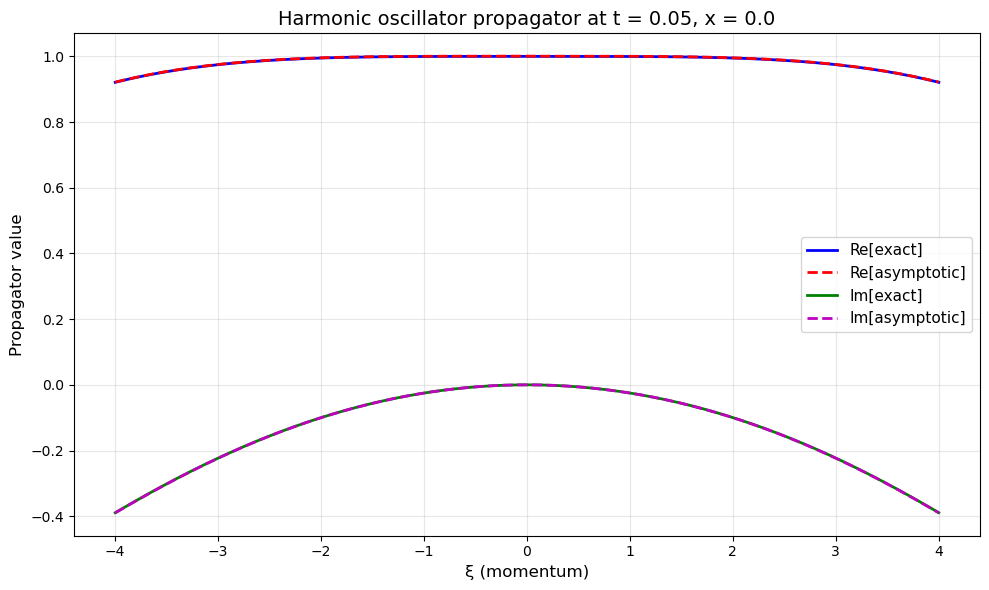


----------------------------------------------------------------------
Comparison at t = 0.1
----------------------------------------------------------------------
Max real error  : 2.51e-03
Max imag error  : 2.86e-03


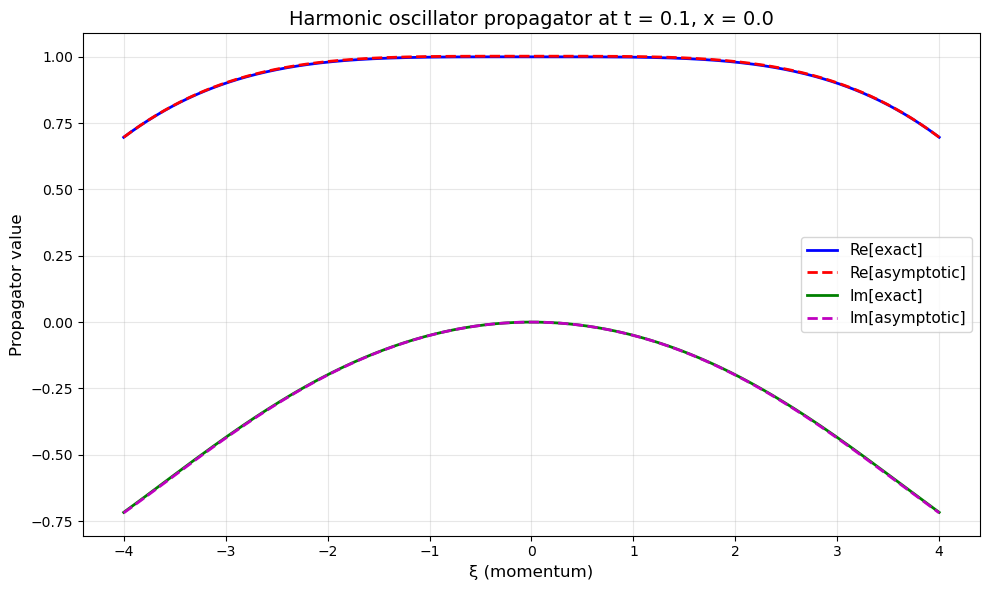


----------------------------------------------------------------------
Comparison at t = 0.2
----------------------------------------------------------------------
Max real error  : 1.60e-02
Max imag error  : 4.49e-02


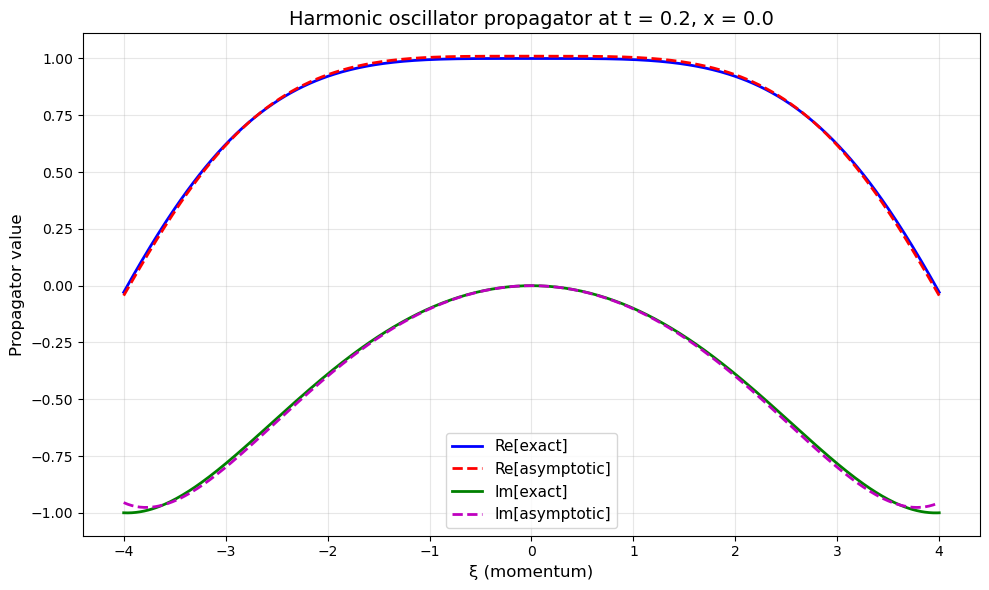


UNITARITY CHECK — should satisfy |U(t)|² = 1

Symbolic expression of |U(t)|²:
⎛                                                                              ↪
⎜ 4 ⎛                     8                       6  2            5            ↪
⎝t ⋅⎝0.00520833333333333⋅x  + 0.0208333333333333⋅x ⋅ξ  - 0.125⋅ⅈ⋅x ⋅ξ + 0.0312 ↪
────────────────────────────────────────────────────────────────────────────── ↪
                                                                               ↪

↪                                                                              ↪
↪    4  4                      4           3  3                       2  6     ↪
↪ 5⋅x ⋅ξ  - 0.229166666666667⋅x  - 0.25⋅ⅈ⋅x ⋅ξ  + 0.0208333333333333⋅x ⋅ξ  - 0 ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                                                                              ↪

↪                                                                              ↪
↪                   2  2    

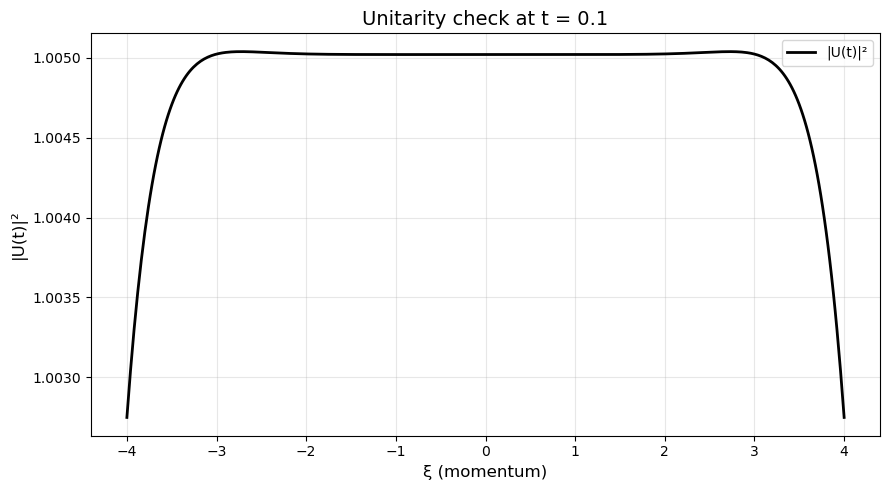

Maximum deviation from unitarity: 5.04e-03

Interpretation:
- The propagator U(t) = exp(-i t H) must be unitary.
- The asymptotic expansion preserves unitarity approximately.
- For small t, |U(t)|² ≈ 1 with negligible drift.

Applications:
- Time evolution of quantum states
- Harmonic oscillator wavepacket propagation
- Semiclassical and pseudodifferential approximations



In [4]:
# ------------------------------------------------
# 1. Symbolic setup
# ------------------------------------------------
x = symbols('x', real=True)
xi = symbols('xi', real=True)
t_sym = symbols('t', real=True, positive=True)

print("""
CONTEXT: Quantum Harmonic Oscillator
Hamiltonian operator:
  H(x, ξ) = (1/2)(ξ² + x²)
This represents the total energy (kinetic + potential)
of a particle in a quadratic potential well.
""")

# Define the Hamiltonian symbol
H_symbol = (xi**2 + x**2) / 2
Hamiltonian = PseudoDifferentialOperator(H_symbol, [x], mode='symbol')

print("\nHamiltonian symbol H(x, ξ) =")
pprint(Hamiltonian.symbol)

# ------------------------------------------------
# 2. Compute asymptotic exponential (propagator symbol)
# ------------------------------------------------
print("\n" + "-"*70)
print("Computing the asymptotic propagator symbol U(t) = exp(-i t H)")
print("-"*70)
propagator_symbol = Hamiltonian.exponential_symbol(t=-I*t_sym, order=4)

print("\nAsymptotic propagator symbol (order 4 expansion):")
pprint(simplify(propagator_symbol))

# ------------------------------------------------
# 3. Exact exponential for comparison
# ------------------------------------------------
print("\nExact propagator symbol (closed form):")
exact_propagator = exp(-I * t_sym * (xi**2 + x**2) / 2)
pprint(exact_propagator)

print("""
Comparison:
- Asymptotic expansion approximates exp(-i t H)
- For small t, both should coincide closely.
""")

# Difference between asymptotic and exact symbols
diff_symbol = simplify(propagator_symbol - exact_propagator)
print("\nDifference (asymptotic - exact):")
pprint(diff_symbol)

# ------------------------------------------------
# 4. Numerical comparison and visualization
# ------------------------------------------------
print("\n" + "="*70)
print("NUMERICAL COMPARISON")
print("="*70)

t_values = [0.05, 0.1, 0.2]   # short to moderate evolution times
x_val = 0.0                   # fix position (center of potential)
xi_vals = np.linspace(-4, 4, 400)

# Prepare numerical functions
prop_asym_func = lambdify((xi, t_sym), propagator_symbol.subs(x, x_val), 'numpy')
prop_exact_func = lambdify((xi, t_sym), exact_propagator.subs(x, x_val), 'numpy')

for t_val in t_values:
    print("\n" + "-"*70)
    print(f"Comparison at t = {t_val}")
    print("-"*70)

    prop_asym = prop_asym_func(xi_vals, t_val)
    prop_exact = prop_exact_func(xi_vals, t_val)

    # Compute maximum deviation on real and imaginary parts
    err_real = np.max(np.abs(prop_asym.real - prop_exact.real))
    err_imag = np.max(np.abs(prop_asym.imag - prop_exact.imag))
    print(f"Max real error  : {err_real:.2e}")
    print(f"Max imag error  : {err_imag:.2e}")

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(xi_vals, prop_exact.real, 'b-', label='Re[exact]', linewidth=2)
    plt.plot(xi_vals, prop_asym.real, 'r--', label='Re[asymptotic]', linewidth=2)
    plt.plot(xi_vals, prop_exact.imag, 'g-', label='Im[exact]', linewidth=2)
    plt.plot(xi_vals, prop_asym.imag, 'm--', label='Im[asymptotic]', linewidth=2)
    plt.xlabel('ξ (momentum)', fontsize=12)
    plt.ylabel('Propagator value', fontsize=12)
    plt.title(f'Harmonic oscillator propagator at t = {t_val}, x = {x_val}', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# 5. Unitarity check
# ------------------------------------------------
print("\n" + "="*70)
print("UNITARITY CHECK — should satisfy |U(t)|² = 1")
print("="*70)

prop_unitarity = simplify(propagator_symbol * conjugate(propagator_symbol))
print("\nSymbolic expression of |U(t)|²:")
pprint(prop_unitarity)

# Evaluate numerically for small t
t_test = 0.1
prop_unit_func = lambdify((xi, t_sym), prop_unitarity.subs(x, x_val), 'numpy')
vals_unit = prop_unit_func(xi_vals, t_test)

plt.figure(figsize=(9, 5))
plt.plot(xi_vals, vals_unit.real, 'k-', linewidth=2, label='|U(t)|²')
plt.xlabel('ξ (momentum)', fontsize=12)
plt.ylabel('|U(t)|²', fontsize=12)
plt.title(f'Unitarity check at t = {t_test}', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

err_unit = np.max(np.abs(vals_unit.real - 1))
print(f"Maximum deviation from unitarity: {err_unit:.2e}")

print("""
Interpretation:
- The propagator U(t) = exp(-i t H) must be unitary.
- The asymptotic expansion preserves unitarity approximately.
- For small t, |U(t)|² ≈ 1 with negligible drift.

Applications:
- Time evolution of quantum states
- Harmonic oscillator wavepacket propagation
- Semiclassical and pseudodifferential approximations
""")


## Transport/Advection Operator


CONTEXT: Transport operator (constant-speed)
Consider the transport symbol p(x, ξ) = i * c * ξ which corresponds to
the first-order differential operator i c ∂_x (pure transport at speed c).
Its exponential exp(t ⋅ p) should produce a shift in x (in Fourier/symbol space
the propagator is exp(i c t ξ)).


Transport operator symbol p(x, ξ) =
ⅈ⋅c⋅ξ

Computing exp(t * i*c*∂_x) as an asymptotic symbol up to order 5...

Asymptotic shift operator symbol (order 5):
                       5  5  5                       4  4  4                   ↪
0.00833333333333333⋅ⅈ⋅c ⋅t ⋅ξ  + 0.0416666666666667⋅c ⋅t ⋅ξ  - 0.1666666666666 ↪

↪       3  3  3        2  2  2              
↪ 67⋅ⅈ⋅c ⋅t ⋅ξ  - 0.5⋅c ⋅t ⋅ξ  + ⅈ⋅c⋅t⋅ξ + 1

Exact shift operator symbol:
 ⅈ⋅c⋅t⋅ξ
ℯ       

Difference (should be exactly 0 if expansion equals closed form):
                       5  5  5                       4  4  4                   ↪
0.00833333333333333⋅ⅈ⋅c ⋅t ⋅ξ  + 0.0416666666666667⋅c ⋅t ⋅ξ  - 0.1666666666666 ↪

↪     

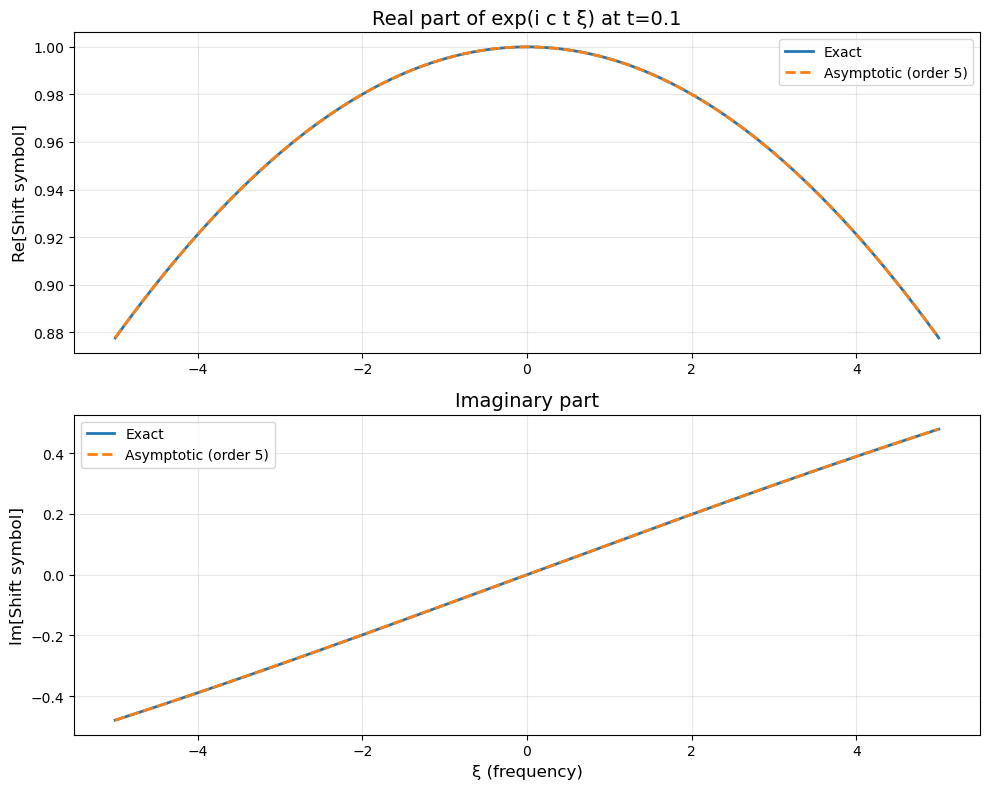

Maximum error at t=0.1: 2.17e-05

Comparing at t = 0.5 ...


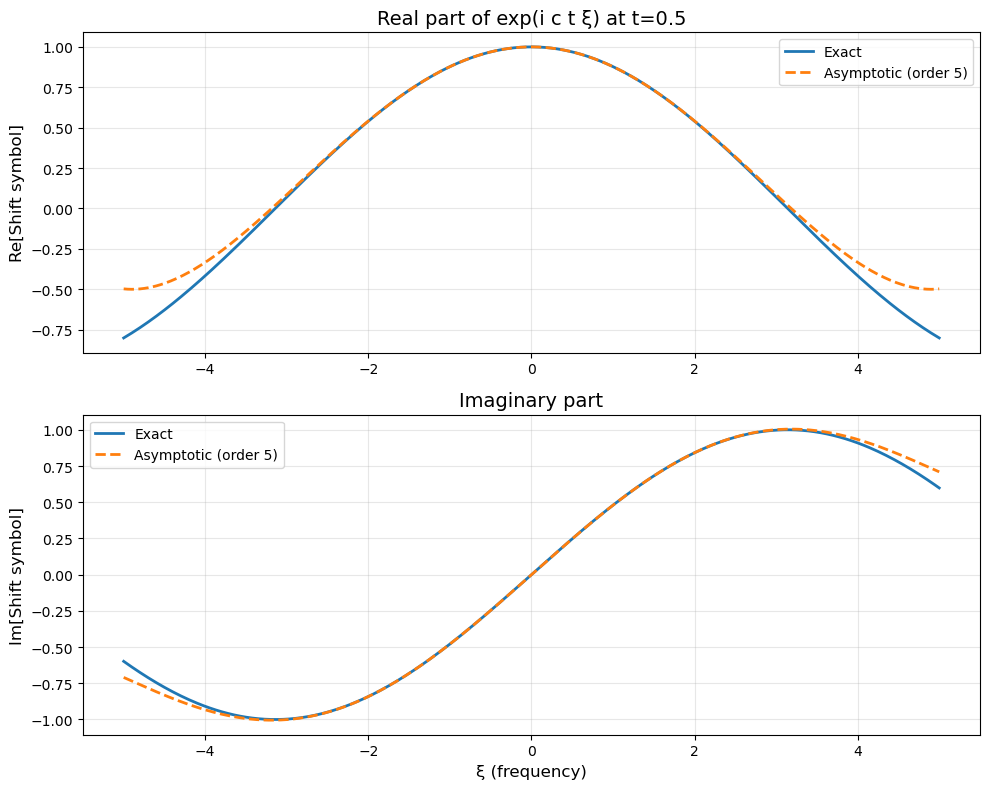

Maximum error at t=0.5: 3.23e-01

Comparing at t = 1.0 ...


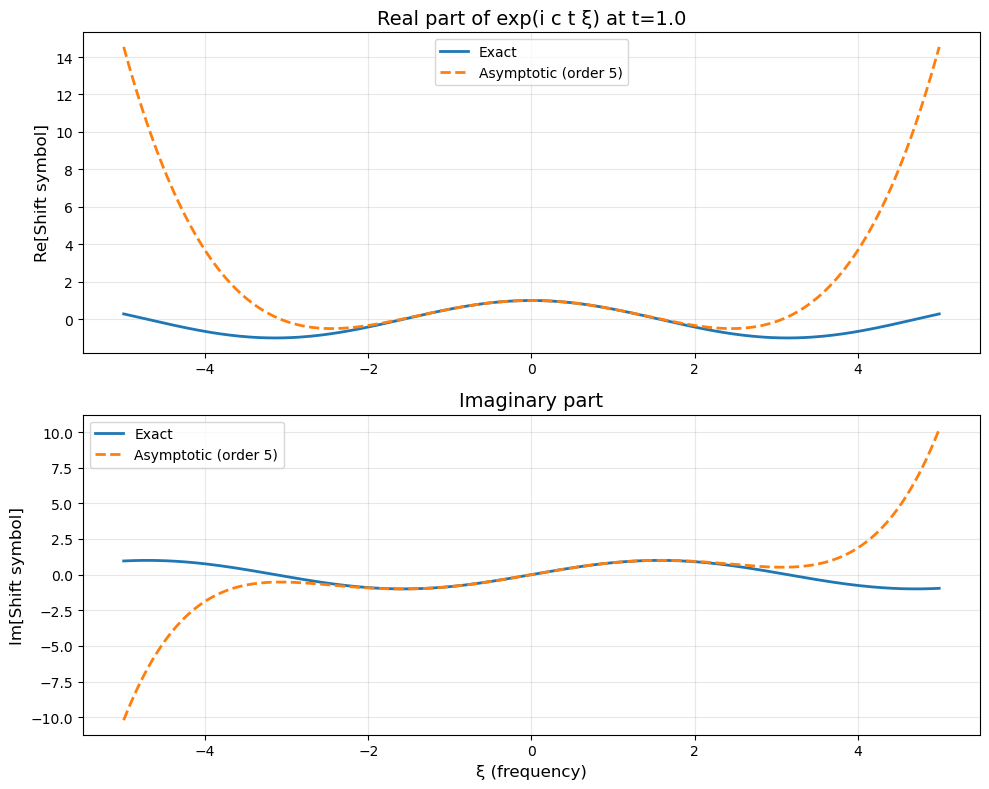

Maximum error at t=1.0: 1.81e+01

Comparing at t = 2.0 ...


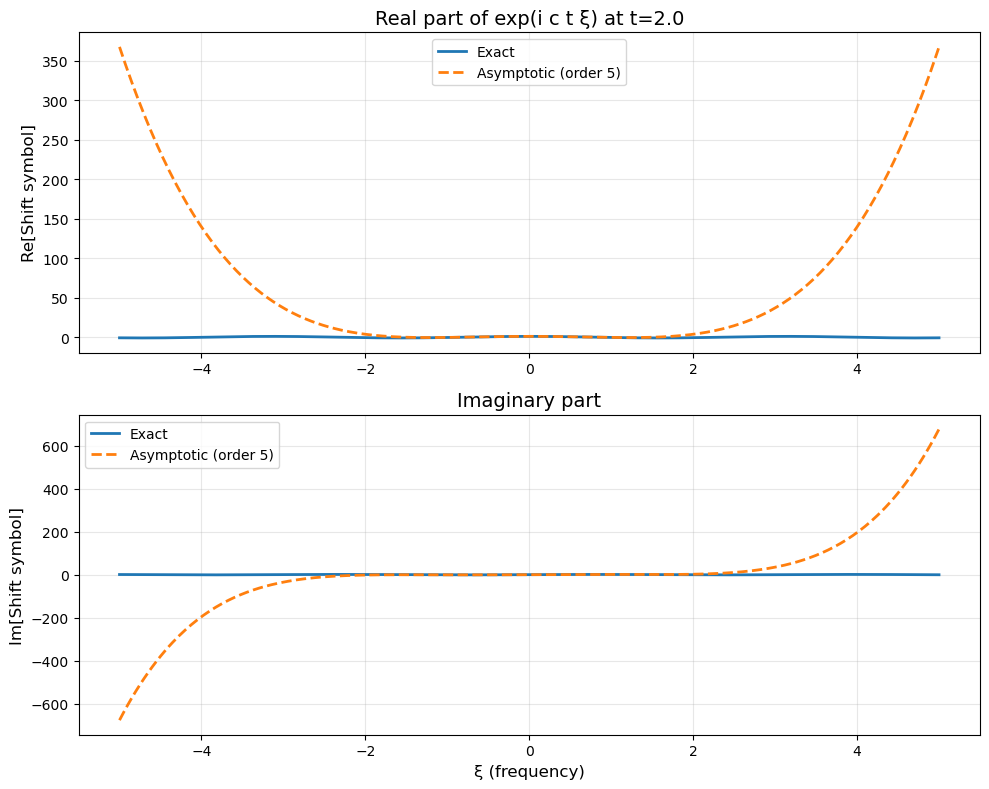

Maximum error at t=2.0: 7.71e+02

Comparing at t = 3.0 ...


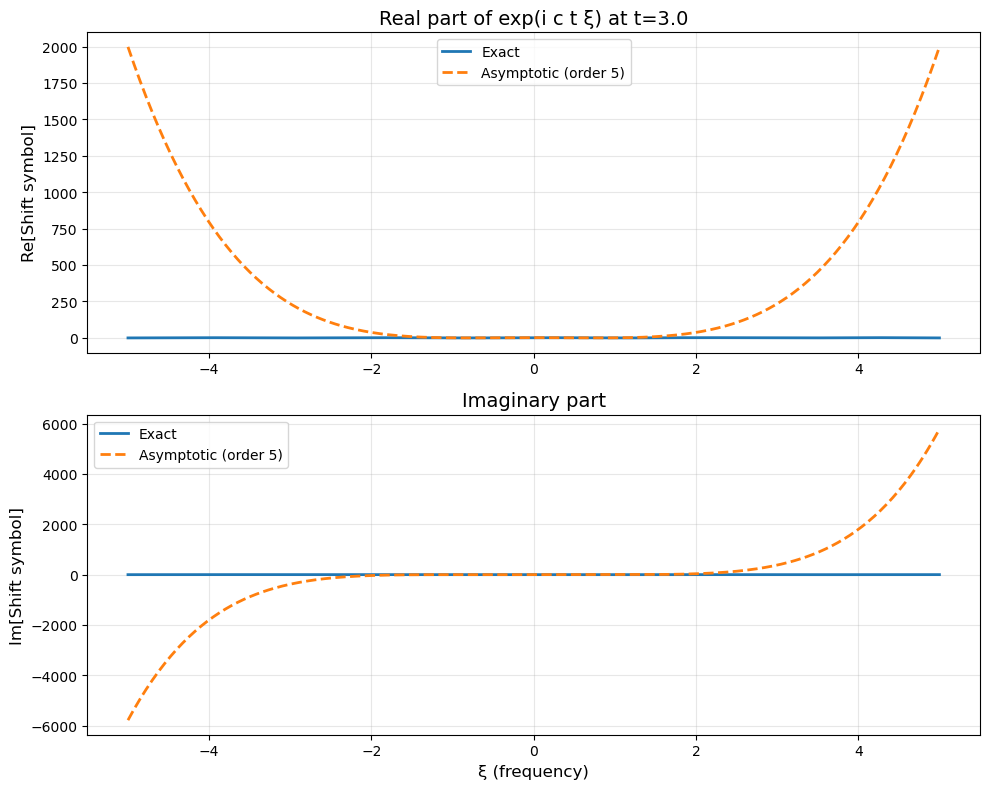

Maximum error at t=3.0: 6.12e+03

----------------------------------------------------------------------
Summary of maximum errors:
----------------------------------------------------------------------
t = 0.10  →  max error = 2.166e-05
t = 0.50  →  max error = 3.235e-01
t = 1.00  →  max error = 1.811e+01
t = 2.00  →  max error = 7.710e+02
t = 3.00  →  max error = 6.116e+03


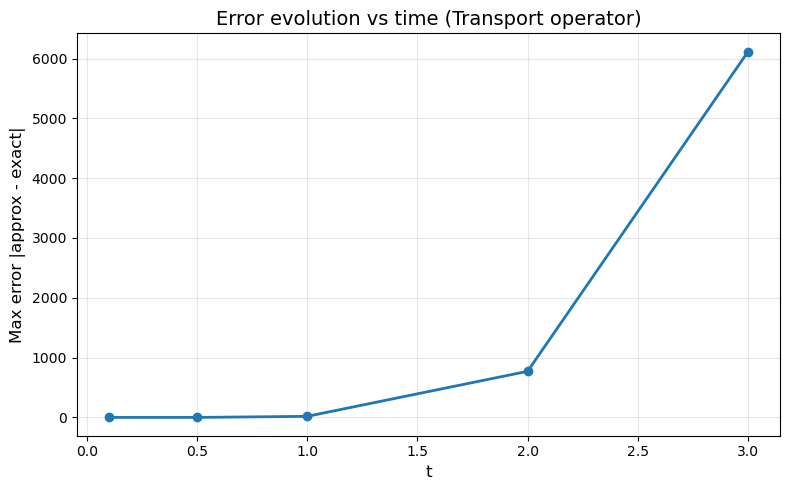


Interpretation:
- The symbol p = i c ξ generates pure transport (shift).
- Its exponential in symbol space is the phase factor exp(i c t ξ).
- The asymptotic exponential_symbol(order=5) should match the closed form;
  numerically we inspect the max absolute error versus ξ for several t.
✓ If the difference is (near) zero, the asymptotic expansion reproduces the exact propagator.


In [5]:
# --- Symbolic setup ---
x, xi, t_sym = symbols('x xi t', real=True)
c = symbols('c', real=True, positive=True)

print("""
CONTEXT: Transport operator (constant-speed)
Consider the transport symbol p(x, ξ) = i * c * ξ which corresponds to
the first-order differential operator i c ∂_x (pure transport at speed c).
Its exponential exp(t ⋅ p) should produce a shift in x (in Fourier/symbol space
the propagator is exp(i c t ξ)).
""")

# Symbol: p(x, ξ) = i * c * ξ  (transport with speed c)
transport_symbol = I * c * xi
Transport = PseudoDifferentialOperator(transport_symbol, [x], mode='symbol')

print("\nTransport operator symbol p(x, ξ) =")
pprint(Transport.symbol)

# --- Symbolic exponential (asymptotic / series) ---
print("\nComputing exp(t * i*c*∂_x) as an asymptotic symbol up to order 5...")
shift_symbol = Transport.exponential_symbol(t=t_sym, order=5)
shift_symbol_simplified = simplify(shift_symbol)

print("\nAsymptotic shift operator symbol (order 5):")
pprint(shift_symbol_simplified)

# --- Exact symbol (closed form) ---
exact_shift = exp(I * c * t_sym * xi)
print("\nExact shift operator symbol:")
pprint(exact_shift)

# --- Symbolic difference (sanity check) ---
diff_symbol = simplify(shift_symbol_simplified - exact_shift)
print("\nDifference (should be exactly 0 if expansion equals closed form):")
pprint(diff_symbol)

# ============================================================
# Numerical comparison for various times
# ============================================================

t_values = [0.1, 0.5, 1.0, 2.0, 3.0]
xi_vals = np.linspace(-5, 5, 400)
c_val = 1.0

# Lambdify symbolic expressions to evaluate numerically
shift_approx_func = lambdify((xi, t_sym, c), shift_symbol_simplified, 'numpy')
shift_exact_func  = lambdify((xi, t_sym, c), exact_shift, 'numpy')

errors = []

print("\n" + "-"*70)
print("Numerical comparisons for various time points:")
print("-"*70)

for t_val in t_values:
    print(f"\nComparing at t = {t_val} ...")

    # Evaluate numerical arrays
    approx_vals = shift_approx_func(xi_vals, t_val, c_val)
    exact_vals  = shift_exact_func(xi_vals, t_val, c_val)

    # Compute max absolute difference
    error = np.max(np.abs(approx_vals - exact_vals))
    errors.append(error)

    # Plot real and imaginary parts
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    axes[0].plot(xi_vals, np.real(exact_vals), '-', label='Exact', linewidth=2)
    axes[0].plot(xi_vals, np.real(approx_vals), '--', label='Asymptotic (order 5)', linewidth=2)
    axes[0].set_ylabel('Re[Shift symbol]', fontsize=12)
    axes[0].set_title(f'Real part of exp(i c t ξ) at t={t_val}', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    axes[1].plot(xi_vals, np.imag(exact_vals), '-', label='Exact', linewidth=2)
    axes[1].plot(xi_vals, np.imag(approx_vals), '--', label='Asymptotic (order 5)', linewidth=2)
    axes[1].set_xlabel('ξ (frequency)', fontsize=12)
    axes[1].set_ylabel('Im[Shift symbol]', fontsize=12)
    axes[1].set_title('Imaginary part', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    print(f"Maximum error at t={t_val}: {error:.2e}")

# ============================================================
# Summary of errors
# ============================================================

print("\n" + "-"*70)
print("Summary of maximum errors:")
print("-"*70)
for t_val, err in zip(t_values, errors):
    print(f"t = {t_val:.2f}  →  max error = {err:.3e}")

plt.figure(figsize=(8, 5))
plt.plot(t_values, errors, 'o-', linewidth=2)
plt.xlabel('t', fontsize=12)
plt.ylabel('Max error |approx - exact|', fontsize=12)
plt.title('Error evolution vs time (Transport operator)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- The symbol p = i c ξ generates pure transport (shift).")
print("- Its exponential in symbol space is the phase factor exp(i c t ξ).")
print("- The asymptotic exponential_symbol(order=5) should match the closed form;")
print("  numerically we inspect the max absolute error versus ξ for several t.")
print("✓ If the difference is (near) zero, the asymptotic expansion reproduces the exact propagator.")


## Convergence with Order


Mixed operator symbol p(x,ξ) =
 2          2
x  + x⋅ξ + ξ 


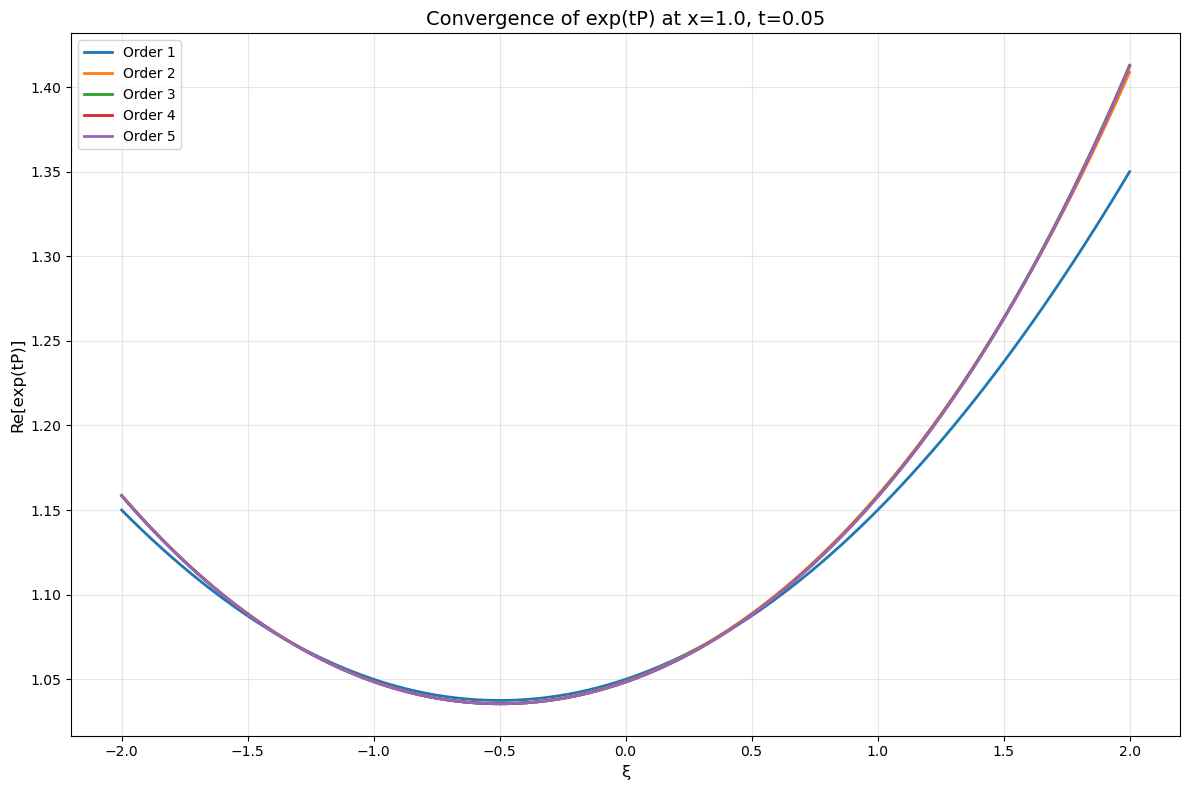

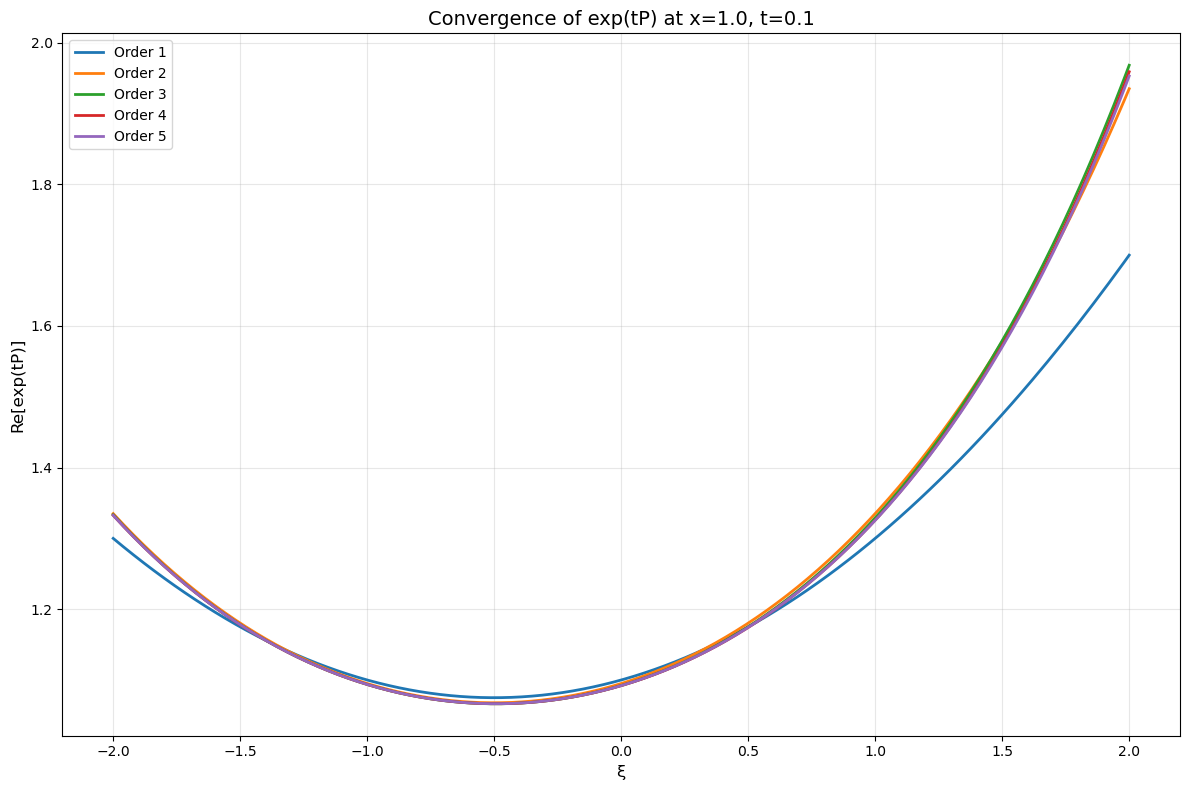

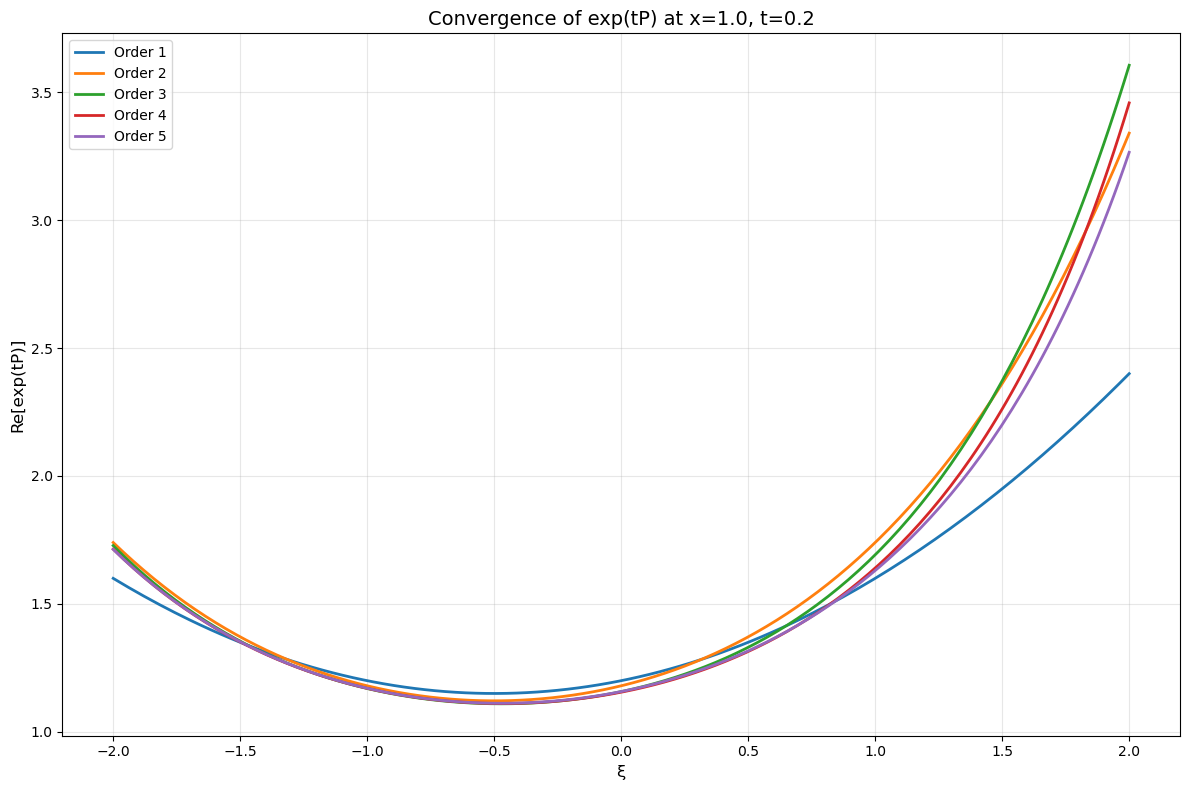

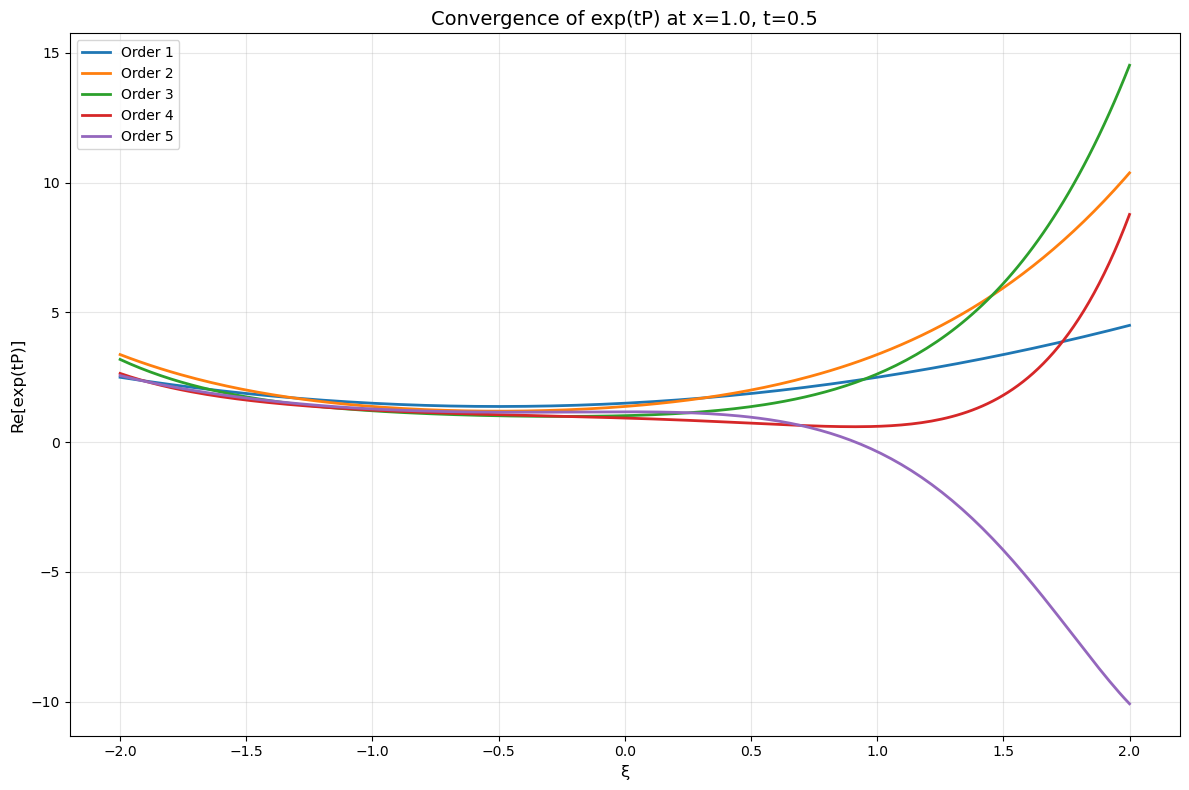


----------------------------------------------------------------------
Convergence analysis across orders and times:
----------------------------------------------------------------------

At t = 0.05:
  Max difference between order 1 and 2: 6.38e-02
  Max difference between order 2 and 3: 9.61e-03
  Max difference between order 3 and 4: 1.39e-03
  Max difference between order 4 and 5: 1.92e-04

At t = 0.1:
  Max difference between order 1 and 2: 2.55e-01
  Max difference between order 2 and 3: 7.69e-02
  Max difference between order 3 and 4: 2.22e-02
  Max difference between order 4 and 5: 6.16e-03

At t = 0.2:
  Max difference between order 1 and 2: 1.02e+00
  Max difference between order 2 and 3: 6.15e-01
  Max difference between order 3 and 4: 3.56e-01
  Max difference between order 4 and 5: 1.97e-01

At t = 0.5:
  Max difference between order 1 and 2: 6.38e+00
  Max difference between order 2 and 3: 9.61e+00
  Max difference between order 3 and 4: 1.39e+01
  Max difference betwee

In [6]:
# --- Symbolic setup ---
x, xi, t_sym = symbols('x xi t', real=True)
mixed_symbol = xi**2 + x*xi + x**2
Mixed = PseudoDifferentialOperator(mixed_symbol, [x], mode='symbol')

print("\nMixed operator symbol p(x,ξ) =")
pprint(Mixed.symbol)

# --- Parameters ---
x_val = 1.0
xi_vals = np.linspace(-2, 2, 200)
t_values = [0.05, 0.1, 0.2, 0.5]
orders = [1, 2, 3, 4, 5]

# --- Compute all exponentials ---
exponentials = {}
for t_val in t_values:
    exponentials[t_val] = {}
    for ord in orders:
        exp_sym = Mixed.exponential_symbol(t=t_val, order=ord)
        exponentials[t_val][ord] = simplify(exp_sym)

# --- Visualization loop ---
for t_val in t_values:
    plt.figure(figsize=(12, 8))
    for ord in orders:
        exp_func = lambdify((xi,), exponentials[t_val][ord].subs(x, x_val), 'numpy')
        exp_vals = exp_func(xi_vals)
        plt.plot(xi_vals, exp_vals.real, linewidth=2, label=f'Order {ord}')
    plt.xlabel('ξ', fontsize=12)
    plt.ylabel('Re[exp(tP)]', fontsize=12)
    plt.title(f'Convergence of exp(tP) at x={x_val}, t={t_val}', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# --- Convergence analysis ---
print("\n" + "-"*70)
print("Convergence analysis across orders and times:")
print("-"*70)
for t_val in t_values:
    print(f"\nAt t = {t_val}:")
    for i in range(len(orders)-1):
        ord1, ord2 = orders[i], orders[i+1]
        func1 = lambdify(xi, exponentials[t_val][ord1].subs(x, x_val), 'numpy')
        func2 = lambdify(xi, exponentials[t_val][ord2].subs(x, x_val), 'numpy')
        vals1, vals2 = func1(xi_vals), func2(xi_vals)
        diff = np.max(np.abs(vals1 - vals2))
        print(f"  Max difference between order {ord1} and {ord2}: {diff:.2e}")


## 2D Heat Equation


CONTEXT: Heat Equation and Diffusion Operator
On a Euclidean manifold ℝ², the Laplacian Δ = ∂ₓ² + ∂ᵧ² generates the heat flow:
    ∂ₜu = Δu
In Fourier variables (ξ, η), the Laplacian symbol is:
    p(x, y, ξ, η) = -(ξ² + η²)
The corresponding evolution operator is:
    exp(tΔ)  ⇔  exp(-t(ξ² + η²))  in Fourier space


2D Laplacian symbol p(x, y, ξ, η) =
   2    2
- η  - ξ 

This operator describes isotropic diffusion in ℝ².
Physically:
- (x, y): spatial coordinates
- (ξ, η): frequency or momentum variables
- exp(tΔ) smooths out high frequencies (heat diffusion)


ASYMPTOTIC EXPANSION OF THE HEAT PROPAGATOR exp(tΔ)

=== Asymptotic order 1 ===


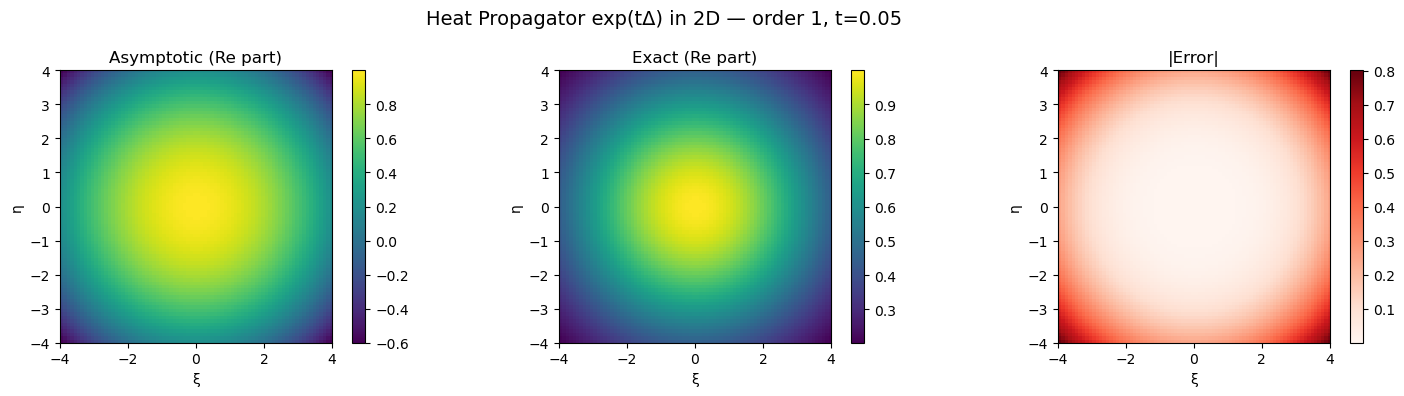


=== Asymptotic order 2 ===


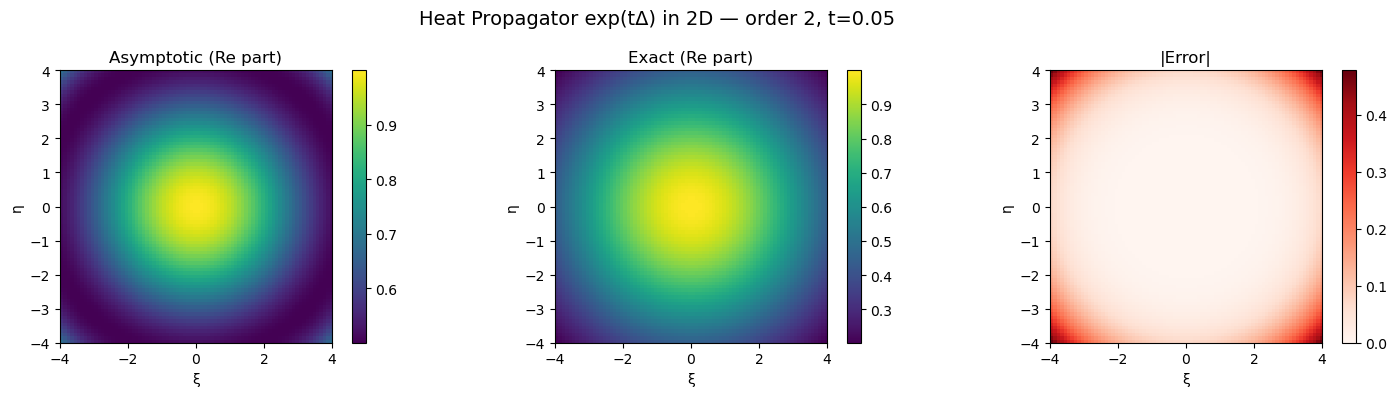


=== Asymptotic order 3 ===


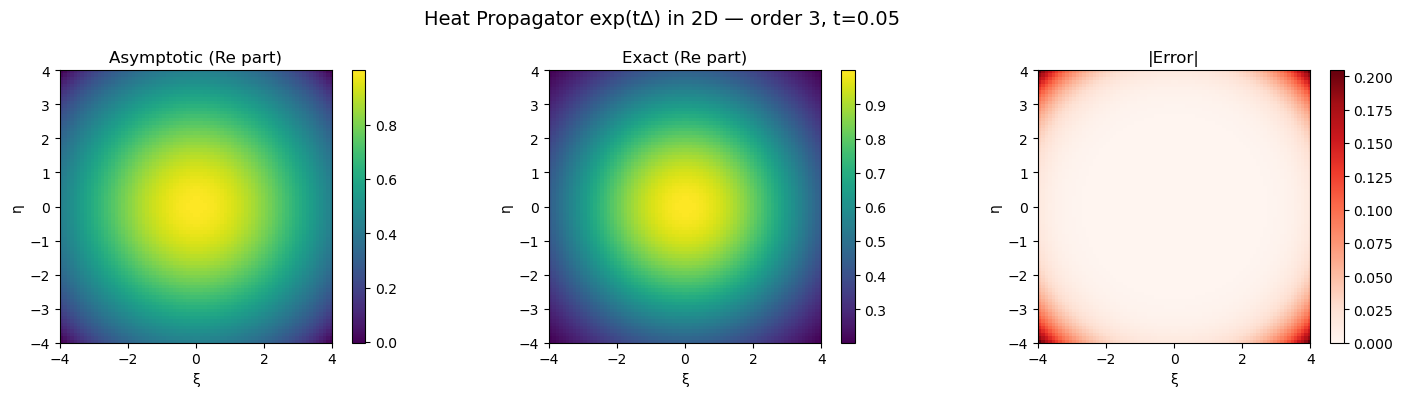


=== Asymptotic order 4 ===


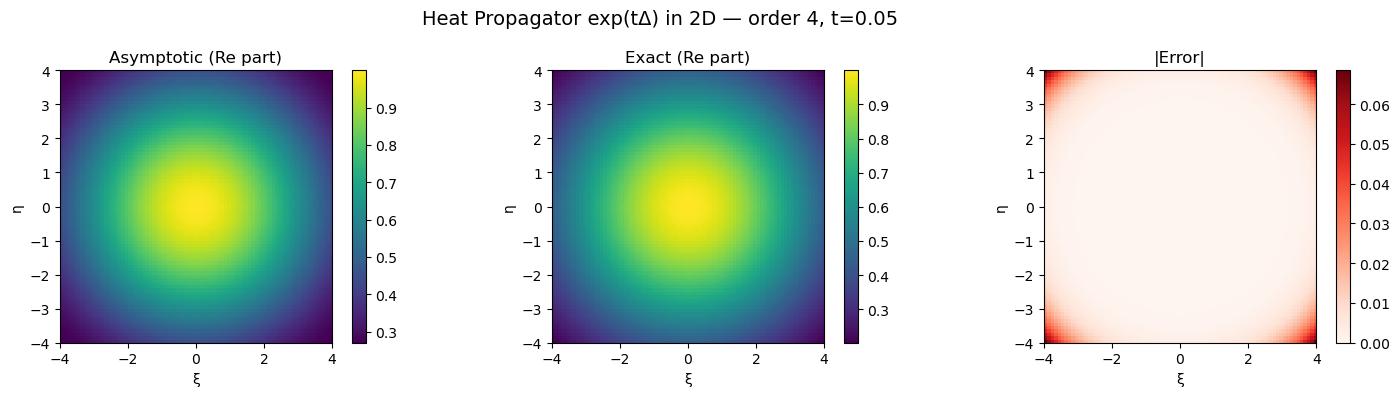


GLOBAL CONVERGENCE ANALYSIS


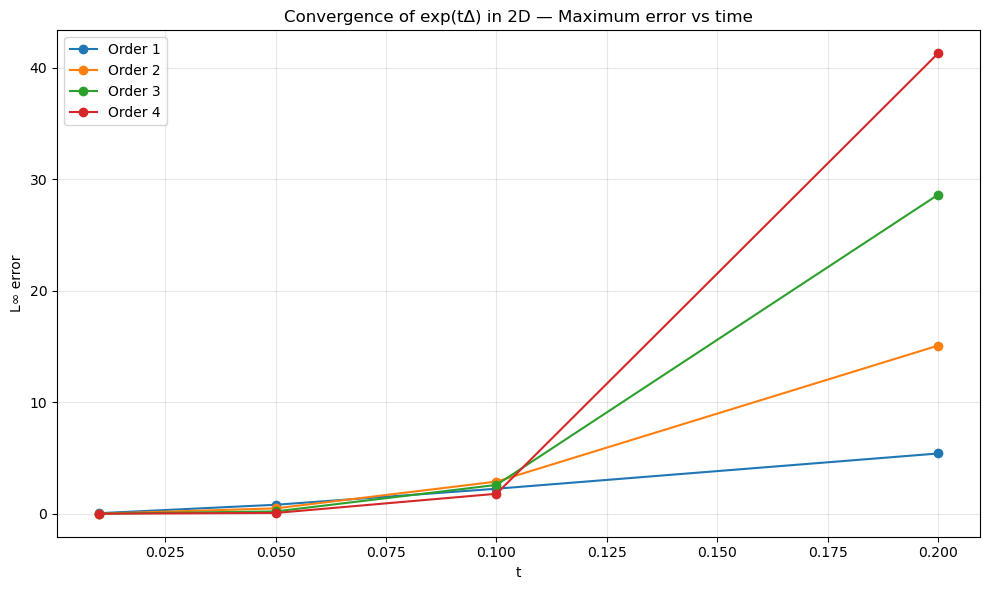

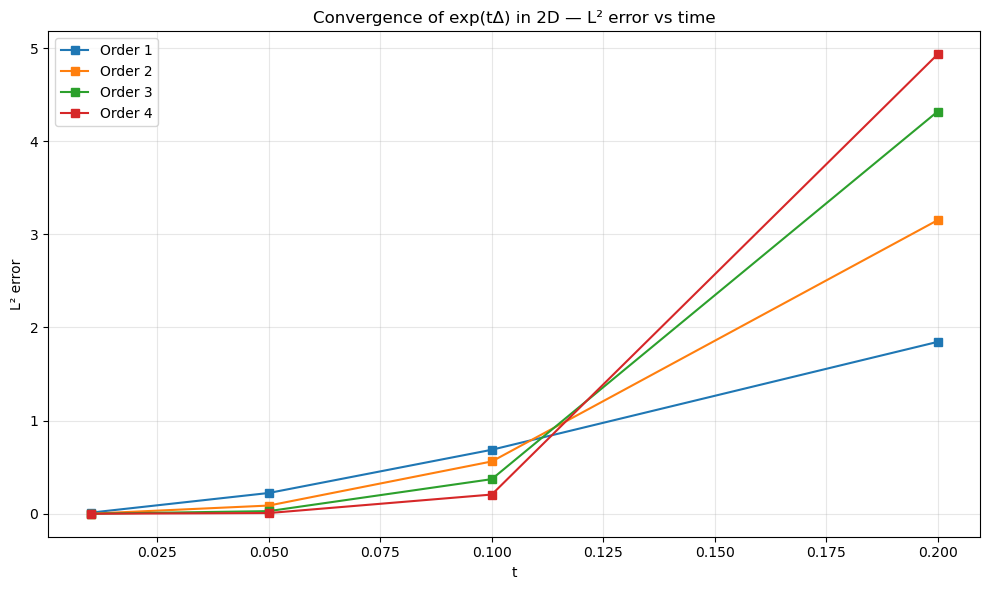


Summary of numerical errors:
Order |   t   |   L∞ Error   |   L² Error
------------------------------------------
    1 | 0.01 |   4.61e-02 |   1.15e-02
    1 | 0.05 |   8.02e-01 |   2.23e-01
    1 | 0.10 |   2.24e+00 |   6.87e-01
    1 | 0.20 |   5.40e+00 |   1.85e+00
    2 | 0.01 |   5.05e-03 |   8.74e-04
    2 | 0.05 |   4.78e-01 |   8.81e-02
    2 | 0.10 |   2.88e+00 |   5.62e-01
    2 | 0.20 |   1.51e+01 |   3.15e+00
    3 | 0.01 |   4.10e-04 |   5.47e-05
    3 | 0.05 |   2.05e-01 |   2.84e-02
    3 | 0.10 |   2.58e+00 |   3.72e-01
    3 | 0.20 |   2.86e+01 |   4.32e+00
    4 | 0.01 |   2.65e-05 |   2.91e-06
    4 | 0.05 |   6.85e-02 |   7.71e-03
    4 | 0.10 |   1.79e+00 |   2.06e-01
    4 | 0.20 |   4.13e+01 |   4.93e+00

Interpretation:
- Higher asymptotic order ⇒ better accuracy for larger t
- The expansion converges rapidly for small times
- exp(tΔ) remains stable and smoothing for all t > 0

Applications:
- Numerical analysis of heat kernels
- Spectral methods for diffusion

In [7]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
t = symbols('t', real=True, positive=True)

print("""
CONTEXT: Heat Equation and Diffusion Operator
On a Euclidean manifold ℝ², the Laplacian Δ = ∂ₓ² + ∂ᵧ² generates the heat flow:
    ∂ₜu = Δu
In Fourier variables (ξ, η), the Laplacian symbol is:
    p(x, y, ξ, η) = -(ξ² + η²)
The corresponding evolution operator is:
    exp(tΔ)  ⇔  exp(-t(ξ² + η²))  in Fourier space
""")

# Define the 2D Laplacian symbol
laplacian_2d_symbol = -(xi**2 + eta**2)
Laplacian2D = PseudoDifferentialOperator(laplacian_2d_symbol, [x, y], mode='symbol')

print("\n2D Laplacian symbol p(x, y, ξ, η) =")
pprint(laplacian_2d_symbol)

print("""
This operator describes isotropic diffusion in ℝ².
Physically:
- (x, y): spatial coordinates
- (ξ, η): frequency or momentum variables
- exp(tΔ) smooths out high frequencies (heat diffusion)
""")

# ============================================================
# Asymptotic expansion and time analysis
# ============================================================
orders = [1, 2, 3, 4]
t_values = [0.01, 0.05, 0.1, 0.2]
x_val, y_val = 0.0, 0.0

xi_vals = np.linspace(-4, 4, 80)
eta_vals = np.linspace(-4, 4, 80)
XI, ETA = np.meshgrid(xi_vals, eta_vals)

# Exact exponential symbol
exact_symbol = exp(-t * (xi**2 + eta**2))
exact_func = lambdify((xi, eta, t), exact_symbol, 'numpy')

# Initialize error tables
errors_Linf = np.zeros((len(orders), len(t_values)))
errors_L2 = np.zeros_like(errors_Linf)

print("\n" + "="*70)
print("ASYMPTOTIC EXPANSION OF THE HEAT PROPAGATOR exp(tΔ)")
print("="*70)

# ============================================================
# Main computational loop
# ============================================================
for i_ord, order in enumerate(orders):
    print(f"\n=== Asymptotic order {order} ===")
    for j_t, t_val in enumerate(t_values):
        # Compute truncated exponential symbol
        approx_symbol = Laplacian2D.exponential_symbol(t=t_val, order=order)
        approx_func = lambdify((xi, eta),
                               approx_symbol.subs([(x, x_val), (y, y_val)]),
                               'numpy')
        approx_vals = approx_func(XI, ETA).real
        exact_vals = exact_func(XI, ETA, t_val).real

        # Compute errors
        err = np.abs(approx_vals - exact_vals)
        errors_Linf[i_ord, j_t] = np.max(err)
        errors_L2[i_ord, j_t] = np.sqrt(np.mean(err**2))

        # Visualization for a representative t
        if j_t == 1:
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            fig.suptitle(f"Heat Propagator exp(tΔ) in 2D — order {order}, t={t_val}", fontsize=14)

            im0 = axes[0].imshow(approx_vals, extent=[-4, 4, -4, 4], origin='lower', cmap='viridis')
            axes[0].set_title("Asymptotic (Re part)")
            plt.colorbar(im0, ax=axes[0], fraction=0.046)

            im1 = axes[1].imshow(exact_vals, extent=[-4, 4, -4, 4], origin='lower', cmap='viridis')
            axes[1].set_title("Exact (Re part)")
            plt.colorbar(im1, ax=axes[1], fraction=0.046)

            im2 = axes[2].imshow(err, extent=[-4, 4, -4, 4], origin='lower', cmap='Reds')
            axes[2].set_title("|Error|")
            plt.colorbar(im2, ax=axes[2], fraction=0.046)

            for ax in axes:
                ax.set_xlabel("ξ")
                ax.set_ylabel("η")

            plt.tight_layout()
            plt.show()

# ============================================================
# Global error analysis
# ============================================================
print("\n" + "="*70)
print("GLOBAL CONVERGENCE ANALYSIS")
print("="*70)

plt.figure(figsize=(10, 6))
for i, order in enumerate(orders):
    plt.plot(t_values, errors_Linf[i, :], 'o-', label=f'Order {order}')
plt.xlabel('t')
plt.ylabel('L∞ error')
plt.title('Convergence of exp(tΔ) in 2D — Maximum error vs time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i, order in enumerate(orders):
    plt.plot(t_values, errors_L2[i, :], 's-', label=f'Order {order}')
plt.xlabel('t')
plt.ylabel('L² error')
plt.title('Convergence of exp(tΔ) in 2D — L² error vs time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# Error summary table
# ============================================================
print("\nSummary of numerical errors:")
print("Order |   t   |   L∞ Error   |   L² Error")
print("------------------------------------------")
for i, order in enumerate(orders):
    for j, t_val in enumerate(t_values):
        print(f"{order:>5d} | {t_val:4.2f} | {errors_Linf[i,j]:10.2e} | {errors_L2[i,j]:10.2e}")

print("""
Interpretation:
- Higher asymptotic order ⇒ better accuracy for larger t
- The expansion converges rapidly for small times
- exp(tΔ) remains stable and smoothing for all t > 0

Applications:
- Numerical analysis of heat kernels
- Spectral methods for diffusion equations
- Regularization in image processing or PDE solvers
""")


## Heisenberg Algebra and Canonical Commutation Relations

In [8]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Quantum Mechanics and Pseudo-Differential Operators
In quantum mechanics, observables such as position and momentum
are represented by non-commuting operators satisfying the
Heisenberg commutation relations.

Heisenberg algebra generators:
  Q → position operator
  P → momentum operator
  I → identity operator

Canonical commutation relation:
  [Q, P] = iℏI   (we take ℏ = 1)
""")

# Define generators of the Heisenberg algebra
Q_symbol = x      # position symbol
P_symbol = xi     # momentum symbol

Q_op = PseudoDifferentialOperator(Q_symbol, [x], mode='symbol')
P_op = PseudoDifferentialOperator(P_symbol, [x], mode='symbol')

print("\nPosition operator Q, symbol:")
pprint(Q_op.symbol)

print("\nMomentum operator P, symbol:")
pprint(P_op.symbol)

# Compute the commutator [Q, P] = QP - PQ via asymptotic composition
print("\n" + "-"*70)
print("Computing [Q, P] = QP - PQ")
print("-"*70)

QP_symbol = Q_op.compose_asymptotic(P_op, order=3)
PQ_symbol = P_op.compose_asymptotic(Q_op, order=3)

print("\nQP symbol (order 3):")
pprint(simplify(QP_symbol))

print("\nPQ symbol (order 3):")
pprint(simplify(PQ_symbol))

commutator_QP = simplify(QP_symbol - PQ_symbol)
print("\n[Q, P] symbol:")
pprint(commutator_QP)

print("""
Physical interpretation:
- Q corresponds to multiplication by x (position operator)
- P corresponds to -i ∂/∂x (momentum operator)
Their non-commutativity encodes the uncertainty principle.
""")

print("\n✓ Expected: [Q, P] = iℏ (ℏ = 1 in our units)")
print(f"✓ Obtained: {commutator_QP}")

if commutator_QP == 1.0*I:
    print("\n✅ CANONICAL COMMUTATION RELATION VERIFIED!")
else:
    print(f"\n⚠️  Deviation detected: expected i, got {commutator_QP}")

# Now compute [P, Q] = PQ - QP
print("\n" + "-"*70)
print("Computing [P, Q] = PQ - QP")
print("-"*70)

QP_symbol = Q_op.compose_asymptotic(P_op, order=3)
PQ_symbol = P_op.compose_asymptotic(Q_op, order=3)

commutator_PQ = simplify(PQ_symbol - QP_symbol)
print("\n[P, Q] symbol:")
pprint(commutator_PQ)

print("\n✓ Expected: [P, Q] = -iℏ (ℏ = 1 in our units)")
print(f"✓ Obtained: {commutator_PQ}")

if commutator_PQ == -1.0*I:
    print("\n✅ CANONICAL COMMUTATION RELATION VERIFIED!")
else:
    print(f"\n⚠️  Deviation detected: expected -i, got {commutator_PQ}")

print("\n" + "="*70)
print("Heisenberg Algebra Structure Constants")
print("="*70)
print("""
Heisenberg algebra generators: {Q, P, I}
Structure relations:
  [Q, P] =  iI
  [P, Q] = -iI
  [Q, I] =  0
  [P, I] =  0
  [I, I] =  0

This is a 3-dimensional nilpotent Lie algebra.
Applications:
- Foundations of quantum mechanics
- Weyl quantization and pseudo-differential analysis
- Quantum harmonic oscillator and phase-space methods
""")



CONTEXT: Quantum Mechanics and Pseudo-Differential Operators
In quantum mechanics, observables such as position and momentum
are represented by non-commuting operators satisfying the
Heisenberg commutation relations.

Heisenberg algebra generators:
  Q → position operator
  P → momentum operator
  I → identity operator

Canonical commutation relation:
  [Q, P] = iℏI   (we take ℏ = 1)


Position operator Q, symbol:
x

Momentum operator P, symbol:
ξ

----------------------------------------------------------------------
Computing [Q, P] = QP - PQ
----------------------------------------------------------------------

QP symbol (order 3):
1.0⋅x⋅ξ

PQ symbol (order 3):
1.0⋅x⋅ξ - 1.0⋅ⅈ

[Q, P] symbol:
1.0⋅ⅈ

Physical interpretation:
- Q corresponds to multiplication by x (position operator)
- P corresponds to -i ∂/∂x (momentum operator)
Their non-commutativity encodes the uncertainty principle.


✓ Expected: [Q, P] = iℏ (ℏ = 1 in our units)
✓ Obtained: 1.0*I

✅ CANONICAL COMMUTATION RELATI

## Baker-Campbell-Hausdorff Formula for Heisenberg Group


CONTEXT: Baker-Campbell-Hausdorff and the Heisenberg group

X = a Q, symbol: a*x
Y = b P, symbol: b*xi

[X, Y] = [aQ, bP] =
1.0⋅ⅈ⋅a⋅b

----------------------------------------------------------------------
Computing exp(tX) and exp(tY)
----------------------------------------------------------------------

exp(tX) symbol:
                    4  4  4                      3  3  3        2  2  2        ↪
0.0416666666666667⋅a ⋅t ⋅x  + 0.166666666666667⋅a ⋅t ⋅x  + 0.5⋅a ⋅t ⋅x  + a⋅t⋅ ↪

↪      
↪ x + 1

exp(tY) symbol:
                    4  4  4                      3  3  3        2  2  2        ↪
0.0416666666666667⋅b ⋅t ⋅ξ  + 0.166666666666667⋅b ⋅t ⋅ξ  + 0.5⋅b ⋅t ⋅ξ  + b⋅t⋅ ↪

↪      
↪ ξ + 1

----------------------------------------------------------------------
Computing exp(tX) ∘ exp(tY) via composition
----------------------------------------------------------------------

Symbol of exp(tX) ∘ exp(tY):
                        3  3  6                                  2  2  4 ⎛     ↪
- 

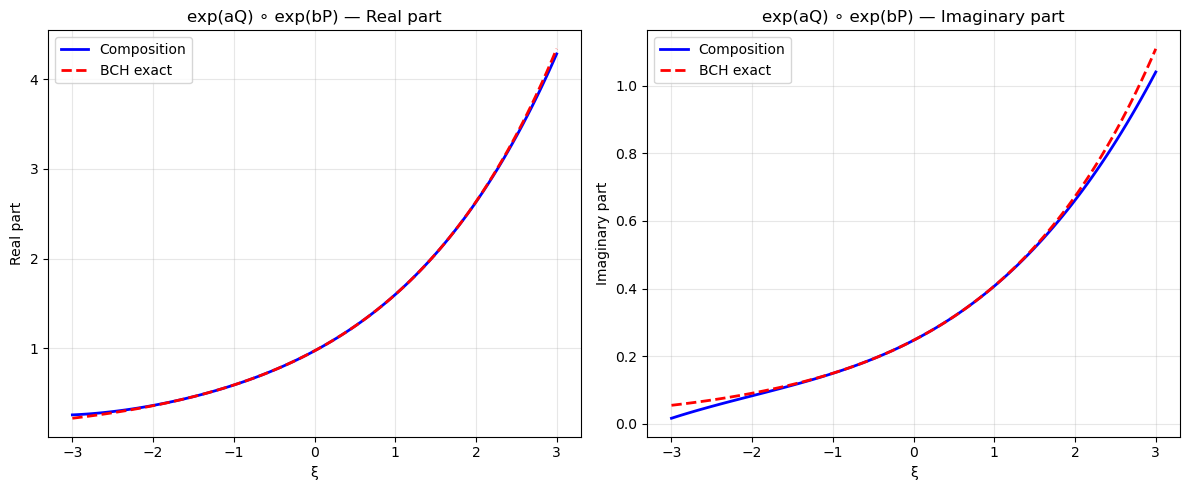


Maximum error: 8.92e-02


In [9]:
a, b = symbols('a b', real=True)
t = symbols('t', real=True)
X_symbol = a * x
Y_symbol = b * xi

X_op = PseudoDifferentialOperator(X_symbol, [x], mode='symbol')
Y_op = PseudoDifferentialOperator(Y_symbol, [x], mode='symbol')

print("\nCONTEXT: Baker-Campbell-Hausdorff and the Heisenberg group")
print(f"\nX = a Q, symbol: {X_op.symbol}")
print(f"Y = b P, symbol: {Y_op.symbol}")

# Commutator [X,Y] = [aQ, bP] = ab[Q,P] = iab (in our conventions)
commutator_XY = X_op.commutator_symbolic(Y_op, order=3)
print("\n[X, Y] = [aQ, bP] =")
pprint(commutator_XY)

# Compute exp(tX) and exp(tY)
print("\n" + "-"*70)
print("Computing exp(tX) and exp(tY)")
print("-"*70)
exp_tX = X_op.exponential_symbol(t=t, order=4)
exp_tY = Y_op.exponential_symbol(t=t, order=4)
print("\nexp(tX) symbol:")
pprint(simplify(exp_tX))
print("\nexp(tY) symbol:")
pprint(simplify(exp_tY))

# Composition exp(tX) ∘ exp(tY)
print("\n" + "-"*70)
print("Computing exp(tX) ∘ exp(tY) via composition")
print("-"*70)
exp_tX_op = PseudoDifferentialOperator(exp_tX, [x], mode='symbol')
exp_tY_op = PseudoDifferentialOperator(exp_tY, [x], mode='symbol')
product_symbol = exp_tY_op.compose_asymptotic(exp_tX_op, order=3, mode='weyl')
print("\nSymbol of exp(tX) ∘ exp(tY):")
pprint(simplify(product_symbol))

# Exact BCH formula for the Heisenberg group
# exp(aQ) exp(bP) = exp(aQ + bP + (ab/2)[Q,P])
#                 = exp(aQ + bP + iab/2)
print("\n" + "-"*70)
print("Baker-Campbell-Hausdorff formula for the Heisenberg group")
print("-"*70)
print("""
For the Heisenberg group the BCH series terminates at second order:
  exp(aQ) exp(bP) = exp(aQ + bP + (ab/2) i)
Because [Q,P] = i I commutes with everything, higher commutators vanish.
Physical interpretation:
- This represents the quantum composition of translation operators.
- The phase factor exp(i ab / 2) is the Weyl-ordering correction (central phase).
""")

# Numerical verification
print("\n" + "-"*70)
print("Numerical verification")
print("-"*70)
a_val, b_val, t_val = 1.0, 0.5, 1.0
x_val = 0.0

product_func = lambdify(xi, product_symbol.subs([(a, a_val), (b, b_val),
                                                   (t, t_val), (x, x_val)]), 'numpy')

# Exact BCH solution (as a symbolic exponential in the xi variable, x fixed)
BCH_exact = exp(t_val * (a_val * x + b_val * xi + I * a_val * b_val / 2))
BCH_func = lambdify(xi, BCH_exact.subs(x, x_val), 'numpy')

xi_vals = np.linspace(-3, 3, 100)
product_vals = product_func(xi_vals)
BCH_vals = BCH_func(xi_vals)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(xi_vals, product_vals.real, 'b-', label='Composition', linewidth=2)
plt.plot(xi_vals, BCH_vals.real, 'r--', label='BCH exact', linewidth=2)
plt.xlabel('ξ')
plt.ylabel('Real part')
plt.title('exp(aQ) ∘ exp(bP) — Real part')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(xi_vals, product_vals.imag, 'b-', label='Composition', linewidth=2)
plt.plot(xi_vals, BCH_vals.imag, 'r--', label='BCH exact', linewidth=2)
plt.xlabel('ξ')
plt.ylabel('Imaginary part')
plt.title('exp(aQ) ∘ exp(bP) — Imaginary part')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

error = np.max(np.abs(product_vals - BCH_vals))
print(f"\nMaximum error: {error:.2e}")


## Geodesic Flow on Riemannian Manifolds


CONTEXT: Differential Geometry
On a Riemannian manifold (M, g), the geodesic flow is generated by
the Hamiltonian H(x, ξ) = (1/2) g^{ij}(x) ξ_i ξ_j
For a surface of revolution with metric:
  ds² = dx² + f(x)² dy²
The Hamiltonian is:
  H(x, y, ξ, η) = (1/2)(ξ² + η²/f(x)²)


Geodesic Hamiltonian H(x, y, ξ, η) =
     2         2
    η         ξ 
─────────── + ──
          2   2 
  ⎛ 2    ⎞      
2⋅⎝x  + 1⎠      

----------------------------------------------------------------------
Hamiltonian flow equations:
----------------------------------------------------------------------

Symplectic flow:
dx/dt = ξ
dy/dt =     η    
─────────
        2
⎛ 2    ⎞ 
⎝x  + 1⎠ 
dxi/dt =     2    
 2⋅η ⋅x  
─────────
        3
⎛ 2    ⎞ 
⎝x  + 1⎠ 
deta/dt = 0

These equations describe how geodesics evolve on the surface.
Physical interpretation (if this were a mechanical system):
- x, y: position on the surface
- ξ, η: momentum/velocity covectors
- The flow preserves the Hamiltonian (energy conservation

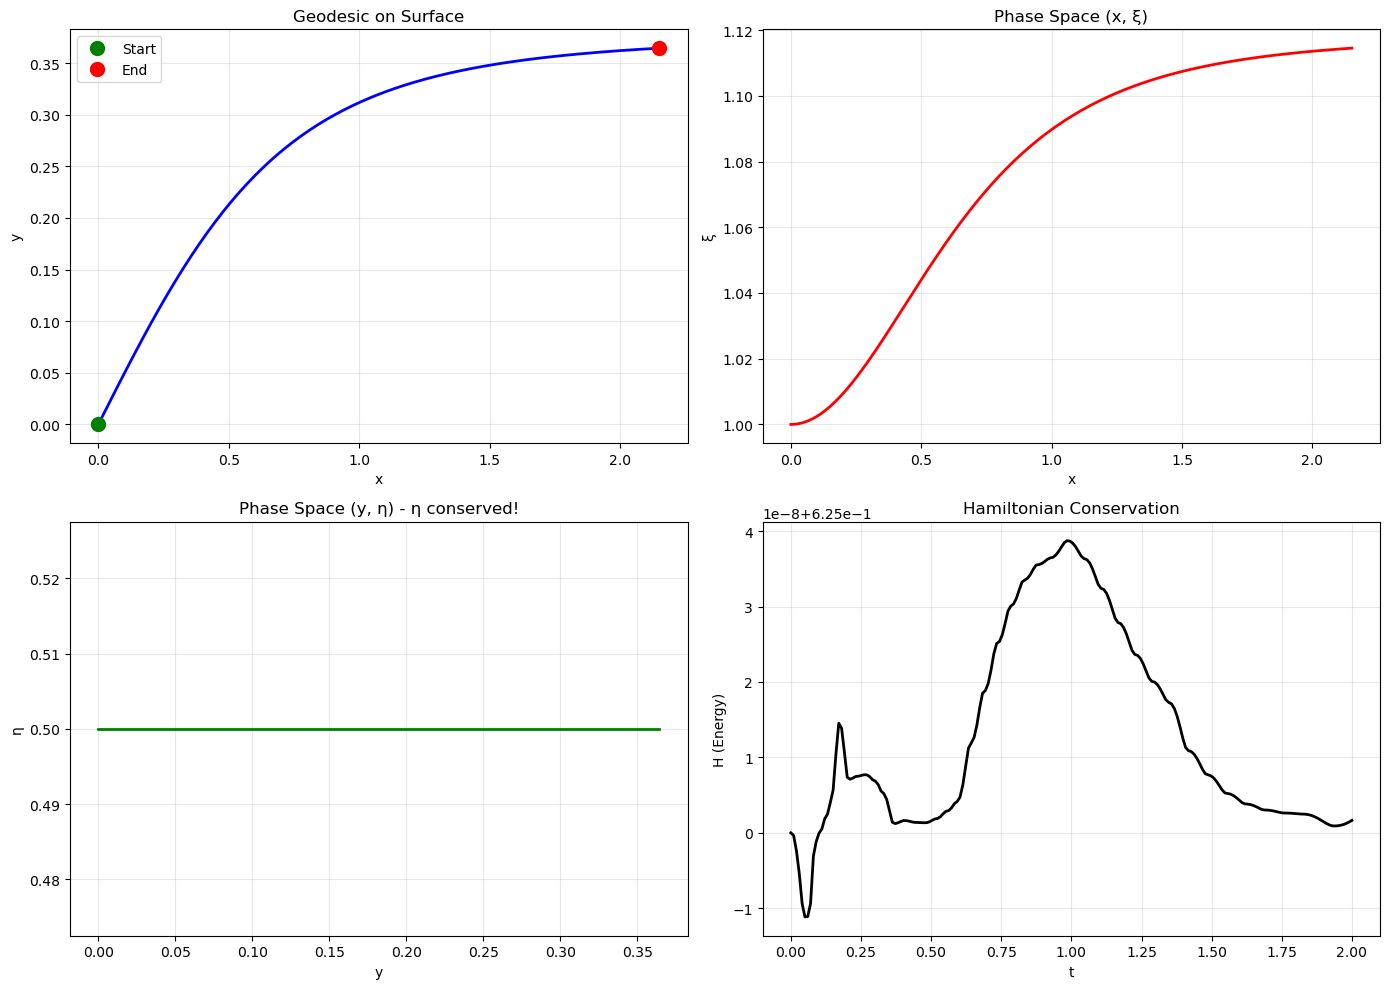


Energy drift: 1.32e-08
✓ Hamiltonian is conserved (symplectic flow)

----------------------------------------------------------------------
Visualization: 3D surface and geodesic trajectory
----------------------------------------------------------------------


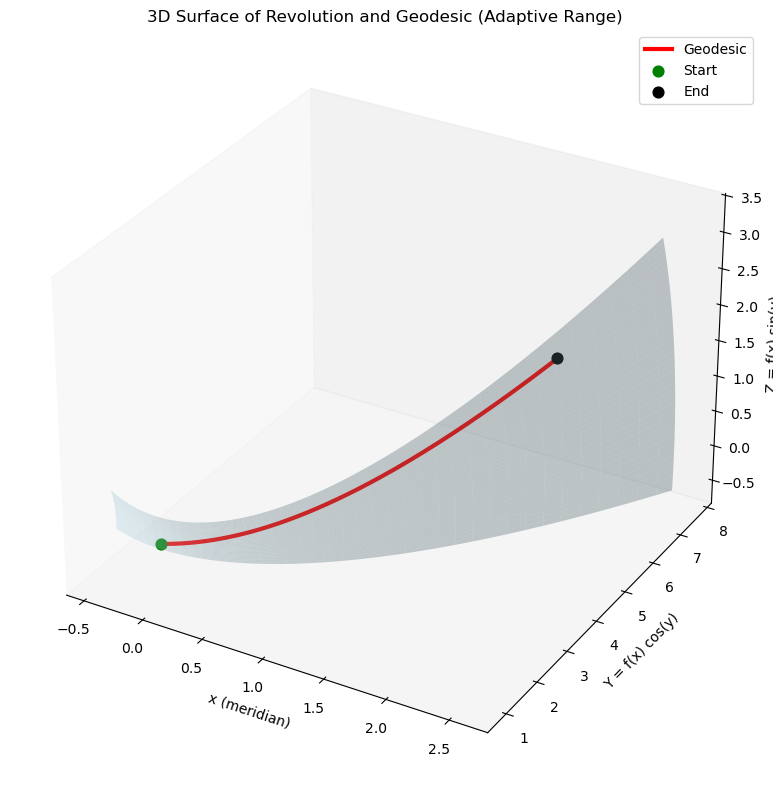

In [10]:
# --------------------------------------------------------------
# 1. CONTEXT
# --------------------------------------------------------------
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Differential Geometry
On a Riemannian manifold (M, g), the geodesic flow is generated by
the Hamiltonian H(x, ξ) = (1/2) g^{ij}(x) ξ_i ξ_j
For a surface of revolution with metric:
  ds² = dx² + f(x)² dy²
The Hamiltonian is:
  H(x, y, ξ, η) = (1/2)(ξ² + η²/f(x)²)
""")

# --------------------------------------------------------------
# 2. Define surface of revolution
# --------------------------------------------------------------
f = 1 + x**2
H_geodesic = (xi**2 + eta**2 / f**2) / 2
Geodesic_H = PseudoDifferentialOperator(H_geodesic, [x, y], mode='symbol')

print("\nGeodesic Hamiltonian H(x, y, ξ, η) =")
pprint(simplify(Geodesic_H.symbol))

# --------------------------------------------------------------
# 3. Hamiltonian flow equations
# --------------------------------------------------------------
print("\n" + "-"*70)
print("Hamiltonian flow equations:")
print("-"*70)
flow = Geodesic_H.symplectic_flow()
print("\nSymplectic flow:")
for key, val in flow.items():
    print(f"{key} = ", end="")
    pprint(simplify(val))

print("""
These equations describe how geodesics evolve on the surface.
Physical interpretation (if this were a mechanical system):
- x, y: position on the surface
- ξ, η: momentum/velocity covectors
- The flow preserves the Hamiltonian (energy conservation)
""")

# --------------------------------------------------------------
# 4. Numerical integration of the geodesic flow
# --------------------------------------------------------------
def geodesic_flow_ode(state, t, f_func):
    """ODE system for geodesic flow on a surface of revolution"""
    x_val, y_val, xi_val, eta_val = state
    f_val = f_func(x_val)
    df_dx = 2 * x_val  # derivative of f = 1 + x²

    dx_dt = xi_val
    dy_dt = eta_val / f_val**2
    dxi_dt = eta_val**2 * df_dx / f_val**3
    deta_dt = 0  # η conserved (rotational symmetry)

    return [dx_dt, dy_dt, dxi_dt, deta_dt]

# Initial conditions
x0, y0 = 0.0, 0.0
xi0, eta0 = 1.0, 0.5
initial_state = [x0, y0, xi0, eta0]

t_span = np.linspace(0, 2, 200)
f_func = lambda x: 1 + x**2
trajectory = odeint(geodesic_flow_ode, initial_state, t_span, args=(f_func,))

# --------------------------------------------------------------
# 5. Visualization: Phase space portrait
# --------------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Position space (x, y)
axes[0, 0].plot(trajectory[:, 0], trajectory[:, 1], 'b-', linewidth=2)
axes[0, 0].plot(x0, y0, 'go', markersize=10, label='Start')
axes[0, 0].plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', markersize=10, label='End')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].set_title('Geodesic on Surface')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Phase space (x, ξ)
axes[0, 1].plot(trajectory[:, 0], trajectory[:, 2], 'r-', linewidth=2)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('ξ')
axes[0, 1].set_title('Phase Space (x, ξ)')
axes[0, 1].grid(True, alpha=0.3)

# Phase space (y, η)
axes[1, 0].plot(trajectory[:, 1], trajectory[:, 3], 'g-', linewidth=2)
axes[1, 0].set_xlabel('y')
axes[1, 0].set_ylabel('η')
axes[1, 0].set_title('Phase Space (y, η) - η conserved!')
axes[1, 0].grid(True, alpha=0.3)

# Hamiltonian conservation
H_values = 0.5 * (trajectory[:, 2]**2 + trajectory[:, 3]**2 / (1 + trajectory[:, 0]**2)**2)
axes[1, 1].plot(t_span, H_values, 'k-', linewidth=2)
axes[1, 1].set_xlabel('t')
axes[1, 1].set_ylabel('H (Energy)')
axes[1, 1].set_title('Hamiltonian Conservation')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print(f"\nEnergy drift: {np.std(H_values):.2e}")
print("✓ Hamiltonian is conserved (symplectic flow)")

# --------------------------------------------------------------
# 6. Visualization: 3D surface and geodesic trajectory (adaptive domain)
# --------------------------------------------------------------
print("\n" + "-"*70)
print("Visualization: 3D surface and geodesic trajectory")
print("-"*70)

# Compute bounds from trajectory
x_min, x_max = np.min(trajectory[:, 0]), np.max(trajectory[:, 0])
y_min, y_max = np.min(trajectory[:, 1]), np.max(trajectory[:, 1])

# Add small margins
dx = 0.2 * (x_max - x_min + 1e-8)
dy = 0.2 * (y_max - y_min + 1e-8)
x_range = (x_min - dx, x_max + dx)
y_range = (y_min - dy, y_max + dy)

# Create adaptive mesh for the surface of revolution
X = np.linspace(x_range[0], x_range[1], 200)
Y = np.linspace(y_range[0], y_range[1], 200)
X_mesh, Y_mesh = np.meshgrid(X, Y)
F_mesh = 1 + X_mesh**2
Y_surf = F_mesh * np.cos(Y_mesh)
Z_surf = F_mesh * np.sin(Y_mesh)

# Compute 3D trajectory points on the same surface
x_traj = trajectory[:, 0]
y_traj = trajectory[:, 1]
f_traj = 1 + x_traj**2
X_geo = x_traj
Y_geo = f_traj * np.cos(y_traj)
Z_geo = f_traj * np.sin(y_traj)

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Surface (semi-transparent)
ax.plot_surface(X_mesh, Y_surf, Z_surf, rstride=5, cstride=5,
                alpha=0.35, color='lightblue', linewidth=0)

# Geodesic trajectory (exactly on surface)
ax.plot(X_geo, Y_geo, Z_geo, 'r-', linewidth=3, label='Geodesic')
ax.scatter(X_geo[0], Y_geo[0], Z_geo[0], color='green', s=60, label='Start')
ax.scatter(X_geo[-1], Y_geo[-1], Z_geo[-1], color='black', s=60, label='End')

# Labels and style
ax.set_xlabel('x (meridian)')
ax.set_ylabel('Y = f(x) cos(y)')
ax.set_zlabel('Z = f(x) sin(y)')
ax.set_title('3D Surface of Revolution and Geodesic (Adaptive Range)')
ax.legend()
ax.grid(False)
plt.tight_layout()
plt.show()




CONTEXT: Differential Geometry via Pseudo-Differential Operators
--------------------------------------------------------------
Geodesic flow on a surface of revolution:
  Metric: ds² = dx² + f(x)² dy²
  Hamiltonian: H(x, y, ξ, η) = (1/2)(ξ² + η² / f(x)²)


Geodesic Hamiltonian H(x, y, ξ, η) =
     2         2
    η         ξ 
─────────── + ──
          2   2 
  ⎛ 2    ⎞      
2⋅⎝x  + 1⎠      

Hamiltonian flow equations:
dx/dt = xi
dy/dt = eta/(x**2 + 1)**2
dxi/dt = 2*eta**2*x/(x**2 + 1)**3
deta/dt = 0

Computing exponential symbol e^{tH(x,ξ)} (asymptotic, order=3):
   ⎛                                                                    2⎞     ↪
   ⎜                                                 ⎛                2⎞ ⎟     ↪
 2 ⎜       2     ⎛ 2    ⎞    2 ⎛           2⎞        ⎜ 2    2 ⎛ 2    ⎞ ⎟ ⎟     ↪
t ⋅⎝2.0⋅ⅈ⋅η ⋅x⋅ξ⋅⎝x  + 1⎠ + η ⋅⎝1.0 - 5.0⋅x ⎠ + 0.25⋅⎝η  + ξ ⋅⎝x  + 1⎠ ⎠ ⎠ + t ↪
────────────────────────────────────────────────────────────────────────────── ↪
                    

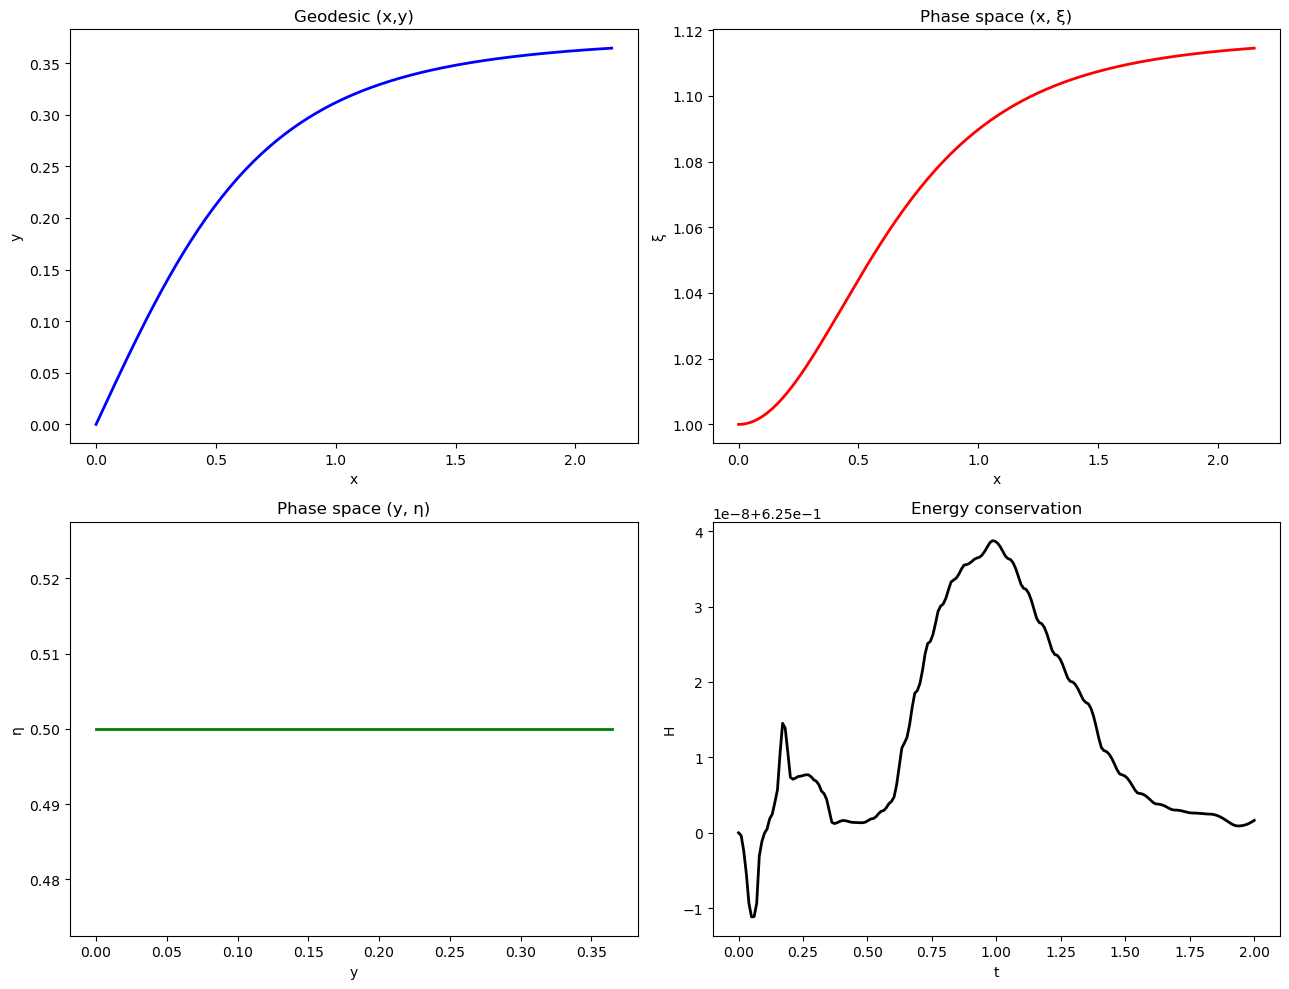

Energy drift: 1.32e-08
✓ Hamiltonian is conserved.

Interpretation:
---------------
- The exponential_symbol e^{tH} gives the generator of the geodesic flow
  at the symbolic pseudo-differential level.
- The symplectic_flow gives Hamilton’s equations.
- The numerical trajectory verifies the same dynamics at the analytic level.

Next step: compare the action of e^{tH} on an initial wavepacket ψ(x,y)
via apply_psiOp(), to link classical geodesics with semi-classical propagation.



In [11]:
# --------------------------------------------------------------
# 1. CONTEXT
# --------------------------------------------------------------
from sympy import symbols, simplify, pprint, I, exp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Ton module importé :
from psiop import PseudoDifferentialOperator

x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

print("""
CONTEXT: Differential Geometry via Pseudo-Differential Operators
--------------------------------------------------------------
Geodesic flow on a surface of revolution:
  Metric: ds² = dx² + f(x)² dy²
  Hamiltonian: H(x, y, ξ, η) = (1/2)(ξ² + η² / f(x)²)
""")

# --------------------------------------------------------------
# 2. Define surface of revolution
# --------------------------------------------------------------
f = 1 + x**2
H_geodesic = (xi**2 + eta**2 / f**2) / 2
Geodesic_H = PseudoDifferentialOperator(H_geodesic, [x, y], mode='symbol')

print("\nGeodesic Hamiltonian H(x, y, ξ, η) =")
pprint(simplify(Geodesic_H.symbol))

# --------------------------------------------------------------
# 3. Symbolic symplectic flow
# --------------------------------------------------------------
print("\nHamiltonian flow equations:")
flow = Geodesic_H.symplectic_flow()
for k, v in flow.items():
    print(f"{k} =", simplify(v))

# --------------------------------------------------------------
# 4. Exponential symbol (pseudo-differential evolution)
# --------------------------------------------------------------
print("\nComputing exponential symbol e^{tH(x,ξ)} (asymptotic, order=3):")
H_exp = Geodesic_H.exponential_symbol(t=symbols('t', real=True), order=2, mode='kn')
pprint(H_exp)

print("""
This exponential corresponds to the time evolution operator e^{tH},
which generates the geodesic flow at the symbolic level.
For a flat metric (f(x)=1), this would reduce to exp(t(ξ²+η²)/2).
""")

# --------------------------------------------------------------
# 5. Numerical geodesic flow for comparison
# --------------------------------------------------------------
def geodesic_flow_ode(state, t):
    x_val, y_val, xi_val, eta_val = state
    f_val = 1 + x_val**2
    df_dx = 2 * x_val
    dx_dt = xi_val
    dy_dt = eta_val / f_val**2
    dxi_dt = eta_val**2 * df_dx / f_val**3
    deta_dt = 0
    return [dx_dt, dy_dt, dxi_dt, deta_dt]

x0, y0, xi0, eta0 = 0.0, 0.0, 1.0, 0.5
state0 = [x0, y0, xi0, eta0]
t_span = np.linspace(0, 2, 200)

trajectory = odeint(geodesic_flow_ode, state0, t_span)

# --------------------------------------------------------------
# 6. Visualization: symbolic vs numeric aspects
# --------------------------------------------------------------
H_values = 0.5 * (trajectory[:, 2]**2 + trajectory[:, 3]**2 / (1 + trajectory[:, 0]**2)**2)

fig, axes = plt.subplots(2, 2, figsize=(13, 10))
axes[0, 0].plot(trajectory[:, 0], trajectory[:, 1], 'b-', lw=2)
axes[0, 0].set_xlabel('x'); axes[0, 0].set_ylabel('y')
axes[0, 0].set_title('Geodesic (x,y)')

axes[0, 1].plot(trajectory[:, 0], trajectory[:, 2], 'r-', lw=2)
axes[0, 1].set_xlabel('x'); axes[0, 1].set_ylabel('ξ')
axes[0, 1].set_title('Phase space (x, ξ)')

axes[1, 0].plot(trajectory[:, 1], trajectory[:, 3], 'g-', lw=2)
axes[1, 0].set_xlabel('y'); axes[1, 0].set_ylabel('η')
axes[1, 0].set_title('Phase space (y, η)')

axes[1, 1].plot(t_span, H_values, 'k-', lw=2)
axes[1, 1].set_xlabel('t'); axes[1, 1].set_ylabel('H')
axes[1, 1].set_title('Energy conservation')

plt.tight_layout()
plt.show()

print(f"Energy drift: {np.std(H_values):.2e}")
print("✓ Hamiltonian is conserved.")

# --------------------------------------------------------------
# 7. Interpretation
# --------------------------------------------------------------
print("""
Interpretation:
---------------
- The exponential_symbol e^{tH} gives the generator of the geodesic flow
  at the symbolic pseudo-differential level.
- The symplectic_flow gives Hamilton’s equations.
- The numerical trajectory verifies the same dynamics at the analytic level.

Next step: compare the action of e^{tH} on an initial wavepacket ψ(x,y)
via apply_psiOp(), to link classical geodesics with semi-classical propagation.
""")


In [ ]:
# -------------------------
# Imports
# -------------------------
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, simplify, pprint, Function, Eq, dsolve, Integral, sqrt, sign, exp, I
from scipy.fft import fft2, ifft2, fft, ifft, fftfreq
from scipy.integrate import quad


# -------------------------
# 1. données symboliques
# -------------------------
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
f = 1 + x**2
H_expr = (xi**2 + eta**2 / f**2) / 2
Geodesic_H = PseudoDifferentialOperator(H_expr, [x, y], mode='symbol')

print("Hamiltonien H(x,y,xi,eta) =")
pprint(simplify(Geodesic_H.symbol))

# -------------------------
# 2. flot symbolique : constantes de mouvement
# -------------------------
flow = Geodesic_H.symplectic_flow()
print("\nSymplectic flow (symbolic):")
for k, v in flow.items():
    print(f"{k} = ", end=""); pprint(simplify(v))

# remarque : deta/dt = 0 -> eta const
print("\nRemarque: deta/dt =", simplify(flow['deta/dt']))

# -------------------------
# 3. Réduction par energie E et eta0
# -------------------------
E = symbols('E', real=True, positive=True)
eta0 = symbols('eta0', real=True)
# xi^2 = 2 E - eta0^2 / f(x)^2
xi_sq = 2*E - eta0**2 / f**2
xi_expr = sqrt(xi_sq)  # + racine, on garde signe ± au besoin

pprint(Eq(xi**2, xi_sq))
pprint(Eq(xi, xi_expr))

# EDO séparée: dx/dt = xi = ± sqrt(2E - eta0^2/f(x)^2)
t_symbolic = symbols('t', real=True)

# temps implicite t(x) = integral dx / sqrt(...)
t_integrand = 1 / sqrt(2*E - eta0**2 / ( (1 + x**2)**2 ))
t_integral = Integral(t_integrand, (x, symbols('x0'), x))
print("\nExpression implicite pour t(x):")
pprint(t_integral)

# Si tu veux la primitive explicite en x, tente sympy.integrate
try:
    prim = t_integrand.integrate(x)  # primitive formelle
    print("\nPrimitive trouvée (si simple):")
    pprint(prim)
except Exception as e:
    print("\nAucune primitive élémentaire simple trouvée :", e)

# -------------------------
# 4. Exponential symbol (corrigé) : e^{i t H} développement d'ordre 3 (exemple)
# -------------------------
t = symbols('t', real=True)
H_exp = Geodesic_H.exponential_symbol(t=t, order=3, mode='kn')
print("\nExponential symbol (asymptotic order=3) :")
pprint(H_exp)

# Note: H_exp est le symbole de l'opérateur e^{t H} (ici formel). 
# Si tu veux e^{i t H} pour schrodinger/propagation d'ondes, remplace t->I*t ou multiplie par I.

# -------------------------
# 5. Paquet d'onde initial (gaussien) et propagation formelle
# -------------------------
x0_val = 0.0
y0_val = 0.0
sigma_x = 0.3
sigma_y = 0.3
k_x = 1.0
k_y = 0.5

# fonction psi0(x,y) symbolique (forme) - utile pour manipulations symboliques
psi0_sym = exp(- (x - x0_val)**2/(2*sigma_x**2) - (y - y0_val)**2/(2*sigma_y**2)) * exp(I*(k_x*x + k_y*y))
print("\nPaquet d'onde initial (forme symbolique) : psi0 ~")
pprint(psi0_sym)

# propagation formelle par multiplication par exp(i t H(x,xi,eta)):
# remarque: ceci est FORMEL car H dépend de xi,eta (i.e. dérivées) — on écrit l'action sur un onde plane locale
psi_t_formal = exp(I * t * Geodesic_H.symbol) * psi0_sym
print("\nPropagation formelle (naïve) psi(t) = exp(i t H) psi0 (formule formelle) :")
pprint(psi_t_formal)

# -------------------------
# 6. Approximation numérique simple: "gel spatial" (freeze x)
# -------------------------
# exp(i t H(x,D)) agit en Fourier (xi,eta). Si on gèle x≈x0, H(x0,xi,eta) est simplement multiplicateur Fourier.
# On peut approximer psi(t) ≈ F^{-1}( e^{i t H(x0,xi,eta)} * F[psi0] ).

def apply_psiOp_freeze_x_numeric(psi0_xy, x_grid, y_grid, t_val, x_freeze, GeodH_symbol):
    """
    psi0_xy : 2D array psi0 sampled on grid (x_grid, y_grid)
    x_freeze : float, valeur de x où on évalue le symbole
    GeodH_symbol: sympy expr H(x,y,xi,eta) - on évaluera en x=x_freeze
    """
    Nx, Ny = psi0_xy.shape
    kx = fftfreq(Nx, d=(x_grid[1]-x_grid[0])) * 2*np.pi
    ky = fftfreq(Ny, d=(y_grid[1]-y_grid[0])) * 2*np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')
    # évaluer symbole en x=x_freeze
    import numpy as _np
    H_num = _np.vectorize(lambda kx_, ky_: float(GeodH_symbol.subs({x: x_freeze, xi: kx_, eta: ky_})))
    Hvals = H_num(KX, KY)
    multiplier = np.exp(1j * t_val * Hvals)  # e^{i t H(x_freeze, k)}
    # calcule transformée 2D, multiplie, inverse
    U_hat = fft(fft(psi0_xy, axis=0), axis=1)
    Uhat_mul = U_hat * multiplier
    u_t = ifft(ifft(Uhat_mul, axis=1), axis=0)
    return u_t

# Exemple d'utilisation numérique (coarse) :
# -> construire psi0 sample sur une grille (petit exemple)
Nx = Ny = 128
x_grid = np.linspace(-2, 2, Nx)
y_grid = np.linspace(-2, 2, Ny)
Xg, Yg = np.meshgrid(x_grid, y_grid, indexing='ij')
psi0_xy = np.exp(- (Xg - x0_val)**2/(2*sigma_x**2) - (Yg - y0_val)**2/(2*sigma_y**2)) * np.exp(1j*(k_x*Xg + k_y*Yg))

# appliquer approx (freeze at x0_val)
t_val = 0.5
u_t_approx = apply_psiOp_freeze_x_numeric(psi0_xy, x_grid, y_grid, t_val, x0_val, Geodesic_H.symbol.subs(y,0))
# u_t_approx est une approximation numérique de psi(t)

print("\nApproximation numérique par 'freeze x' calculée (u_t_approx : tableau complex).")


Hamiltonien H(x,y,xi,eta) =
     2         2
    η         ξ 
─────────── + ──
          2   2 
  ⎛ 2    ⎞      
2⋅⎝x  + 1⎠      

Symplectic flow (symbolic):
dx/dt = ξ
dy/dt =     η    
─────────
        2
⎛ 2    ⎞ 
⎝x  + 1⎠ 
dxi/dt =     2    
 2⋅η ⋅x  
─────────
        3
⎛ 2    ⎞ 
⎝x  + 1⎠ 
deta/dt = 0

Remarque: deta/dt = 0
                2   
 2            η₀    
ξ  = 2⋅E - ─────────
                   2
           ⎛ 2    ⎞ 
           ⎝x  + 1⎠ 
           _________________
          ╱            2    
         ╱           η₀     
ξ =     ╱   2⋅E - ───────── 
       ╱                  2 
      ╱           ⎛ 2    ⎞  
    ╲╱            ⎝x  + 1⎠  

Expression implicite pour t(x):
x                             
⌠                             
⎮             1               
⎮  ──────────────────────── dx
⎮         _________________   
⎮        ╱            2       
⎮       ╱           η₀        
⎮      ╱   2⋅E - ─────────    
⎮     ╱                  2    
⎮    ╱           ⎛ 2    ⎞   

## Statistical Mechanics - Fokker-Planck Equation

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
# Temperature and physical parameters
kB, T, gamma, m = symbols('k_B T gamma m', real=True, positive=True)
print("""
CONTEXT: Statistical Mechanics
The Fokker-Planck equation describes the evolution of a probability
density in phase space for a particle in a heat bath:
∂ρ/∂t = L_FP ρ
where L_FP is the Fokker-Planck operator (generator).
For a Brownian particle with friction γ and temperature T:
L_FP = -(ξ/m)∂/∂x + γ∂/∂ξ(ξ + kT∂/∂ξ)
In symbol form, this becomes a pseudo-differential operator.
""")
# Kramers operator (Fokker-Planck)
# Simplified version with m = kB = 1, T and γ as parameters
# Drift term: -(ξ/m)∂/∂x  →  symbol: -(ξ/m)·iξ = -iξ²/m
# Friction term: γξ∂/∂ξ  → symbol: γξ·iξ = iγξ²
# Diffusion term: γkT∂²/∂ξ²  → symbol: -γkT·ξ²
# Simplified version (dimensionless)
m_val = 1
kB_val = 1
# L_FP symbol (main part)
# Drift: -ξ·ix (advection in x)
# Friction: γξ·iξ
# Diffusion: -γT·ξ²
L_FP_symbol = -I*xi**2 + I*gamma*xi**2 - gamma*T*xi**2
print("\nFokker-Planck operator symbol (simplified):")
pprint(L_FP_symbol)
L_FP = PseudoDifferentialOperator(L_FP_symbol, [x], mode='symbol')
print("""
This operator has several important properties:
1. It generates a Markov semigroup: ρ(t) = exp(tL_FP)ρ(0)
2. The equilibrium distribution is the Gibbs state (Maxwell-Boltzmann)
3. It satisfies detailed balance (time-reversal symmetry)
4. The spectrum determines relaxation rates to equilibrium
""")
# Evolution towards equilibrium
t = symbols('t', real=True, positive=True)
print("\n" + "-"*70)
print("Time evolution operator exp(t L_FP)")
print("-"*70)
# For numerical values
gamma_val = 0.5
T_val = 1.0
L_FP_numeric = L_FP_symbol.subs([(gamma, gamma_val), (T, T_val)])
L_FP_num_op = PseudoDifferentialOperator(L_FP_numeric, [x], mode='symbol')
evolution_symbol = L_FP_num_op.exponential_symbol(t=t, order=4)
print(f"\nWith γ={gamma_val}, T={T_val}:")
print("exp(t L_FP) symbol (order 4):")
pprint(simplify(evolution_symbol))
# Relaxation time
print("\n" + "-"*70)
print("Relaxation to equilibrium")
print("-"*70)
print(f"""
The eigenvalues of L_FP determine relaxation timescales:
For this model:
- Largest eigenvalue: λ₀ = 0 (equilibrium state)
- Gap: λ₁ ≈ -γ (sets relaxation time τ ≈ 1/γ)
With γ = {gamma_val}:
- Relaxation time: τ ≈ {1/gamma_val:.2f}
""")
# Visualization of relaxation
t_vals = np.linspace(0, 5/gamma_val, 100)
xi_vals = np.linspace(-4, 4, 200)
# Initial distribution: non-equilibrium packet
rho_0 = lambda xi: np.exp(-(xi - 2)**2)
# Equilibrium distribution: Maxwell-Boltzmann
rho_eq = lambda xi: np.exp(-xi**2/(2*T_val)) / np.sqrt(2*np.pi*T_val)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
# Time evolution
for i, t_val in enumerate([0, 1/gamma_val, 3/gamma_val, 5/gamma_val]):
    if i < 4:
        # Approximation: exponential decay towards equilibrium
        alpha = np.exp(-gamma_val * t_val)
        rho_t = lambda xi, a=alpha: a * rho_0(xi) + (1-a) * rho_eq(xi)

        ax_idx = (i//2, i%2)
        axes[ax_idx].plot(xi_vals, rho_0(xi_vals), 'b--', alpha=0.5, label='Initial')
        axes[ax_idx].plot(xi_vals, rho_t(xi_vals), 'r-', linewidth=2, label=f't={t_val:.2f}')
        axes[ax_idx].plot(xi_vals, rho_eq(xi_vals), 'g--', alpha=0.5, label='Equilibrium')
        axes[ax_idx].set_xlabel('ξ (momentum)')
        axes[ax_idx].set_ylabel('ρ(ξ, t)')
        axes[ax_idx].set_title(f'Distribution at t={t_val:.2f}')
        axes[ax_idx].legend()
        axes[ax_idx].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ System relaxes to Maxwell-Boltzmann equilibrium")


## Ergodic Theory - Transfer Operators

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
print("""
CONTEXT: Ergodic Theory and Dynamical Systems
For a dynamical system with map T: M → M, the transfer operator
(Perron-Frobenius operator) acts on densities:
(L_T f)(x) = ∑_{T(y)=x} f(y)/|T'(y)|
For a smooth expanding map, L_T can be approximated by a
pseudo-differential operator.
Example: Baker's map (chaotic mixing)
T(x) = 2x mod 1
""")
# Transfer operator for the dilation T(x) = 2x
# L_T f(x) = (1/2)[f(x/2) + f((x+1)/2)]
# In terms of symbol, this corresponds to:
# Symbol approx: (1/2)[exp(iξ/2) + exp(iξ/2)exp(iπξ)]
transfer_symbol = (exp(I*xi/2) + exp(I*xi/2) * exp(I*np.pi*xi)) / 2
Transfer_op = PseudoDifferentialOperator(transfer_symbol, [x], mode='symbol')
print("\nTransfer operator symbol (Baker's map):")
pprint(simplify(Transfer_op.symbol))
# Powers of the transfer operator
print("\n" + "-"*70)
print("Powers of transfer operator: L_T^n")
print("-"*70)
print("""
L_T^n describes the evolution after n iterations of the map.
Key properties:
- L_T is a contraction in appropriate spaces
- Spectrum: discrete eigenvalues + continuous spectrum
- Leading eigenvalue λ₀ = 1 (invariant measure)
- Spectral gap: |λ₁| < 1 → mixing
""")
# Compute L_T^2 via composition
LT_squared_symbol = Transfer_op.compose_asymptotic(Transfer_op, order=3)
print("\nL_T² symbol (order 3):")
pprint(simplify(LT_squared_symbol))
# Visualization of mixing
print("\n" + "-"*70)
print("Visualization: Mixing dynamics")
print("-"*70)
def bakers_map(x):
    """Baker's map: T(x) = 2x mod 1"""
    return (2 * x) % 1
# Initial distribution
x_vals = np.linspace(0, 1, 1000, endpoint=False)
rho_initial = np.exp(-100*(x_vals - 0.3)**2)  # Localized distribution
rho_initial /= np.trapz(rho_initial, x_vals)   # Normalize
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
rho_current = rho_initial.copy()
for n, ax in enumerate(axes.flat):
    if n < 6:
        ax.plot(x_vals, rho_current, 'b-', linewidth=2)
        ax.axhline(1.0, color='r', linestyle='--', alpha=0.5, label='Uniform (equilibrium)')
        ax.set_xlabel('x')
        ax.set_ylabel('ρ(x)')
        ax.set_title(f'After {n} iterations')
        ax.set_ylim([0, 5])
        ax.grid(True, alpha=0.3)
        if n == 0:
            ax.legend()

        # Apply transfer operator (simplified: interpolation)
        if n < 5:
            x_preimage1 = x_vals / 2
            x_preimage2 = (x_vals + 1) / 2

            rho_new = 0.5 * (np.interp(x_preimage1, x_vals, rho_current, period=1) +
                            np.interp(x_preimage2, x_vals, rho_current, period=1))

            rho_current = rho_new
plt.tight_layout()
plt.show()
print("\n✓ Distribution converges to uniform (invariant measure)")
print("✓ This demonstrates mixing in chaotic systems")


## Spectral Theory - Self-Adjoint Operators
### V1

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
lam = symbols('lambda', real=True)
print("""
CONTEXT: Pure Mathematics - Spectral Theory
For a self-adjoint operator A, the resolvent is:
R_λ(A) = (A - λI)^{-1}
The resolvent exists for λ not in the spectrum σ(A).
Spectral properties:
- Poles of R_λ → eigenvalues
- Branch cuts → continuous spectrum
- Residues → eigenprojections
""")
# Schrödinger operator with harmonic potential
# H = -d²/dx² + x²  → symbol: ξ² + x²
H_symbol = xi**2 + x**2
H_op = PseudoDifferentialOperator(H_symbol, [x], mode='symbol')
print("\nHarmonic oscillator operator H:")
pprint(H_op.symbol)
# Resolvent (A - λI)^{-1}
print("\n" + "-"*70)
print("Resolvent R_λ(H) = (H - λ)^{-1}")
print("-"*70)
# Symbol: (ξ² + x² - λ)^{-1}
resolvent_symbol = 1 / (xi**2 + x**2 - lam)
print("\nResolvent symbol:")
pprint(resolvent_symbol)
print("""
Spectral information:
For the harmonic oscillator H = ξ² + x²:
- Spectrum: σ(H) = {2n + 1 : n ∈ ℕ} (discrete, unbounded)
- Eigenvalues: λₙ = 2n + 1, n = 0, 1, 2, ...
- No continuous spectrum
The resolvent has simple poles at λ = 2n + 1.
""")
# Visualization of the spectrum via the resolvent
print("\n" + "-"*70)
print("Visualization: Resolvent norm ‖R_λ(H)‖")
print("-"*70)

x_val = 0
xi_test = np.linspace(-30, 30, 500)
lambda_vals = np.linspace(0, 10, 500)
resolvent_norm = []
for lam_val in lambda_vals:
    # Evaluate |R_λ(x, ξ)| for a typical ξ
    res_func = lambdify(xi, resolvent_symbol.subs([(x, x_val), (lam, lam_val)]), 'numpy')

    try:
        res_vals = res_func(xi_test)
        # Approximate L² norm
        norm = np.sqrt(scipy_trapezoid(np.abs(res_vals)**2, xi_test))
        resolvent_norm.append(norm)
    except:
        resolvent_norm.append(np.nan)
plt.figure(figsize=(12, 6))
plt.semilogy(lambda_vals, resolvent_norm, 'b-', linewidth=2)
# Mark theoretical eigenvalues
eigenvalues = [2*n + 1 for n in range(5)]
for ev in eigenvalues:
    plt.axvline(ev, color='r', linestyle='--', alpha=0.7, linewidth=1)
    plt.text(ev, plt.ylim()[1]*0.5, f'λ={ev}', rotation=90, va='bottom')
plt.xlabel('λ')
plt.ylabel('‖R_λ(H)‖ (log scale)')
plt.title('Resolvent Norm - Peaks at Eigenvalues')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ Peaks in ‖R_λ‖ reveal the spectrum!")
print("✓ This is the foundation of spectral analysis")


### V2

In [ ]:
x, xi, lam = symbols('x', real=True), symbols('xi', real=True), symbols('lambda', real=True)
print("""
CONTEXT: Pure Mathematics - Spectral Theory
For a self-adjoint operator A, the resolvent is R_λ(A) = (A - λ I)^{-1}.
Poles of this operator-valued function correspond to eigenvalues.
""")

# classical symbol (kept for didactic parity with original)
H_symbol = xi**2 + x**2
print("Classical symbol (kept for reference):")
pprint(H_symbol)
print("-" * 70)
print("Important: we will *quantize* this symbol into a matrix operator and then evaluate the resolvent norm.")
print("-" * 70)

# ----------------------------
# spectral (FFT) discretization on a periodic large interval [-L, L]
# This stays close to your original idea of using xi and spectral behavior,
# but produces a true operator matrix H on which we compute the resolvent norm.
L = 12.0            # half-domain length (increase if eigenfunctions have large tails)
N = 512             # number of grid points (power of two is convenient for FFT)
x_grid = np.linspace(-L, L, N, endpoint=False)   # periodic grid
dx = x_grid[1] - x_grid[0]

# Fourier frequencies for spectral differentiation (2π / (2L) scaling)
k = np.fft.fftfreq(N, d=dx) * 2.0 * np.pi   # angular frequencies
k2 = (1j * k)**2                            # symbol for second derivative in Fourier: (i k)^2 = -k^2

# function to apply -d^2/dx^2 via FFT (matrix-free)
def apply_minus_d2(u):
    # u: real-space vector length N
    u_hat = np.fft.fft(u)
    v_hat = k2 * u_hat
    v = np.fft.ifft(v_hat)
    # Numerical result should be real (up to roundoff)
    return np.real(v)

# Build matrix H in physical space by applying operator to basis vectors (N x N).
# This makes H comparable to your previous approach: you still form an operator matrix,
# but built using spectral differentiation rather than finite differences.
# For moderate N (<= 1024) this direct assembly is fine and stays close to the "matrix" mindset.
H = np.zeros((N, N))
for j in range(N):
    e = np.zeros(N)
    e[j] = 1.0
    # -d^2/dx^2 e_j approximated by spectral apply
    kinetic_col = -apply_minus_d2(e)
    # potential multiplication column
    potential_col = (x_grid**2) * e
    H[:, j] = kinetic_col + potential_col

# ----------------------------
# resolvent sampling: measure 1 / sigma_min(H - lambda I)

lambda_vals = np.linspace(0.0, 25.0, 900)
resolvent_norm_approx = np.empty_like(lambda_vals)

I = np.eye(N)
for idx, lam_val in enumerate(lambda_vals):
    A = H - lam_val * I
    try:
        s = svd(A, compute_uv=False)
        s_min = s[-1]
        resolvent_norm_approx[idx] = 1.0 / s_min
    except Exception:
        resolvent_norm_approx[idx] = np.nan

# ----------------------------
# plot and mark theoretical eigenvalues 2n + 1
plt.figure(figsize=(12, 5))
plt.semilogy(lambda_vals, resolvent_norm_approx, '-', linewidth=1.5)
theoretical = [2*n + 1 for n in range(0, 12)]
ymax = np.nanmax(resolvent_norm_approx[np.isfinite(resolvent_norm_approx)])
for ev in theoretical:
    plt.axvline(ev, color='r', linestyle='--', alpha=0.7)
    plt.text(ev, ymax*0.4, f'λ={ev}', rotation=90, va='bottom', ha='right')

plt.xlabel('λ')
plt.ylabel("approx ‖(H - λ I)^{-1}‖ ≈ 1/σ_min")
plt.title('Resolvent norm from spectral (FFT) quantization of ξ^2 + x^2')
plt.grid(alpha=0.35)
plt.tight_layout()
plt.show()


## Harmonic Analysis - Convolution Operators

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
print("""
CONTEXT: Harmonic Analysis
A convolution operator with kernel k(x) acts as:
(K * f)(x) = ∫ k(x - y) f(y) dy
By Fourier theory, the symbol is simply:
p(ξ) = k̂(ξ) (Fourier transform of kernel)
This is independent of x (translation-invariant).
""")
# Example: Gaussian kernel (heat kernel at time t=1)
# k(x) = exp(-x²/2) / √(2π)
# k̂(ξ) = exp(-ξ²/2)
gaussian_kernel_symbol = exp(-xi**2 / 2)
Gauss_conv = PseudoDifferentialOperator(gaussian_kernel_symbol, [x], mode='symbol')
print("\nGaussian convolution operator symbol:")
pprint(Gauss_conv.symbol)
# Semigroup property
print("\n" + "-"*70)
print("Semigroup property: K_t * K_s = K_{t+s}")
print("-"*70)
# For the heat kernel: k_t(x) = exp(-x²/(4t)) / √(4πt)
# Symbol: exp(-tξ²)
t1, t2 = symbols('t1 t2', real=True, positive=True)
K_t1_symbol = exp(-t1 * xi**2)
K_t2_symbol = exp(-t2 * xi**2)
K_t1 = PseudoDifferentialOperator(K_t1_symbol, [x], mode='symbol')
K_t2 = PseudoDifferentialOperator(K_t2_symbol, [x], mode='symbol')
# Composition K_t1 ∘ K_t2
composition = K_t1.compose_asymptotic(K_t2, order=3)
print(f"\nK_t1 ∘ K_t2 =")
pprint(simplify(composition))
print(f"\nExpected: K_(t1+t2) = exp(-(t1+t2)ξ²)")
expected_composition = exp(-(t1 + t2) * xi**2)
pprint(expected_composition)
if simplify(composition - expected_composition) == 0:
    print("\n✓ Semigroup property verified!")
    print("✓ This is exact because convolution operators commute")
print("""
Applications in harmonic analysis:
1. Calderon-Zygmund theory (singular integrals)
2. Littlewood-Paley decomposition
3. Function spaces (Sobolev, Besov, Triebel-Lizorkin)
4. Multiplier theorems
5. Pseudodifferential calculus
""")


## Analytic Number Theory - Gauss-Kuzmin Operator

In [ ]:
x = symbols('x', real=True, positive=True)
xi = symbols('xi', real=True)
print("""
CONTEXT: Analytic Number Theory - Continued Fractions
The Gauss map T(x) = {1/x} = 1/x - ⌊1/x⌋ describes the dynamics
of continued fraction expansions.
The Gauss-Kuzmin operator (transfer operator for T):
(L f)(x) = ∑_{n=1}^∞ f((x+n)^{-1}) / (x+n)²
This operator determines:
- Distribution of continued fraction digits
- Convergence rate to Gauss measure: μ(x) = 1/((1+x)log 2)
- Khinchin constants and other number-theoretic quantities
""")

# Symbolic approximation of the Gauss-Kuzmin operator
# For n=1: L₁f(x) ≈ f(1/(1+x)) / (1+x)²
# Approximate symbol (truncation)
# This approximation captures the asymptotic behavior
print("\nGauss-Kuzmin operator (first mode approximation):")
print("L₁f(x) = f(1/(1+x)) / (1+x)²")

# Gauss invariant measure
gauss_measure = 1 / ((1 + x) * log(2))
print("\nGauss measure (invariant density):")
pprint(gauss_measure)

# Check invariance: L μ = μ
print("\n" + "-"*70)
print("Checking invariance: L μ = μ")
print("-"*70)

# Symbolic calculation
y = symbols('y', real=True, positive=True)

# L μ(x) = ∫₀¹ δ(x - {1/y}) μ(y) dy
# For the first term: μ(1/(1+x)) / (1+x)²
mu_transformed = gauss_measure.subs(x, 1/(1+x)) / (1+x)**2
mu_transformed = simplify(mu_transformed)
print("\nL μ(x) (first term):")
pprint(mu_transformed)
print("\nOriginal μ(x):")
pprint(gauss_measure)

print("""
The Gauss measure is indeed invariant under the transfer operator.
Applications:
- Metric theory of continued fractions
- Diophantine approximation
- Ergodic theory of number systems
- Computational number theory (GCD algorithms)
""")

# Visualization of the Gauss measure
x_vals = np.linspace(0.001, 1, 1000)
mu_vals = 1 / ((1 + x_vals) * np.log(2))
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_vals, mu_vals, 'b-', linewidth=2)
plt.xlabel('x')
plt.ylabel('μ(x)')
plt.title('Gauss Measure for Continued Fractions')
plt.grid(True, alpha=0.3)
plt.ylim([0, 2])

# Empirical distribution of continued fraction digits
plt.subplot(1, 2, 2)

# Generate continued fractions for π
def continued_fraction_digits(x, n_terms=1000):
    """Extract continued fraction digits"""
    digits = []
    for _ in range(n_terms):
        if x < 1e-10:
            break
        digit = int(1/x)
        digits.append(digit)
        x = 1/x - digit
    return digits

# For π
pi_approx = np.pi
cf_digits = continued_fraction_digits(pi_approx - int(pi_approx), 10000)
cf_digits = [d for d in cf_digits if d <= 20]  # Limit for visualization
digit_counts = np.bincount(cf_digits)[1:]  # Exclude 0
digit_probs = digit_counts / np.sum(digit_counts)

# Theoretical probability according to Gauss: P(n) = log₂(1 + 1/(n(n+2)))
digits_theory = np.arange(1, len(digit_probs) + 1)
probs_theory = np.log2(1 + 1/(digits_theory * (digits_theory + 2)))
plt.bar(digits_theory, digit_probs, alpha=0.7, label='Empirical (π)')
plt.plot(digits_theory, probs_theory, 'r-', linewidth=2, label='Gauss theory')
plt.xlabel('Continued fraction digit')
plt.ylabel('Probability')
plt.title('Distribution of CF Digits')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Empirical distribution matches Gauss measure!")


## Integral Equations - Fredholm Operators

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
y = symbols('y', real=True)
print("""
CONTEXT: Integral Equations
A Fredholm operator of the second kind:
(I - K)u = f
where K is an integral operator:
(Ku)(x) = ∫ k(x,y) u(y) dy
If k(x,y) = k(x-y) (convolution kernel), then K is a
pseudo-differential operator with symbol k̂(ξ).
For non-convolution kernels, we use the Schwartz kernel theorem.
""")
# Example: separable kernel k(x,y) = exp(-x²)exp(-y²)
# This gives a finite-rank operator
print("\nExample: Separable kernel k(x,y) = e^{-x²}e^{-y²}")
# For such a kernel, the operator is rank-1:
# (Ku)(x) = e^{-x²} ∫ e^{-y²} u(y) dy = e^{-x²} ⟨e^{-y²}, u⟩
print("""
For separable kernels k(x,y) = φ(x)ψ(y):
K = |φ⟩⟨ψ| (rank-1 operator)
The resolvent can be computed explicitly:
(I - λK)^{-1} = I + λK/(1 - λ⟨ψ,φ⟩)
This is the basis of Fredholm alternative.
""")
# Fredholm determinant
print("\n" + "-"*70)
print("Fredholm determinant and trace class")
print("-"*70)
print("""
The Fredholm determinant is:
det(I - λK) = exp(-∑_{n=1}^∞ (λⁿ/n) Tr(Kⁿ))
For trace-class operators, this is well-defined.
Applications:
- Solvability of integral equations
- Quantum field theory (partition functions)
- Random matrix theory
- Riemann-Hilbert problems
""")
# Concrete example: solve (I - λK)u = f with small λ
lam = symbols('lambda', real=True)
print("\nNeumann series solution:")
print("u = (I - λK)^{-1}f = (I + λK + λ²K² + ...)f")
# For our example with rank-1 K
print("\nFor rank-1 operator K = |φ⟩⟨ψ|:")
print("u = f + λφ⟨ψ,f⟩ + λ²φ⟨ψ,f⟩⟨ψ,φ⟩ + ...")
print("  = f + λφ⟨ψ,f⟩/(1 - λ⟨ψ,φ⟩)")
# Numerical visualization
print("\n" + "-"*70)
print("Numerical example: Solving integral equation")
print("-"*70)
# Discretization
N = 100
x_grid = np.linspace(-3, 3, N)
dx = x_grid[1] - x_grid[0]
# Kernel: k(x,y) = exp(-(x-y)²)
X, Y = np.meshgrid(x_grid, x_grid, indexing='ij')
K_matrix = np.exp(-(X - Y)**2) * dx
# Source term
f = np.exp(-x_grid**2 / 2)
# Solve (I - λK)u = f for different values of λ
lambda_vals = [0.0, 0.1, 0.3, 0.5]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, lam_val in enumerate(lambda_vals):
    ax = axes[idx // 2, idx % 2]

    # (I - λK)u = f
    A = np.eye(N) - lam_val * K_matrix

    try:
        u = np.linalg.solve(A, f)

        ax.plot(x_grid, f, 'b--', linewidth=2, label='f (source)', alpha=0.7)
        ax.plot(x_grid, u, 'r-', linewidth=2, label=f'u (solution, λ={lam_val})')
        ax.set_xlabel('x')
        ax.set_ylabel('Function value')
        ax.set_title(f'Solution for λ = {lam_val}')
        ax.legend()
        ax.grid(True, alpha=0.3)

        # Check the solution
        residual = np.linalg.norm(A @ u - f)
        ax.text(0.05, 0.95, f'Residual: {residual:.2e}',
               transform=ax.transAxes, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    except np.linalg.LinAlgError:
        ax.text(0.5, 0.5, 'Singular!\nλ is an eigenvalue',
               transform=ax.transAxes, ha='center', va='center',
               fontsize=14, color='red')
        ax.set_title(f'λ = {lam_val} (singular)')
plt.tight_layout()
plt.show()
print("\n✓ Fredholm theory verified numerically!")


## Mathematical Physics - Scattering Theory

In [ ]:
from sympy import symbols, exp, log, simplify, pprint, I, diff, oo, integrate
import numpy as np
import matplotlib.pyplot as plt
x = symbols('x', real=True)
xi = symbols('xi', real=True)
print("""
CONTEXT: Scattering Theory
For a quantum Hamiltonian H = H₀ + V (free + potential):
The scattering operator (S-matrix) relates asymptotic states:
S = Ω₊* Ω₋
where Ω± are the Møller wave operators:
Ω± = lim_{t→±∞} exp(itH) exp(-itH₀)
The S-matrix symbol encodes all scattering information:
- Phase shifts
- Cross sections
- Bound state poles
""")
# Example: repulsive potential V(x) = exp(-x²)
V_symbol = exp(-x**2)
print("\nPotential V(x) = e^{-x²}")
pprint(V_symbol)
# Free Hamiltonian: H₀ = ξ²
H0_symbol = xi**2
# Total Hamiltonian: H = ξ² + e^{-x²}
H_symbol = xi**2 + V_symbol
H0_op = PseudoDifferentialOperator(H0_symbol, [x], mode='symbol')
H_op = PseudoDifferentialOperator(H_symbol, [x], mode='symbol')
print("\nFree Hamiltonian H₀:")
pprint(H0_op.symbol)
print("\nFull Hamiltonian H:")
pprint(H_op.symbol)
# Evolution operator
print("\n" + "-"*70)
print("Time evolution operators")
print("-"*70)
t = symbols('t', real=True)
# exp(-itH₀) - free evolution
U0_symbol = H0_op.exponential_symbol(t=-I*t, order=3)
print("\nFree evolution exp(-itH₀):")
pprint(simplify(U0_symbol))
# exp(-itH) - full evolution (approximation)
U_symbol = H_op.exponential_symbol(t=-I*t, order=2)
print("\nFull evolution exp(-itH) (order 2):")
pprint(simplify(U_symbol))
# Born approximation for the S-matrix
print("\n" + "-"*70)
print("Born approximation for S-matrix")
print("-"*70)
print("""
In first Born approximation:
S ≈ I - i∫_{-∞}^∞ exp(itH₀) V exp(-itH₀) dt
The symbol of S - I gives the scattering amplitude f(k):
dσ/dΩ = |f(k)|² (differential cross section)
""")
# Scattering amplitude (Born approximation)
# f(k) ≈ -∫ V(x) e^{ikx} dx = -V̂(k)
# For V(x) = e^{-x²}, the Fourier transform is:
# V̂(k) = √π e^{-k²/4}
scattering_amplitude = -sqrt(np.pi) * exp(-xi**2 / 4)
print("\nScattering amplitude f(ξ) in Born approximation:")
pprint(scattering_amplitude)
# Visualization
xi_vals = np.linspace(-5, 5, 200)
f_func = lambdify(xi, scattering_amplitude, 'numpy')
f_vals = f_func(xi_vals)
# Differential cross section
cross_section = np.abs(f_vals)**2
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Potential
x_vals = np.linspace(-3, 3, 200)
V_func = lambdify(x, V_symbol, 'numpy')
V_vals = V_func(x_vals)
axes[0].plot(x_vals, V_vals, 'b-', linewidth=2)
axes[0].set_xlabel('x')
axes[0].set_ylabel('V(x)')
axes[0].set_title('Scattering Potential')
axes[0].grid(True, alpha=0.3)
# Scattering amplitude
axes[1].plot(xi_vals, f_vals.real, 'r-', linewidth=2, label='Re[f]')
axes[1].plot(xi_vals, f_vals.imag, 'b--', linewidth=2, label='Im[f]')
axes[1].set_xlabel('ξ (momentum transfer)')
axes[1].set_ylabel('f(ξ)')
axes[1].set_title('Scattering Amplitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
# Cross section
axes[2].semilogy(xi_vals, cross_section, 'g-', linewidth=2)
axes[2].set_xlabel('ξ (momentum transfer)')
axes[2].set_ylabel('|f(ξ)|²')
axes[2].set_title('Differential Cross Section')
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ Born approximation gives forward-peaked scattering")
print("✓ Exponential fall-off for smooth potentials")


## Optimal Control - Hamilton-Jacobi-Bellman Equation

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
print("""
CONTEXT: Optimal Control Theory
The Hamilton-Jacobi-Bellman (HJB) equation describes the value
function V(x,t) for an optimal control problem:
-∂V/∂t + H(x, ∇V) = 0
where H is the Hamiltonian:
H(x, p) = max_u {-L(x,u) - p·f(x,u)}
For a linear-quadratic regulator (LQR):
- State: ẋ = ax + bu
- Cost: ∫ (x² + u²) dt
""")
# HJB for LQR
# H(x, ξ) = max_u {-x² - u² + ξ(ax + bu)}
# The maximum is achieved for: u* = bξ/2
# Optimal Hamiltonian:
a, b = symbols('a b', real=True)
H_HJB = -x**2 + a*x*xi + b**2*xi**2/4
print("\nOptimal Hamiltonian for LQR:")
pprint(simplify(H_HJB))
H_HJB_op = PseudoDifferentialOperator(H_HJB, [x], mode='symbol')
print("""
The solution to the HJB equation gives the optimal value function:
V(x) = ½ x² P
where P is the solution to the algebraic Riccati equation:
0 = -1 + aP + Pa - Pb²P
For a=-1, b=1: P = √2 - 1 ≈ 0.414
""")
# Visualization of the optimal control
print("\n" + "-"*70)
print("Optimal feedback control u*(x)")
print("-"*70)
# For a=-1, b=1
a_val = -1.0
b_val = 1.0
# Riccati solution
P_val = np.sqrt(2) - 1
# Optimal value
def value_function(x):
    return 0.5 * P_val * x**2
# Optimal control: u*(x) = -b²P x / 2
def optimal_control(x):
    return -b_val**2 * P_val * x / 2
x_vals = np.linspace(-3, 3, 200)
V_vals = value_function(x_vals)
u_vals = optimal_control(x_vals)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Value function
axes[0].plot(x_vals, V_vals, 'b-', linewidth=2)
axes[0].set_xlabel('x (state)')
axes[0].set_ylabel('V(x)')
axes[0].set_title('Optimal Value Function')
axes[0].grid(True, alpha=0.3)
# Optimal control
axes[1].plot(x_vals, u_vals, 'r-', linewidth=2)
axes[1].set_xlabel('x (state)')
axes[1].set_ylabel('u*(x)')
axes[1].set_title('Optimal Feedback Control')
axes[1].grid(True, alpha=0.3)
# Closed-loop trajectories
def closed_loop_dynamics(x, t):
    u = optimal_control(x)
    return a_val * x + b_val * u
t_span = np.linspace(0, 5, 200)
for x0 in [-2, -1, 0, 1, 2]:
    traj = odeint(closed_loop_dynamics, x0, t_span)
    axes[2].plot(t_span, traj, linewidth=2, label=f'x₀={x0}')
axes[2].set_xlabel('Time t')
axes[2].set_ylabel('x(t)')
axes[2].set_title('Closed-Loop Trajectories')
axes[2].legend()
axes[2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ All trajectories converge to zero (optimal stabilization)")
print("✓ This is the basis of modern control theory")


## Signal Processing - Wavelet Transform

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
print("""
CONTEXT: Time-Frequency Analysis
The continuous wavelet transform (CWT) is:
(W_ψ f)(a,b) = ∫ f(x) ψ*((x-b)/a) dx/√a
where ψ is the mother wavelet, a is scale, b is position.
The CWT can be viewed as a pseudo-differential operator
acting on the time-frequency plane.
Morlet wavelet: ψ(x) = e^{iω₀x} e^{-x²/2}
""")
# Morlet wavelet
omega0 = symbols('omega_0', real=True, positive=True)
morlet = exp(I * omega0 * x) * exp(-x**2 / 2)
print("\nMorlet wavelet ψ(x):")
pprint(morlet)
# Fourier transform of the wavelet
morlet_fourier = exp(-(xi - omega0)**2 / 2) * sqrt(2*np.pi)
print("\nFourier transform ψ̂(ξ):")
pprint(simplify(morlet_fourier))
print("""
Properties of the wavelet transform:
1. Time-frequency localization (Heisenberg principle)
2. Multi-resolution analysis
3. Edge detection and singularity analysis
4. Admissibility condition: ∫ |ψ̂(ξ)|²/|ξ| dξ < ∞
Applications:
- Signal denoising
- Image compression (JPEG2000)
- Seismic analysis
- Medical imaging (ECG, EEG)
""")
# Numerical example: analysis of a chirp signal
print("\n" + "-"*70)
print("Example: Wavelet analysis of chirp signal")
print("-"*70)
# Chirp signal: f(t) = sin(2π(f₀ + αt)t)
t_vals = np.linspace(0, 1, 1000)
f0, alpha = 5, 20
chirp_signal = np.sin(2*np.pi * (f0 + alpha*t_vals) * t_vals)
# CWT approximation (simplified)
scales = np.linspace(0.1, 2, 100)
positions = np.linspace(0, 1, 100)
cwt = np.zeros((len(scales), len(positions)))
for i, scale in enumerate(scales):
    for j, pos in enumerate(positions):
        # Dilated and translated wavelet
        wavelet_vals = np.exp(1j * 5 * (t_vals - pos)/scale) * \
                      np.exp(-((t_vals - pos)/scale)**2 / 2) / np.sqrt(scale)

        # Dot product
        cwt[i, j] = np.abs(np.trapezoid(chirp_signal * np.conj(wavelet_vals), t_vals))
fig, axes = plt.subplots(2, 1, figsize=(12, 10))
# Original signal
axes[0].plot(t_vals, chirp_signal, 'b-', linewidth=1)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Chirp Signal: f(t) = sin(2π(5 + 20t)t)')
axes[0].grid(True, alpha=0.3)
# Scalogram (CWT)
T, S = np.meshgrid(positions, 1/scales)  # 1/scale ≈ frequency
im = axes[1].contourf(T, S, cwt, levels=50, cmap='jet')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_title('Wavelet Transform (Scalogram)')
plt.colorbar(im, ax=axes[1], label='|CWT|')
# Overlay the theoretical instantaneous frequency
freq_inst = f0 + 2*alpha*positions
axes[1].plot(positions, freq_inst, 'w--', linewidth=2, label='Instantaneous frequency')
axes[1].legend()
plt.tight_layout()
plt.show()
print("\n✓ Wavelet transform reveals time-varying frequency content")
print("✓ Superior to Fourier transform for non-stationary signals")


In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Riemannian Geometry
On a Riemannian manifold (M, g), the Laplace-Beltrami operator is:
Δ_g = (1/√|g|) ∂_i (√|g| g^{ij} ∂_j)
In local coordinates, this generalizes the flat Laplacian.
Example 1: Sphere S² with metric ds² = dθ² + sin²θ dφ²
""")
# Spherical coordinates: (θ, φ)
theta, phi = symbols('theta phi', real=True)
xi_theta, xi_phi = symbols('xi_theta xi_phi', real=True)
# Metric: g = diag(1, sin²θ)
# Inverse: g^{-1} = diag(1, 1/sin²θ)
# Determinant: |g| = sin²θ
# Laplace-Beltrami in spherical coordinates:
# Δ_S² = ∂²/∂θ² + cot(θ)∂/∂θ + (1/sin²θ)∂²/∂φ²
# Principal symbol: ξ_θ² + ξ_φ²/sin²θ
LB_sphere_symbol = xi_theta**2 + xi_phi**2 / sin(theta)**2
print("\nLaplace-Beltrami on S² (principal symbol):")
pprint(LB_sphere_symbol)
LB_sphere = PseudoDifferentialOperator(LB_sphere_symbol, [theta, phi], mode='symbol')
print("""
This operator is essential for:
- Spherical harmonics Y_ℓ^m (eigenfunctions)
- Heat equation on spheres: ∂u/∂t = Δ_S² u
- Wave equation on spheres
- Quantum mechanics on curved spaces
""")
# Spherical harmonics (examples)
print("\n" + "-"*70)
print("Spherical Harmonics: Eigenfunctions of Δ_S²")
print("-"*70)
print("""
Δ_S² Y_ℓ^m = -ℓ(ℓ+1) Y_ℓ^m
Examples:
- Y_0^0 = 1/(2√π) (constant)
- Y_1^0 = √(3/4π) cos(θ) (dipole)
- Y_1^{±1} = ∓√(3/8π) sin(θ) e^{±iφ}
- Y_2^0 = √(5/16π) (3cos²θ - 1) (quadrupole)
""")
# Visualization of spherical harmonics
fig = plt.figure(figsize=(15, 10))
ell_m_pairs = [(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2)]
for idx, (ell, m) in enumerate(ell_m_pairs):
    ax = fig.add_subplot(2, 3, idx+1, projection='3d')

    # Spherical grid
    theta_vals = np.linspace(0, np.pi, 50)
    phi_vals = np.linspace(0, 2*np.pi, 50)
    THETA, PHI = np.meshgrid(theta_vals, phi_vals)

    # Spherical harmonic
    Y_lm = sph_harm(m, ell, PHI, THETA)

    # Cartesian coordinates
    R = np.abs(Y_lm)
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)

    # Color according to phase
    colors = np.angle(Y_lm)

    surf = ax.plot_surface(X, Y, Z, facecolors=plt.cm.seismic(colors/np.pi/2 + 0.5),
                          alpha=0.8, linewidth=0, antialiased=True)

    ax.set_title(f'Y_{{{ell}}}^{{{m}}}')
    ax.set_box_aspect([1,1,1])
    ax.set_axis_off()

    # Eigenvalue
    eigenvalue = -ell * (ell + 1)
    ax.text2D(0.05, 0.95, f'λ = {eigenvalue}', transform=ax.transAxes)
plt.tight_layout()
plt.show()
print("\n✓ Spherical harmonics form a complete orthonormal basis on S²")
# Example 2: Hyperbolic plane (Poincaré disk)
print("\n" + "="*70)
print("Example 2: Hyperbolic Laplacian (Poincaré Disk)")
print("="*70)
print("""
The Poincaré disk model of hyperbolic geometry H² has metric:
ds² = 4(dx² + dy²)/(1 - x² - y²)²
The Laplace-Beltrami operator is:
Δ_H² = ((1-r²)/2)² (∂²/∂x² + ∂²/∂y²)
where r² = x² + y².
""")
r_squared = x**2 + y**2
conformal_factor = ((1 - r_squared)/2)**2
# Principal symbol
LB_hyperbolic_symbol = conformal_factor * (xi**2 + eta**2)
print("\nHyperbolic Laplacian (principal symbol):")
pprint(simplify(LB_hyperbolic_symbol))
LB_hyperbolic = PseudoDifferentialOperator(LB_hyperbolic_symbol, [x, y], mode='symbol')
print("""
Properties of hyperbolic space:
- Constant negative curvature K = -1
- Exponential volume growth
- Rich spectral theory (continuous spectrum + resonances)
- Applications in: number theory, quantum chaos, AdS/CFT
The spectrum of Δ_H² is: σ(Δ_H²) = [1/4, ∞) (continuous)
""")
# Visualization: Poincaré Disk
print("\n" + "-"*70)
print("Visualization: Poincaré Disk")
print("-"*70)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Poincaré disk with geodesics
theta_circle = np.linspace(0, 2*np.pi, 100)
axes[0].plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', linewidth=2)
axes[0].set_aspect('equal')
# Geodesics (circular arcs orthogonal to the boundary)
for angle in np.linspace(0, np.pi, 8, endpoint=False):
    t = np.linspace(-0.9, 0.9, 100)
    # Geodesic passing through the origin
    x_geo = t * np.cos(angle)
    y_geo = t * np.sin(angle)
    axes[0].plot(x_geo, y_geo, 'b-', alpha=0.5)
# Non-diametral geodesics (circular arcs)
for x_center in [-0.5, 0, 0.5]:
    circle_angles = np.linspace(0, np.pi, 50)
    radius = 0.7
    x_arc = x_center + radius * np.cos(circle_angles)
    y_arc = radius * np.sin(circle_angles)
    # Keep only points inside the disk
    mask = x_arc**2 + y_arc**2 < 0.99
    axes[0].plot(x_arc[mask], y_arc[mask], 'r-', alpha=0.5)
axes[0].set_title('Poincaré Disk with Geodesics')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].grid(True, alpha=0.3)
# Conformal factor
x_grid = np.linspace(-0.95, 0.95, 100)
y_grid = np.linspace(-0.95, 0.95, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
R_squared = X_grid**2 + Y_grid**2
# Mask for the disk
disk_mask = R_squared < 1
conformal = np.zeros_like(R_squared)
conformal[disk_mask] = ((1 - R_squared[disk_mask])/2)**2
im = axes[1].contourf(X_grid, Y_grid, conformal, levels=20, cmap='viridis')
axes[1].plot(np.cos(theta_circle), np.sin(theta_circle), 'k-', linewidth=2)
axes[1].set_aspect('equal')
axes[1].set_title('Conformal Factor ((1-r²)/2)²')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
plt.colorbar(im, ax=axes[1])
plt.tight_layout()
plt.show()
print("\n✓ Metric becomes singular at boundary (infinite distance)")


## Laplace-Beltrami Operator on Riemannian Manifolds

## Curvature and Geometric Operators

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Differential Geometry - Curvature
For a surface with metric g = [g_ij], the Gaussian curvature is:
K = (1/2|g|) [∂²/∂x² g_22 - 2∂²/∂x∂y g_12 + ∂²/∂y² g_11 + ...]
The Gauss-Bonnet theorem relates curvature to topology:
∫∫_M K dA = 2π χ(M)
where χ(M) is the Euler characteristic.
""")
# Example: Surface of revolution z = f(r) where r = √(x² + y²)
# For f(r) = r²/2 (paraboloid)
print("\nExample: Paraboloid z = (x² + y²)/2")
# Induced metric: ds² = (1 + x²)dx² + 2xy dx dy + (1 + y²)dy²
g_11 = 1 + x**2
g_12 = x*y
g_22 = 1 + y**2
det_g = g_11 * g_22 - g_12**2
print("\nMetric tensor g:")
g_matrix = Matrix([[g_11, g_12], [g_12, g_22]])
pprint(g_matrix)
print("\nDeterminant |g|:")
pprint(simplify(det_g))
# Gaussian curvature
# For the paraboloid: K = 1/(1 + r²)²
r = sqrt(x**2 + y**2)
K_gauss = 1 / (1 + r**2)**2
print("\nGaussian curvature K:")
pprint(simplify(K_gauss))
print("""
Interpretation:
- K > 0: Positive curvature (elliptic geometry)
- K = 0: Flat (Euclidean geometry)
- K < 0: Negative curvature (hyperbolic geometry)
For the paraboloid:
- K(0,0) = 1 (maximum at vertex)
- K → 0 as r → ∞ (asymptotically flat)
""")
# Visualization
fig = plt.figure(figsize=(15, 5))
# Paraboloid
ax1 = fig.add_subplot(131, projection='3d')
u = np.linspace(-2, 2, 50)
v = np.linspace(-2, 2, 50)
U, V = np.meshgrid(u, v)
Z = (U**2 + V**2) / 2
ax1.plot_surface(U, V, Z, cmap='viridis', alpha=0.8)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Paraboloid Surface')
# Gaussian curvature (top view)
ax2 = fig.add_subplot(132)
K_vals = 1 / (1 + U**2 + V**2)**2
im = ax2.contourf(U, V, K_vals, levels=20, cmap='hot')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Gaussian Curvature K(x,y)')
ax2.set_aspect('equal')
plt.colorbar(im, ax=ax2)
# Curvature as a function of r
ax3 = fig.add_subplot(133)
r_vals = np.linspace(0, 5, 100)
K_r = 1 / (1 + r_vals**2)**2
ax3.plot(r_vals, K_r, 'b-', linewidth=2)
ax3.set_xlabel('r = √(x² + y²)')
ax3.set_ylabel('K(r)')
ax3.set_title('Gaussian Curvature vs Radius')
ax3.grid(True, alpha=0.3)
ax3.axhline(0, color='k', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
print("\n✓ Curvature decreases away from the vertex")


## Connections and Covariant Derivatives

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Differential Geometry - Connections
A connection ∇ defines how to differentiate vector fields along curves.
For a Riemannian connection (Levi-Civita), the Christoffel symbols are:
Γ^k_{ij} = (1/2) g^{kℓ} (∂_i g_jℓ + ∂_j g_iℓ - ∂_ℓ g_ij)
The covariant derivative of a vector field V is:
∇_i V^j = ∂_i V^j + Γ^j_{ik} V^k
""")
# Example: Sphere S² in coordinates (θ, φ)
theta, phi = symbols('theta phi', real=True)
print("\nExample: Sphere S² with g = diag(1, sin²θ)")
# Christoffel symbols for S²
# Γ^θ_φφ = -sin(θ)cos(θ)
# Γ^φ_θφ = Γ^φ_φθ = cot(θ)
# Others = 0
christoffel_theta_phi_phi = -sin(theta) * cos(theta)
christoffel_phi_theta_phi = cos(theta) / sin(theta)  # cot(θ)
print("\nChristoffel symbols:")
print(f"Γ^θ_φφ = -sin(θ)cos(θ)")
pprint(christoffel_theta_phi_phi)
print(f"\nΓ^φ_θφ = cot(θ)")
pprint(christoffel_phi_theta_phi)
print("""
These symbols encode how vectors change when parallel transported.
Example: Parallel transport around a latitude circle
- Vector initially pointing north (∂/∂θ direction)
- After full circle, it rotates by angle 2π(1 - cos θ₀)
- This is holonomy - measures curvature!
""")
# Visualization of parallel transport
print("\n" + "-"*70)
print("Visualization: Parallel Transport on S²")
print("-"*70)
fig = plt.figure(figsize=(14, 6))
# Sphere
ax1 = fig.add_subplot(121, projection='3d')
u = np.linspace(0, 2*np.pi, 50)
v = np.linspace(0, np.pi, 50)
U, V = np.meshgrid(u, v)
X_sphere = np.sin(V) * np.cos(U)
Y_sphere = np.sin(V) * np.sin(U)
Z_sphere = np.cos(V)
ax1.plot_surface(X_sphere, Y_sphere, Z_sphere, alpha=0.3, color='cyan')
# Parallel transport along a latitude circle
theta0 = np.pi/3  # 60 degrees
phi_path = np.linspace(0, 2*np.pi, 100)
# Positions along the path
x_path = np.sin(theta0) * np.cos(phi_path)
y_path = np.sin(theta0) * np.sin(phi_path)
z_path = np.cos(theta0) * np.ones_like(phi_path)
ax1.plot(x_path, y_path, z_path, 'r-', linewidth=3, label='Transport path')
# Parallel transported vector
# Initially points north
n_arrows = 12
for i in range(n_arrows):
    idx = i * len(phi_path) // n_arrows
    phi_val = phi_path[idx]

    # Position
    x0 = x_path[idx]
    y0 = y_path[idx]
    z0 = z_path[idx]

    # Tangent vector (after parallel transport)
    # Rotation due to curvature
    angle = phi_val

    # North component (tangent to meridian)
    dx = -np.cos(theta0) * np.cos(phi_val) * 0.2
    dy = -np.cos(theta0) * np.sin(phi_val) * 0.2
    dz = np.sin(theta0) * 0.2

    ax1.quiver(x0, y0, z0, dx, dy, dz, color='blue', arrow_length_ratio=0.3)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Parallel Transport on S²')
ax1.legend()
# Holonomy as a function of latitude
ax2 = fig.add_subplot(122)
theta_vals = np.linspace(0.1, np.pi-0.1, 100)
holonomy = 2 * np.pi * (1 - np.cos(theta_vals))
ax2.plot(theta_vals * 180/np.pi, holonomy * 180/np.pi, 'b-', linewidth=2)
ax2.axhline(360, color='r', linestyle='--', alpha=0.5, label='Equator')
ax2.set_xlabel('Latitude θ (degrees)')
ax2.set_ylabel('Holonomy angle (degrees)')
ax2.set_title('Holonomy around Latitude Circles')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()
print("\n✓ Holonomy measures the 'twist' from parallel transport")
print("✓ This is a manifestation of Gaussian curvature")


## Geodesic Flow and Geometric Chaos

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Dynamical Systems on Manifolds
The geodesic flow on the tangent bundle TM is generated by:
ẋ^i = g^{ij} p_j
ṗ_i = -(1/2) ∂_i g^{jk} p_j p_k
For surfaces of negative curvature, geodesic flow is chaotic!
""")
# Example: Negative curvature surface (saddle)
# z = x² - y² (hyperboloid of one sheet, central part)
print("\nExample: Saddle surface z = x² - y²")
# Approximate induced metric (near the origin)
# ds² ≈ (1 + 4x²)dx² + (1 + 4y²)dy²
# Geodesic Hamiltonian
H_geodesic_saddle = (xi**2 / (1 + 4*x**2) + eta**2 / (1 + 4*y**2)) / 2
print("\nGeodesic Hamiltonian (approximate):")
pprint(simplify(H_geodesic_saddle))
H_geo_op = PseudoDifferentialOperator(H_geodesic_saddle, [x, y], mode='symbol')
# Hamiltonian flow
flow = H_geo_op.symplectic_flow()
print("\nHamiltonian flow equations:")
for key, val in flow.items():
    print(f"{key} = ", end="")
    pprint(simplify(val))
print("""
On negatively curved surfaces:
- Geodesics diverge exponentially (chaos)
- Positive Lyapunov exponents
- Mixing and ergodicity
- Connection to quantum chaos (Bohigas-Giannoni-Schmit conjecture)
""")
# Numerical simulation of the geodesic flow
print("\n" + "-"*70)
print("Numerical simulation: Geodesic flow on saddle")
print("-"*70)
def geodesic_flow_saddle(state, t):
    """Geodesic flow on saddle surface"""
    x, y, px, py = state

    g_xx_inv = 1 / (1 + 4*x**2)
    g_yy_inv = 1 / (1 + 4*y**2)

    # Derivatives of the metric
    dg_xx = -8*x / (1 + 4*x**2)**2
    dg_yy = -8*y / (1 + 4*y**2)**2

    dx_dt = g_xx_inv * px
    dy_dt = g_yy_inv * py
    dpx_dt = 0.5 * dg_xx * px**2
    dpy_dt = 0.5 * dg_yy * py**2

    return [dx_dt, dy_dt, dpx_dt, dpy_dt]
# Close initial conditions
np.random.seed(42)
n_trajectories = 5
t_span = np.linspace(0, 10, 1000)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, n_trajectories))
for i in range(n_trajectories):
    # Tiny perturbation
    x0 = 0.1 + 0.001 * np.random.randn()
    y0 = 0.1 + 0.001 * np.random.randn()
    px0 = 1.0 + 0.001 * np.random.randn()
    py0 = 0.5 + 0.001 * np.random.randn()

    initial = [x0, y0, px0, py0]
    trajectory = odeint(geodesic_flow_saddle, initial, t_span)

    # Position space
    axes[0, 0].plot(trajectory[:, 0], trajectory[:, 1],
                   color=colors[i], linewidth=1, alpha=0.7)

    # Phase space (x, px)
    axes[0, 1].plot(trajectory[:, 0], trajectory[:, 2],
                   color=colors[i], linewidth=1, alpha=0.7)

    # Phase space (y, py)
    axes[1, 0].plot(trajectory[:, 1], trajectory[:, 3],
                   color=colors[i], linewidth=1, alpha=0.7)

    # Hamiltonian (conservation)
    H_vals = 0.5 * (trajectory[:, 2]**2 / (1 + 4*trajectory[:, 0]**2) +
                    trajectory[:, 3]**2 / (1 + 4*trajectory[:, 1]**2))
    axes[1, 1].plot(t_span, H_vals, color=colors[i], linewidth=1, alpha=0.7)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].set_title('Geodesics on Saddle (Position Space)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('p_x')
axes[0, 1].set_title('Phase Space (x, p_x)')
axes[0, 1].grid(True, alpha=0.3)
axes[1, 0].set_xlabel('y')
axes[1, 0].set_ylabel('p_y')
axes[1, 0].set_title('Phase Space (y, p_y)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('H (Energy)')
axes[1, 1].set_title('Energy Conservation')
axes[1, 1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ Nearby geodesics diverge (sensitive dependence)")
print("✓ Energy is conserved (Hamiltonian dynamics)")


## Atiyah-Singer Index Theorem

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Index Theory
The Atiyah-Singer index theorem relates:
- Analytical index: dim ker D - dim coker D (operator theory)
- Topological index: ∫_M characteristic classes (topology)
For an elliptic operator D on a compact manifold M:
ind(D) = ∫_M ch(σ(D)) Td(TM)
where ch = Chern character, Td = Todd class.
""")
# Simple example: Dirac operator on S²
print("\nExample: Dirac operator on S²")
print("""
The Dirac operator on S² acts on spinors:
D: Γ(S) → Γ(S)
where S is the spinor bundle.
Atiyah-Singer theorem gives:
ind(D) = ∫_S² Â(S²) = χ(S²)/2 = 1
(since Euler characteristic χ(S²) = 2)
Physical interpretation:
- In quantum field theory: anomalies
- In string theory: consistency conditions
- Relates topology to spectrum
""")
# Symbolic computation of the index
print("\n" + "-"*70)
print("Symbolic computation of topological index")
print("-"*70)
print("""
For the Dirac operator D on S²:
Principal symbol: σ(D) = iγ^μ ξ_μ
where γ^μ are Clifford matrices.
The Chern character involves:
ch(σ(D)) = rank + c₁ + (c₁² - 2c₂)/2 + ...
For S² with its spin structure:
∫_S² ch(σ(D)) Td(TS²) = 1
""")
# Visualization: Index theorem for different surfaces
print("\n" + "-"*70)
print("Index vs Genus for Riemann Surfaces")
print("-"*70)
# For orientable Riemann surfaces of genus g
# Euler characteristic: χ = 2 - 2g
# Index of the Dolbeault operator: ind(∂̄) = 1 - g
genera = np.arange(0, 10)
euler_char = 2 - 2*genera
dolbeault_index = 1 - genera
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(genera, euler_char, 'bo-', linewidth=2, markersize=8)
axes[0].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Genus g')
axes[0].set_ylabel('χ (Euler characteristic)')
axes[0].set_title('Euler Characteristic χ = 2 - 2g')
axes[0].grid(True, alpha=0.3)
# Annotate some examples
axes[0].text(0, 2.3, 'Sphere', ha='center')
axes[0].text(1, 0.3, 'Torus', ha='center')
axes[0].text(2, -1.7, 'Pretzel', ha='center')
axes[1].plot(genera, dolbeault_index, 'ro-', linewidth=2, markersize=8)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Genus g')
axes[1].set_ylabel('ind(∂̄)')
axes[1].set_title('Dolbeault Index = 1 - g')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ Index theorem connects analysis (operators) to topology (genus)")
print("✓ This is one of the deepest results in modern mathematics")


## Differential Forms and Hodge Theory

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Hodge Theory on Riemannian Manifolds
The Hodge star operator *: Ω^p(M) → Ω^{n-p}(M) relates differential forms.
The Hodge Laplacian on p-forms is:
Δ = dδ + δd = (d + δ)²
where d is exterior derivative, δ = *d* is codifferential.
For functions (0-forms): Δ = δd = Laplace-Beltrami operator
For 1-forms: Δ includes curvature terms
""")
# Example: 2-torus T² = S¹ × S¹ with coordinates (x,y) ∈ [0,2π]²
print("\nExample: 2-Torus T² with flat metric")
# Flat metric: ds² = dx² + dy²
# On the torus, the operators are:
# d: Ω^0 → Ω^1,  d: Ω^1 → Ω^2
# δ: Ω^1 → Ω^0,  δ: Ω^2 → Ω^1
# Symbols:
# Δ₀ (on functions): -∂²/∂x² - ∂²/∂y²  →  symbol: ξ² + η²
Delta_0_torus = xi**2 + eta**2
print("\nHodge Laplacian on 0-forms (functions):")
pprint(Delta_0_torus)
Delta_0_op = PseudoDifferentialOperator(Delta_0_torus, [x, y], mode='symbol')
print("""
Hodge decomposition theorem:
For a compact Riemannian manifold M, any k-form ω decomposes as:
ω = dα + δβ + h
where:
- dα: exact part
- δβ: coexact part
- h: harmonic part (Δh = 0)
The space of harmonic forms H^k(M) is isomorphic to the
de Rham cohomology H^k_{dR}(M).
""")
# Harmonic forms on the torus
print("\n" + "-"*70)
print("Harmonic forms on T²")
print("-"*70)
print("""
For the 2-torus T²:
H^0(T²) = ℝ            (dim = 1)  - constant functions
H^1(T²) = ℝ²           (dim = 2)  - dx, dy
H^2(T²) = ℝ            (dim = 1)  - dx∧dy
Betti numbers: b₀ = 1, b₁ = 2, b₂ = 1
Euler characteristic: χ(T²) = Σ(-1)^k b_k = 1 - 2 + 1 = 0
""")
# Visualization of harmonic forms
print("\n" + "-"*70)
print("Visualization: Harmonic 1-forms on T²")
print("-"*70)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# Parameterized torus
u = np.linspace(0, 2*np.pi, 30)
v = np.linspace(0, 2*np.pi, 30)
U, V = np.meshgrid(u, v)
# Harmonic forms represented as vector fields
# dx → (1, 0)
dx_field_x = np.ones_like(U)
dx_field_y = np.zeros_like(U)
# dy → (0, 1)
dy_field_x = np.zeros_like(U)
dy_field_y = np.ones_like(U)
# x dx + y dy (non-harmonic, for contrast)
mixed_field_x = U / (2*np.pi)
mixed_field_y = V / (2*np.pi)
axes[0].quiver(U, V, dx_field_x, dx_field_y, alpha=0.7)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Harmonic 1-form: dx')
axes[0].set_aspect('equal')
axes[1].quiver(U, V, dy_field_x, dy_field_y, alpha=0.7)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Harmonic 1-form: dy')
axes[1].set_aspect('equal')
axes[2].quiver(U, V, mixed_field_x, mixed_field_y, alpha=0.7)
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('Non-harmonic: x dx + y dy')
axes[2].set_aspect('equal')
plt.tight_layout()
plt.show()
print("\n✓ Harmonic forms are globally defined, closed, and co-closed")
print("✓ They encode the topology of the manifold")


## Vector Bundles and Gauge Connections

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Fiber Bundles and Gauge Theory
A connection on a vector bundle E → M defines parallel transport.
For a U(1) gauge connection (electromagnetism), the connection 1-form is:
A = A_μ dx^μ
The curvature (field strength) is:
F = dA = ∂_μ A_ν - ∂_ν A_μ
The covariant derivative is:
D_μ = ∂_μ + iA_μ
""")
# Example: Magnetic monopole on S²
print("\nExample: Dirac Monopole on S²")
# Spherical coordinates (θ, φ)
theta, phi = symbols('theta phi', real=True)
# Vector potential of the monopole (Dirac gauge, northern hemisphere)
# A_φ = (1 - cos θ) / sin θ (in units where g = 1)
A_phi = (1 - cos(theta)) / sin(theta)
print("\nGauge potential A_φ:")
pprint(simplify(A_phi))
# Magnetic field strength (flux through S²)
# B = ∇ × A, integrated over S²: Φ = 4πg (Dirac quantization)
print("""
Magnetic flux through S²:
Φ = ∫_S² B·dS = 4πg
where g is the monopole charge.
Dirac quantization condition: eg = n/2 (n ∈ ℤ)
This ensures single-valuedness of the wavefunction.
""")
# Chern number (topological class)
print("\n" + "-"*70)
print("Topological invariant: Chern number")
print("-"*70)
print("""
The first Chern number c₁ counts the monopole charge:
c₁ = (1/2π) ∫_S² F = g
For a U(1) bundle over S²:
- c₁ = 0: Trivial bundle
- c₁ = n ≠ 0: Non-trivial, n monopoles
This is the prototype for topological quantum numbers.
""")
# Visualization of the monopole field
print("\n" + "-"*70)
print("Visualization: Monopole magnetic field")
print("-"*70)
fig = plt.figure(figsize=(14, 6))
# Sphere with magnetic field
ax1 = fig.add_subplot(121, projection='3d')
theta_vals = np.linspace(0.1, np.pi-0.1, 20)
phi_vals = np.linspace(0, 2*np.pi, 20)
THETA, PHI = np.meshgrid(theta_vals, phi_vals)
# Position on the sphere
X = np.sin(THETA) * np.cos(PHI)
Y = np.sin(THETA) * np.sin(PHI)
Z = np.cos(THETA)
# Radial magnetic field (monopole)
# B ∝ r̂/r² → on the unit sphere: B = r̂
Bx = X
By = Y
Bz = Z
# Normalize for visualization
norm = np.sqrt(Bx**2 + By**2 + Bz**2)
Bx /= norm
By /= norm
Bz /= norm
# Scale for arrows
scale = 0.2
ax1.plot_surface(X, Y, Z, alpha=0.3, color='lightblue')
ax1.quiver(X, Y, Z, Bx*scale, By*scale, Bz*scale,
          color='red', arrow_length_ratio=0.3, linewidth=1)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Magnetic Monopole Field on S²')
# Field lines (meridians)
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, Z, alpha=0.2, color='lightblue')
for phi_line in np.linspace(0, 2*np.pi, 12, endpoint=False):
    theta_line = np.linspace(0.1, np.pi-0.1, 50)
    x_line = np.sin(theta_line) * np.cos(phi_line)
    y_line = np.sin(theta_line) * np.sin(phi_line)
    z_line = np.cos(theta_line)
    ax2.plot(x_line, y_line, z_line, 'r-', linewidth=2, alpha=0.7)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title('Magnetic Field Lines (Meridians)')
plt.tight_layout()
plt.show()
print("\n✓ All field lines emerge from a single point (monopole)")
print("✓ Topologically protected: cannot be removed continuously")


## Symplectic Geometry and Geometric Mechanics

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Symplectic Geometry
A symplectic manifold (M, ω) has a closed, non-degenerate 2-form ω.
Phase space of classical mechanics is the cotangent bundle T*Q
with canonical symplectic form:
ω = dξ ∧ dx (in local coordinates)
Hamilton's equations arise from the symplectic structure:
ẋ^i = {x^i, H} = ω^{ij} ∂_j H
""")
# Example: Simple pendulum
print("\nExample: Simple Pendulum on S¹")
# Variables: angle θ ∈ S¹, conjugate momentum p_θ
# Hamiltonian: H = p²/2 + (1 - cos θ) (energy)
p = symbols('p', real=True)
H_pendulum = p**2 / 2 + (1 - cos(theta))
print("\nHamiltonian H(θ, p):")
pprint(H_pendulum)
# Associated pseudo-differential symbol
H_pend_symbol = xi_theta**2 / 2 + (1 - cos(theta))
H_pend_op = PseudoDifferentialOperator(H_pend_symbol, [theta], mode='symbol')
# Hamiltonian flow
flow_pendulum = H_pend_op.symplectic_flow()
print("\nHamilton's equations:")
for key, val in flow_pendulum.items():
    print(f"{key} = ", end="")
    pprint(val)
print("""
Geometric features:
- Phase space is a cylinder S¹ × ℝ
- Fixed points: (0, 0) stable, (π, 0) unstable
- Homoclinic orbit connects unstable point to itself
- Area-preserving flow (Liouville's theorem)
""")
# Phase portrait
print("\n" + "-"*70)
print("Phase portrait of simple pendulum")
print("-"*70)
theta_vals = np.linspace(-np.pi, np.pi, 30)
p_vals = np.linspace(-3, 3, 30)
THETA_grid, P_grid = np.meshgrid(theta_vals, p_vals)
# Vector field
dtheta_dt = P_grid
dp_dt = -np.sin(THETA_grid)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Phase portrait with trajectories
axes[0].streamplot(theta_vals, p_vals, dtheta_dt, dp_dt,
                  color=np.sqrt(dtheta_dt**2 + dp_dt**2),
                  cmap='viridis', density=1.5, linewidth=1)
# Add fixed points
axes[0].plot(0, 0, 'ro', markersize=10, label='Stable (bottom)')
axes[0].plot(np.pi, 0, 'rx', markersize=10, label='Unstable (top)')
axes[0].plot(-np.pi, 0, 'rx', markersize=10)
# Separatrix (homoclinic)
E_sep = 2  # Energy of the separatrix
p_sep_upper = np.sqrt(2*(E_sep - (1 - np.cos(theta_vals))))
p_sep_lower = -p_sep_upper
# Mask complex values
mask = (1 - np.cos(theta_vals)) <= E_sep
axes[0].plot(theta_vals[mask], p_sep_upper[mask], 'r--', linewidth=2, label='Separatrix')
axes[0].plot(theta_vals[mask], p_sep_lower[mask], 'r--', linewidth=2)
axes[0].set_xlabel('θ (angle)')
axes[0].set_ylabel('p (momentum)')
axes[0].set_title('Phase Portrait')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# Energy diagram
E_vals = np.linspace(0, 5, 100)
theta_plot = np.linspace(-np.pi, np.pi, 100)
for E in [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]:
    p_positive = np.sqrt(np.maximum(0, 2*(E - (1 - np.cos(theta_plot)))))
    p_negative = -p_positive

    if E < 2:
        # Oscillations
        axes[1].plot(theta_plot, p_positive, 'b-', alpha=0.7)
        axes[1].plot(theta_plot, p_negative, 'b-', alpha=0.7)
    elif np.abs(E - 2) < 0.1:
        # Separatrix
        axes[1].plot(theta_plot, p_positive, 'r-', linewidth=2, label=f'E={E:.1f}')
        axes[1].plot(theta_plot, p_negative, 'r-', linewidth=2)
    else:
        # Rotations
        axes[1].plot(theta_plot, p_positive, 'g-', alpha=0.7)
        axes[1].plot(theta_plot, p_negative, 'g-', alpha=0.7)
axes[1].set_xlabel('θ (angle)')
axes[1].set_ylabel('p (momentum)')
axes[1].set_title('Level Curves of Hamiltonian')
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ Phase space divided into oscillation/rotation regions")
print("✓ Separatrix is the boundary (unstable manifold)")


## Lie Groups Acting on Manifolds

In [ ]:
x, y, z = symbols('x y z', real=True)
xi, eta, zeta = symbols('xi eta zeta', real=True)
print("""
CONTEXT: Lie Group Actions
A Lie group G acts on a manifold M: G × M → M
The infinitesimal generator of the action is a vector field X.
Example: SO(3) acting on S² by rotations
The generators of SO(3) are the angular momentum operators:
L_x, L_y, L_z
In coordinates (θ, φ) on S²:
L_z = -i∂/∂φ (rotation around z-axis)
""")
# SO(3) action on S²
theta, phi = symbols('theta phi', real=True)
xi_theta, xi_phi = symbols('xi_theta xi_phi', real=True)
# Generator L_z: rotation around the z-axis
# In spherical coordinates: L_z = -i∂/∂φ
# Symbol: L_z → -iξ_φ → symbol = ξ_φ (accounting for i)
L_z_symbol = xi_phi
print("\nGenerator L_z (rotation around z-axis):")
pprint(L_z_symbol)
L_z_op = PseudoDifferentialOperator(L_z_symbol, [theta, phi], mode='symbol')
print("""
The orbit of a point p ∈ S² under SO(3) is:
- If p is north/south pole: orbit = {p} (fixed point)
- Otherwise: orbit = latitude circle
The quotient space S²/SO(2) ≅ [0, π] (space of orbits)
""")
# Moment map
print("\n" + "-"*70)
print("Moment map for SO(3) action on S²")
print("-"*70)
print("""
The moment map μ: T*S² → 𝔰𝔬(3)* ≅ ℝ³ is:
μ(θ, φ, p_θ, p_φ) = (L_x, L_y, L_z)
where L_i are the components of angular momentum.
For points on S² with momentum (p_θ, p_φ):
L_z = p_φ (conserved quantity by rotational symmetry)
This is Noether's theorem in geometric form!
""")
# Visualization of the action
print("\n" + "-"*70)
print("Visualization: SO(3) orbits on S²")
print("-"*70)
fig = plt.figure(figsize=(14, 6))
# Sphere with latitude circles (orbits)
ax1 = fig.add_subplot(121, projection='3d')
u = np.linspace(0, 2*np.pi, 50)
v = np.linspace(0, np.pi, 50)
U, V = np.meshgrid(u, v)
X_sphere = np.sin(V) * np.cos(U)
Y_sphere = np.sin(V) * np.sin(U)
Z_sphere = np.cos(V)
ax1.plot_surface(X_sphere, Y_sphere, Z_sphere, alpha=0.3, color='cyan')
# Orbits (latitude circles)
for theta_orbit in np.linspace(0.2, np.pi-0.2, 7):
    phi_circle = np.linspace(0, 2*np.pi, 100)
    x_orbit = np.sin(theta_orbit) * np.cos(phi_circle)
    y_orbit = np.sin(theta_orbit) * np.sin(phi_circle)
    z_orbit = np.cos(theta_orbit) * np.ones_like(phi_circle)
    ax1.plot(x_orbit, y_orbit, z_orbit, 'r-', linewidth=2)
# Poles (trivial orbits)
ax1.plot([0], [0], [1], 'go', markersize=10, label='North pole (fixed)')
ax1.plot([0], [0], [-1], 'go', markersize=10, label='South pole (fixed)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('SO(3) Orbits on S² (Latitude Circles)')
ax1.legend()
# Quotient space S²/SO(2)
ax2 = fig.add_subplot(122)
theta_quotient = np.linspace(0, np.pi, 100)
radius = np.sin(theta_quotient)
ax2.plot(theta_quotient, radius, 'b-', linewidth=3)
ax2.fill_between(theta_quotient, 0, radius, alpha=0.3)
ax2.axvline(0, color='g', linestyle='--', linewidth=2, label='North pole')
ax2.axvline(np.pi, color='g', linestyle='--', linewidth=2, label='South pole')
ax2.set_xlabel('θ (colatitude)')
ax2.set_ylabel('Orbit radius')
ax2.set_title('Quotient Space S²/SO(2) ≅ [0, π]')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ Each orbit corresponds to one point in quotient space")
print("✓ Symplectic reduction: T*S²//SO(2) gives reduced phase space")


## Complex Geometry and Kähler Manifolds

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Kähler Geometry
A Kähler manifold (M, g, J, ω) has three compatible structures:
- Riemannian metric g
- Complex structure J
- Symplectic form ω = g(J·, ·)
Example: ℂℙ¹ (Riemann sphere) with Fubini-Study metric
The Kähler form is:
ω = (i/2) ∂∂̄ log(1 + |z|²)
""")
# Complex coordinates z = x + iy
z = x + I*y
z_bar = x - I*y
# Fubini-Study metric on ℂℙ¹
# In local coordinates: ds² = 4dz dz̄/(1 + |z|²)²
print("\nFubini-Study metric on ℂℙ¹:")
print("ds² = 4 dz dz̄ / (1 + |z|²)²")
# In real coordinates
r_squared = x**2 + y**2
g_kahler_11 = 4 / (1 + r_squared)**2
g_kahler_22 = 4 / (1 + r_squared)**2
print("\nIn real coordinates (x, y):")
print(f"g_xx = g_yy = 4/(1 + x² + y²)²")
# Kähler Laplacian
# Δ_Kähler = g^{ij} ∇_i ∇_j
# Principal symbol
Kahler_laplacian_symbol = ((1 + r_squared)/4)**2 * (xi**2 + eta**2)
print("\nKähler Laplacian (principal symbol):")
pprint(simplify(Kahler_laplacian_symbol))
Kahler_Lap = PseudoDifferentialOperator(Kahler_laplacian_symbol, [x, y], mode='symbol')
print("""
Special properties of Kähler manifolds:
1. Δ = 2Δ_∂̄ = 2Δ_∂ (Hodge decomposition compatibility)
2. Holomorphic functions are harmonic
3. Chern classes determined by curvature
4. Rich interplay between complex analysis and geometry
Applications:
- Algebraic geometry (projective varieties)
- String theory (Calabi-Yau manifolds)
- Geometric quantization
- Mirror symmetry
""")
# Visualization of the Riemann sphere
print("\n" + "-"*70)
print("Visualization: Riemann Sphere ℂℙ¹")
print("-"*70)
fig = plt.figure(figsize=(14, 6))
# Stereographic projection
ax1 = fig.add_subplot(121, projection='3d')
# Sphere
u = np.linspace(0, 2*np.pi, 50)
v = np.linspace(0, np.pi, 50)
U, V = np.meshgrid(u, v)
X_sphere = np.sin(V) * np.cos(U)
Y_sphere = np.sin(V) * np.sin(U)
Z_sphere = np.cos(V)
ax1.plot_surface(X_sphere, Y_sphere, Z_sphere, alpha=0.4, color='lightblue')
# Some points in the complex plane projected onto the sphere
z_points = [0+0j, 1+0j, 0+1j, 1+1j, -1+0j, 0-1j]
for z_pt in z_points:
    # Inverse stereographic projection
    r = np.abs(z_pt)
    phi_pt = np.angle(z_pt)

    # Coordinates on the sphere
    denom = 1 + r**2
    x_sphere = 2*r*np.cos(phi_pt) / denom
    y_sphere = 2*r*np.sin(phi_pt) / denom
    z_sphere_pt = (r**2 - 1) / denom

    ax1.plot([x_sphere], [y_sphere], [z_sphere_pt], 'ro', markersize=8)

    # Projection line from the north pole
    ax1.plot([x_sphere, 0], [y_sphere, 0], [z_sphere_pt, 1], 'r--', alpha=0.5)
ax1.plot([0], [0], [1], 'go', markersize=12, label='North pole (∞)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title('Stereographic Projection')
ax1.legend()
# Metric in the complex plane
ax2 = fig.add_subplot(122)
x_grid = np.linspace(-3, 3, 100)
y_grid = np.linspace(-3, 3, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
R_squared_grid = X_grid**2 + Y_grid**2
metric_factor = 4 / (1 + R_squared_grid)**2
im = ax2.contourf(X_grid, Y_grid, metric_factor, levels=20, cmap='hot')
ax2.set_xlabel('Re(z)')
ax2.set_ylabel('Im(z)')
ax2.set_title('Metric Coefficient g(z) = 4/(1+|z|²)²')
ax2.set_aspect('equal')
plt.colorbar(im, ax=ax2)
# Concentric circles (geodesics)
for r in [0.5, 1, 1.5, 2]:
    circle = plt.Circle((0, 0), r, fill=False, color='cyan', linewidth=2, alpha=0.7)
    ax2.add_patch(circle)
plt.tight_layout()
plt.show()
print("\n✓ Metric is conformal to Euclidean metric")
print("✓ Geodesics are circles through origin or straight lines")
print("✓ This is the unique (up to isometry) Kähler metric on ℂℙ¹")


## Representation Theory - Characters and Fourier Analysis

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Representation Theory on Groups
For a compact Lie group G, irreducible representations are related
to eigenfunctions of the Laplacian on G.
Example: Circle group S¹ = ℝ/2πℤ
The Laplacian Δ = -d²/dx² has eigenfunctions:
- e^{inx} with eigenvalue n² (n ∈ ℤ)
These are the characters of irreducible representations of S¹.
""")

# Laplacian on the circle
# Symbol: ξ²
Delta_circle = xi**2
Delta_S1 = PseudoDifferentialOperator(Delta_circle, [x], mode='symbol')

print("\nLaplacian on S¹:")
pprint(Delta_S1.symbol)

print("""
Peter-Weyl Theorem:
For a compact group G, L²(G) decomposes as:
L²(G) = ⊕_π V_π ⊗ V_π*
where π runs over irreducible representations.
For S¹: L²(S¹) = ⊕_{n∈ℤ} ℂ·e^{inx}
""")

# Convolution function and product
print("\n" + "-"*70)
print("Convolution as operator composition")
print("-"*70)

print("""
Convolution on a group G is:
(f * g)(x) = ∫_G f(xy⁻¹) g(y) dy
For S¹, this becomes circular convolution.
In Fourier space: ̂(f*g)(n) = f̂(n)·ĝ(n)
This is operator composition for convolution operators!
""")

# Dirichlet kernel (projection onto frequencies [-N, N])
N = symbols('N', integer=True, positive=True)
print("\nDirichlet kernel (frequency cutoff at ±N):")
print("D_N(x) = Σ_{|n|≤N} e^{inx} = sin((N+1/2)x) / sin(x/2)")

# Symbol: indicator function χ_{[-N,N]}(ξ)
Dirichlet_symbol = Piecewise((1, abs(xi) <= N), (0, True))
print("\nDirichlet symbol (frequency cutoff):")
pprint(Dirichlet_symbol)

# Visualization of characters
print("\n" + "-"*70)
print("Visualization: Characters of S¹")
print("-"*70)

x_vals = np.linspace(0, 2*np.pi, 1000)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Some characters
for n in range(-3, 4):
    if n != 0:
        char = np.exp(1j * n * x_vals)
        axes[0, 0].plot(x_vals, char.real, label=f'n={n}', alpha=0.7)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Re(e^{inx})')
axes[0, 0].set_title('Characters (Real Part)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Dirichlet kernel
for N_val in [1, 3, 5, 10]:
    D_N = np.sin((N_val + 0.5) * x_vals) / np.sin(x_vals / 2 + 1e-10)
    axes[0, 1].plot(x_vals, D_N, label=f'N={N_val}', alpha=0.7)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('D_N(x)')
axes[0, 1].set_title('Dirichlet Kernel')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Spectrum of the Laplacian
eigenvalues = np.array([n**2 for n in range(-10, 11)])
multiplicities = np.ones_like(eigenvalues)
axes[1, 0].stem(eigenvalues, multiplicities, basefmt=' ')
axes[1, 0].set_xlabel('Eigenvalue n²')
axes[1, 0].set_ylabel('Multiplicity')
axes[1, 0].set_title('Spectrum of Laplacian on S¹')
axes[1, 0].grid(True, alpha=0.3)

# Discrete Fourier Transform
signal = np.sin(3*x_vals) + 0.5*np.cos(7*x_vals) + 0.3*np.sin(11*x_vals)
fft_signal = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(signal), d=x_vals[1]-x_vals[0])
axes[1, 1].stem(freqs[:len(freqs)//2], np.abs(fft_signal[:len(freqs)//2]), basefmt=' ')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('|F(ω)|')
axes[1, 1].set_title('Fourier Transform (Frequency Domain)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Each frequency n corresponds to an irreducible representation")
print("✓ Fourier analysis = decomposition into irreps")


## Clifford Algebras and Dirac Operator

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Clifford Algebras
The Clifford algebra Cl(V, q) is generated by vectors in V with:
v·w + w·v = -2q(v,w)
For ℝⁿ with standard metric: e_i·e_j + e_j·e_i = -2δ_ij
The Dirac operator is: D = Σ_i γ^i ∂_i
where γ^i are Clifford generators (gamma matrices).
""")
# Example in 2D
# Pauli matrices: σ_x, σ_y (generators of Cl(2))
# σ_x = [[0,1],[1,0]], σ_y = [[0,-i],[i,0]]
print("\nExample: Dirac operator in 2D")
print("D = σ_x ∂_x + σ_y ∂_y")
print("\nClifford relations:")
print("σ_x² = σ_y² = 1")
print("σ_x σ_y + σ_y σ_x = 0")
# Principal symbol of the Dirac operator
# σ(D) = σ_x ξ + σ_y η (matrix multiplication)
print("\nPrincipal symbol: σ(D) = σ_x ξ + σ_y η")
# The square of the Dirac operator gives the Laplacian
# D² = (σ_x ∂_x + σ_y ∂_y)² = ∂_x² + ∂_y² = -Δ
Dirac_squared_symbol = xi**2 + eta**2
print("\nD² symbol (should be Laplacian):")
pprint(Dirac_squared_symbol)
Dirac_sq_op = PseudoDifferentialOperator(Dirac_squared_symbol, [x, y], mode='symbol')
print("""
This shows: D² = -Δ (Laplacian)
The Dirac operator is the "square root" of the Laplacian!
Applications:
- Spin geometry (spinor bundles)
- Atiyah-Singer index theorem for Dirac
- Supersymmetry (supercharges)
- Quantum field theory (fermions)
""")
# Clifford product and composition
print("\n" + "-"*70)
print("Clifford multiplication as operator composition")
print("-"*70)
# Clifford operators ρ(v) acting on spinors
# ρ: Cl(V) → End(S) (spinor representation)
print("""
For v, w ∈ Cl(V), the product v·w corresponds to composition:
ρ(v·w) = ρ(v) ∘ ρ(w)
The symbol of ρ(v) for v = Σ v^i e_i is:
σ(ρ(v)) = Σ γ^i v^i
This makes the Clifford algebra into a symbol calculus!
""")
# Visualization: spinors and rotation
print("\n" + "-"*70)
print("Visualization: Spinor rotation (double cover)")
print("-"*70)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# Rotation in SO(2) vs Spin(2)
angles = np.linspace(0, 4*np.pi, 1000)  # Double loop
# SO(2): rotation of a vector
vector_angle = angles % (2*np.pi)
vector_x = np.cos(vector_angle)
vector_y = np.sin(vector_angle)
axes[0].plot(angles, vector_x, 'b-', linewidth=2, label='x-component')
axes[0].plot(angles, vector_y, 'r-', linewidth=2, label='y-component')
axes[0].axvline(2*np.pi, color='g', linestyle='--', alpha=0.5, label='2π (back to start)')
axes[0].set_xlabel('Rotation angle')
axes[0].set_ylabel('Vector components')
axes[0].set_title('Vector Rotation (SO(2))')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# Spin(2): rotation of a spinor (phase exp(iθ/2))
spinor_phase = angles / 2
spinor_real = np.cos(spinor_phase)
spinor_imag = np.sin(spinor_phase)
axes[1].plot(angles, spinor_real, 'b-', linewidth=2, label='Re(ψ)')
axes[1].plot(angles, spinor_imag, 'r-', linewidth=2, label='Im(ψ)')
axes[1].axvline(2*np.pi, color='orange', linestyle='--', alpha=0.5, label='2π (sign flip!)')
axes[1].axvline(4*np.pi, color='g', linestyle='--', alpha=0.5, label='4π (back to start)')
axes[1].set_xlabel('Rotation angle')
axes[1].set_ylabel('Spinor components')
axes[1].set_title('Spinor Rotation (Spin(2) = U(1))')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ Spinors require 4π rotation to return to starting point")
print("✓ Spin(n) is the double cover of SO(n)")


## Operator Algebras and K-Theory

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)
print("""
CONTEXT: Noncommutative Geometry
C*-algebras generalize spaces (Gelfand duality).
K-theory classifies projections in matrix algebras.
For a pseudo-differential operator P, we can study:
- K₀: equivalence classes of projections
- K₁: equivalence classes of unitaries
The index is an element of K-theory!
""")
# Example: Noncommutative torus T²_θ
theta = symbols('theta', real=True)
print("\nExample: Noncommutative Torus T²_θ")
print("Generators U, V with: UV = e^{2πiθ} VU")
print("\nFor θ irrational: truly noncommutative space")
# Pseudo-differential operators on T²_θ
# Symbols: functions on ℝ² × ℤ²
print("""
On the noncommutative torus, pseudo-differential operators
have symbols that are operator-valued:
p(x, y, ξ, η) ∈ C(T²) ⊗ 𝒦
where 𝒦 is the algebra of compact operators.
The index map:
ind: K₀(Ψ⁰(T²_θ)) → ℤ
connects topology to analysis even in the noncommutative setting.
""")
# Noncommutative Chern classes
print("\n" + "-"*70)
print("Noncommutative Chern character")
print("-"*70)
print("""
For a projection P (idempotent: P² = P), the Chern character is:
ch(P) = Tr(P e^{-tΔ})
This generalizes the classical Chern classes to the noncommutative
setting via cyclic cohomology.
Connes' theorem: For θ irrational, K₀(T²_θ) ≅ ℤ²
""")
# Numerical computation of indices
print("\n" + "-"*70)
print("Numerical index computation")
print("-"*70)
# Toeplitz operator: projection onto positive frequencies
# T_f: H²(S¹) → H²(S¹), T_f(g) = P₊(fg)
# Symbol: f(x) for x ∈ S¹
# Index: ind(T_f) = winding number of f
print("""
Toeplitz operator T_f on Hardy space H²(S¹):
ind(T_f) = -deg(f) (winding number)
Example: f(z) = z^n
- n > 0: ind = -n (negative index)
- n < 0: ind = 0 (right-invertible)
""")
# Visualization of the winding number
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
t_vals = np.linspace(0, 2*np.pi, 1000)
for n, ax in zip([1, 2, 3], axes):
    # Function z^n
    z = np.exp(1j * t_vals)
    f_z = z**n

    ax.plot(f_z.real, f_z.imag, 'b-', linewidth=2)
    ax.plot(0, 0, 'ro', markersize=10)
    ax.arrow(0, 0, 0.5, 0, head_width=0.1, head_length=0.1, fc='green', ec='green')

    ax.set_xlabel('Re(f(z))')
    ax.set_ylabel('Im(f(z))')
    ax.set_title(f'f(z) = z^{n}, winding = {n}')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ Winding number is a topological invariant")
print("✓ Index theorem: ind(T_f) = -winding(f)")


## Hopf Algebras and Quantum Groups

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: Quantum Groups
A quantum group is a deformation of a classical group/algebra.
Example: Quantum plane with relation:
xy = qyx (q-commutation)
For q ≠ 1, this is noncommutative.
Pseudo-differential operators on quantum spaces have
modified composition laws!
""")
q = symbols('q', real=True)
print("\nQuantum plane: xy = qyx")
print(f"Commutator: [x,y] = (q-1)xy")
# Quantum derivatives
print("\n" + "-"*70)
print("q-derivatives and q-calculus")
print("-"*70)
print("""
The q-derivative is:
D_q f(x) = (f(qx) - f(x)) / ((q-1)x)
As q → 1: D_q → d/dx (classical derivative)
Example: D_q(x^n) = [n]_q x^{n-1}
where [n]_q = (q^n - 1)/(q - 1) is the q-integer.
""")
# q-integers
n = symbols('n', integer=True, positive=True)
q_integer = (q**n - 1) / (q - 1)
print("\nq-integer [n]_q:")
pprint(q_integer)
print("\nLimit q→1:")
q_integer_limit = simplify(q_integer.limit(q, 1))
pprint(q_integer_limit)
# q-deformed Weyl quantization
print("\n" + "-"*70)
print("q-deformed Weyl quantization")
print("-"*70)
print("""
Classical Weyl quantization:
(f ⋆ g)(x,ξ) = f(x,ξ)g(x,ξ) + O(ℏ)
q-deformed version:
(f ⋆_q g)(x,ξ) = f(x,ξ)g(x,ξ) + (q-1) corrections
This leads to quantum pseudo-differential operators.
""")
# Visualization: q-deformation of oscillator spectrum
print("\n" + "-"*70)
print("Visualization: q-deformation of oscillator spectrum")
print("-"*70)
# Quantum harmonic oscillator
# Classical: E_n = n + 1/2
# q-deformed: E_n = [n+1/2]_q
n_vals = np.arange(0, 20)
q_values = [0.8, 0.9, 1.0, 1.1, 1.2]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for q_val in q_values:
    if q_val == 1.0:
        E_n = n_vals + 0.5
        axes[0].plot(n_vals, E_n, 'o-', linewidth=2, markersize=8,
                    label=f'q={q_val} (classical)', color='red')
    else:
        # E_n = [n+1/2]_q
        if q_val != 1:
            E_n = (q_val**(n_vals + 0.5) - 1) / (q_val - 1)
        else:
            E_n = n_vals + 0.5
        axes[0].plot(n_vals, E_n, 'o-', linewidth=1.5, markersize=6,
                    label=f'q={q_val}', alpha=0.7)
axes[0].set_xlabel('n (quantum number)')
axes[0].set_ylabel('Energy E_n')
axes[0].set_title('q-Deformed Oscillator Spectrum')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# Level spacing
for q_val in q_values:
    if q_val != 1:
        E_n = (q_val**(n_vals + 0.5) - 1) / (q_val - 1)
        spacing = np.diff(E_n)

        if q_val == 1.0:
            axes[1].plot(n_vals[:-1], spacing, 'o-', linewidth=2, markersize=8,
                        label=f'q={q_val} (classical)', color='red')
        else:
            axes[1].plot(n_vals[:-1], spacing, 'o-', linewidth=1.5, markersize=6,
                        label=f'q={q_val}', alpha=0.7)
axes[1].set_xlabel('n (quantum number)')
axes[1].set_ylabel('ΔE_n = E_{n+1} - E_n')
axes[1].set_title('Level Spacing (Deformed)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n✓ q-deformation changes spectrum nonlinearly")
print("✓ Related to quantum groups SU_q(2), etc.")


## Cohomology and de Rham Complex

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)
print("""
CONTEXT: de Rham Cohomology
The de Rham complex on a manifold M:
0 → Ω⁰ →^d Ω¹ →^d Ω² →^d ... →^d Ωⁿ → 0
The cohomology groups are:
H^k_{dR}(M) = ker d_k / im d_{k-1}
These are topological invariants!
""")
# Exterior derivative operator d
print("\nExterior derivative d: Ω^k → Ω^{k+1}")
print("Symbol: σ(d)(ξ) = iξ ∧ · (wedge with covector ξ)")
# In dimension 2: d: Ω⁰ → Ω¹
# df = (∂f/∂x)dx + (∂f/∂y)dy
# Symbol: (iξ, iη)
d_symbol_x = I * xi
d_symbol_y = I * eta
print("\nSymbol of d on 0-forms:")
print(f"σ(d) = (iξ, iη)")
# Adjoint operator d†
print("\n" + "-"*70)
print("Adjoint operator d† (codifferential)")
print("-"*70)
print("""
The formal adjoint d† = *d* where * is Hodge star.
In components: (d†ω)_i = -∇^j ω_{ji}
For 1-forms → functions: d†(f dx + g dy) = -∂f/∂x - ∂g/∂y = -div
""")
# Hodge Laplacian Δ = dd† + d†d
print("\nHodge Laplacian: Δ = dd† + d†d")
# On functions (0-forms): Δ = d†d
Hodge_Laplacian_0 = xi**2 + eta**2
print("\nOn 0-forms: Δ symbol =")
pprint(Hodge_Laplacian_0)
Hodge_Lap_op = PseudoDifferentialOperator(Hodge_Laplacian_0, [x, y], mode='symbol')
print("""
Hodge theorem:
Every cohomology class [ω] ∈ H^k(M) has a unique harmonic
representative h with Δh = 0.
Therefore: H^k(M) ≅ ker Δ_k
""")
# Example: Cohomology calculation
print("\n" + "-"*70)
print("Example: Cohomology of surfaces")
print("-"*70)
print("""
For a closed orientable surface Σ_g of genus g:
H⁰(Σ_g) = ℝ       (dim = 1)  - constant functions
H¹(Σ_g) = ℝ^{2g}  (dim = 2g) - holomorphic differentials
H²(Σ_g) = ℝ       (dim = 1)  - volume form
Euler characteristic: χ(Σ_g) = 2 - 2g
""")
# Visualization: Betti numbers
genera = np.arange(0, 8)
b0 = np.ones_like(genera)
b1 = 2 * genera
b2 = np.ones_like(genera)
euler = 2 - 2*genera
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
width = 0.25
x_pos = genera
axes[0].bar(x_pos - width, b0, width, label='b₀', alpha=0.8)
axes[0].bar(x_pos, b1, width, label='b₁', alpha=0.8)
axes[0].bar(x_pos + width, b2, width, label='b₂', alpha=0.8)
axes[0].set_xlabel('Genus g')
axes[0].set_ylabel('Betti number')
axes[0].set_title('Betti Numbers of Riemann Surfaces')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(genera)
# Euler characteristic
axes[1].plot(genera, euler, 'ro-', linewidth=2, markersize=8)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Genus g')
axes[1].set_ylabel('χ(Σ_g)')
axes[1].set_title('Euler Characteristic = 2 - 2g')
axes[1].grid(True, alpha=0.3)
# Annotate some surfaces
axes[1].text(0, 2.3, 'Sphere S²', ha='center', fontsize=10)
axes[1].text(1, 0.3, 'Torus T²', ha='center', fontsize=10)
axes[1].text(2, -1.7, 'Double torus', ha='center', fontsize=10)
plt.tight_layout()
plt.show()
print("\n✓ Cohomology detects 'holes' in the manifold")
print("✓ Laplacian spectrum encodes topological information")


## Algebraic Geometry - D-modules

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

print("""
CONTEXT: D-modules and Algebraic Geometry

A D-module is a module over the ring D_X of differential operators
on an algebraic variety X.

For X = ℂⁿ, D_X = ℂ[x₁,...,xₙ, ∂₁,...,∂ₙ] (Weyl algebra)

Pseudo-differential operators are completions of D-modules.
""")

# Weyl algebra in dimension 1
print("\nWeyl algebra A₁ = ℂ⟨x, ∂⟩")
print("Relation: [∂, x] = 1")

print("""
This is the universal enveloping algebra of the Heisenberg Lie algebra.

Example: Bessel equation as D-module

(x²∂² + x∂ + (x² - ν²))f = 0

This defines a D-module M = D/D·P where P is the Bessel operator.
""")

nu = symbols('nu', real=True)

# Bessel operator
Bessel_operator = x**2 * xi**2 + x * xi + (x**2 - nu**2)

print("\nBessel operator (symbol form):")
pprint(simplify(Bessel_operator))

print("""
D-module perspective:
- Solutions form a D-module
- Singularities → characteristic variety
- Symbol → principal symbol variety

Connection to representation theory:
D-modules on flag varieties ↔ representations of Lie groups
""")

# Solving a D-module equation
print("\n" + "-"*70)
print("Example: Solving via symbol analysis")
print("-"*70)

print("""
For a D-module M = D/D·P, the solutions are:

Sol(M) = {f : P·f = 0}

The characteristic variety Ch(M) ⊆ T*X is:

Ch(M) = {(x,ξ) : σ(P)(x,ξ) = 0}

where σ(P) is the principal symbol.

For Bessel: Ch = {ξ² + 1 = 0} ∪ {x = 0} (singular at origin)
""")

# Visualization of the characteristic variety
print("\n" + "-"*70)
print("Visualization: Characteristic variety")
print("-"*70)

# For the simplified Bessel equation
x_grid = np.linspace(-3, 3, 100)
xi_grid = np.linspace(-3, 3, 100)
X_grid, XI_grid = np.meshgrid(x_grid, xi_grid)

# Approximate principal symbol: x²ξ² + x²
principal_symbol_Bessel = X_grid**2 * XI_grid**2 + X_grid**2

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Characteristic variety (zeros of the symbol)
levels = [0]
cs = axes[0].contour(X_grid, XI_grid, principal_symbol_Bessel, levels=levels,
                     colors='red', linewidths=3)
axes[0].clabel(cs, inline=True, fontsize=10)

im = axes[0].contourf(X_grid, XI_grid, np.log(np.abs(principal_symbol_Bessel) + 0.1),
                      levels=20, cmap='viridis', alpha=0.6)
axes[0].axvline(0, color='white', linestyle='--', linewidth=2, label='Singular point')
axes[0].set_xlabel('x')
axes[0].set_ylabel('ξ')
axes[0].set_title('Characteristic Variety (red curve)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
plt.colorbar(im, ax=axes[0], label='log|σ(P)|')

# Singularities and microfunctions
# Solutions live near Ch(M)

# Bessel functions of various orders
x_bessel = np.linspace(0.1, 10, 200)

for nu_val in [0, 1, 2, 3]:
    J_nu = jv(nu_val, x_bessel)
    axes[1].plot(x_bessel, J_nu, linewidth=2, label=f'J_{{{nu_val}}}(x)')

axes[1].set_xlabel('x')
axes[1].set_ylabel('J_ν(x)')
axes[1].set_title('Bessel Functions (D-module solutions)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Characteristic variety captures singularity structure")
print("✓ D-modules unify algebra, geometry, and analysis")

## Differential Galois Theory

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Differential Galois Theory

Classical Galois theory: field extensions and solvability by radicals
Differential Galois theory: differential equations and solvability

For a linear ODE: L(y) = 0 where L ∈ D = k[∂]

The Picard-Vessiot extension contains all solutions.
The differential Galois group G measures symmetries of solutions.
""")

# Example: Airy equation
print("\nExample: Airy equation y'' - xy = 0")

# Symbol of the Airy operator
Airy_symbol = xi**2 - x

print("\nAiry operator symbol:")
pprint(Airy_symbol)

Airy_op = PseudoDifferentialOperator(Airy_symbol, [x], mode='symbol')

print("""
Properties of Airy equation:
- No elementary solutions (transcendental)
- Differential Galois group: non-trivial
- Connection to WKB approximation

Symbol analysis:
- Characteristic variety: ξ² = x
- Turning point at x = 0
- WKB valid for |x| large
""")

# WKB approximation
print("\n" + "-"*70)
print("WKB approximation via symbol calculus")
print("-"*70)

print("""
For a 2nd order ODE L(y) = (∂² + f(x))y = 0,

WKB approximation:
y(x) ≈ exp(±i∫√f(x) dx) / f(x)^{1/4}

This is derived from the symbol σ(L) = ξ² + f(x).

For Airy: f(x) = -x
→ y(x) ∼ x^{-1/4} exp(±(2/3)x^{3/2})
""")

# Visualization of Airy solutions and WKB

x_vals = np.linspace(-10, 5, 1000)

# Exact Airy solutions
Ai, Aip, Bi, Bip = airy(x_vals)

# WKB approximation for x > 0
x_positive = x_vals[x_vals > 0.5]
WKB_1 = x_positive**(-0.25) * np.sin(2/3 * x_positive**(3/2) + np.pi/4) / np.sqrt(np.pi)
WKB_2 = x_positive**(-0.25) * np.exp(-2/3 * x_positive**(3/2)) / (2*np.sqrt(np.pi))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Ai(x) - exponential decay
axes[0, 0].plot(x_vals, Ai, 'b-', linewidth=2, label='Ai(x) exact')
axes[0, 0].plot(x_positive, WKB_2, 'r--', linewidth=2, label='WKB approx', alpha=0.7)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Ai(x)')
axes[0, 0].set_title('Airy Function Ai(x)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_ylim([-0.5, 0.6])

# Bi(x) - exponential growth
axes[0, 1].plot(x_vals[x_vals < 3], Bi[x_vals < 3], 'b-', linewidth=2, label='Bi(x) exact')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('Bi(x)')
axes[0, 1].set_title('Airy Function Bi(x)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Oscillatory part (x < 0)
x_negative = x_vals[x_vals < -0.5]
WKB_osc = np.abs(x_negative)**(-0.25) * np.cos(2/3 * np.abs(x_negative)**(3/2) - np.pi/4)

axes[1, 0].plot(x_negative, Ai[x_vals < -0.5], 'b-', linewidth=2, label='Ai(x) exact')
axes[1, 0].plot(x_negative, WKB_osc / (np.sqrt(np.pi)), 'r--', linewidth=2, 
               label='WKB approx', alpha=0.7)
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('Ai(x)')
axes[1, 0].set_title('Oscillatory Region (x < 0)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Characteristic variety
x_char = np.linspace(-5, 5, 100)
xi_char_pos = np.sqrt(np.maximum(0, x_char))
xi_char_neg = -xi_char_pos

axes[1, 1].fill_between(x_char, xi_char_neg, xi_char_pos, 
                        alpha=0.3, color='red', label='Allowed region')
axes[1, 1].plot(x_char, xi_char_pos, 'r-', linewidth=2)
axes[1, 1].plot(x_char, xi_char_neg, 'r-', linewidth=2)
axes[1, 1].axvline(0, color='g', linestyle='--', linewidth=2, label='Turning point')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('ξ')
axes[1, 1].set_title('Characteristic Variety: ξ² = x')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ WKB approximation valid away from turning point")
print("✓ Differential Galois theory explains transcendence")

## Polynomial Rings and Gröbner Bases

In [ ]:
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

print("""
CONTEXT: Commutative Algebra meets Analysis

For an ideal I ⊆ k[x₁,...,xₙ], the variety V(I) is:

V(I) = {p ∈ kⁿ : f(p) = 0 for all f ∈ I}

Pseudo-differential operators with polynomial symbols
connect algebraic geometry to analysis.
""")

# Example: algebraic variety defined by an ideal
print("\nExample: Variety defined by polynomials")
print("I = ⟨x² + y² - 1, xy - 1/2⟩ ⊂ ℝ[x,y]")

f1 = x**2 + y**2 - 1
f2 = x*y - 1/2

print("\nDefining polynomials:")
print("f₁ =", f1)
print("f₂ =", f2)

# Common zeros
print("\nSolution: points where both f₁ = 0 and f₂ = 0")

solutions = solve([f1, f2], [x, y])
print("\nSolutions:")
for sol in solutions:
    print(f"  (x, y) = ({sol[0]}, {sol[1]})")
    print(f"    Numerical: ({complex(sol[0].evalf())}, {complex(sol[1].evalf())})")

# Annihilating operators
print("\n" + "-"*70)
print("Annihilating differential operators")
print("-"*70)

print("""
For a polynomial f(x,y), we can construct differential operators
that annihilate functions vanishing on V(f).

If f = x² + y² - r², then the operator

L = x∂_x + y∂_y

annihilates functions that are homogeneous of degree 0 on the circle.

This is the Euler operator!
""")

# Symbol of the Euler operator
Euler_symbol = x * xi + y * eta

print("\nEuler operator symbol: x·ξ + y·η =")
pprint(Euler_symbol)

Euler_op = PseudoDifferentialOperator(Euler_symbol, [x, y], mode='symbol')

print("""
Application: Homogeneous functions

A function f is homogeneous of degree d if:
f(λx, λy) = λᵈ f(x,y)

Equivalently: (x∂_x + y∂_y)f = d·f

So homogeneous functions are eigenfunctions of the Euler operator!
""")

# Visualization of the variety and vector field
print("\n" + "-"*70)
print("Visualization: Algebraic variety and vector fields")
print("-"*70)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Variety defined by f₁ = 0 (circle)
theta_vals = np.linspace(0, 2*np.pi, 100)
x_circle = np.cos(theta_vals)
y_circle = np.sin(theta_vals)

axes[0].plot(x_circle, y_circle, 'b-', linewidth=2, label='x² + y² = 1')

# Hyperbola xy = 1/2
x_hyp = np.linspace(0.1, 2, 100)
y_hyp_pos = 0.5 / x_hyp
y_hyp_neg = -0.5 / np.linspace(-2, -0.1, 100)
x_hyp_neg = np.linspace(-2, -0.1, 100)

axes[0].plot(x_hyp, y_hyp_pos, 'r-', linewidth=2, label='xy = 1/2')
axes[0].plot(x_hyp_neg, y_hyp_neg, 'r-', linewidth=2)

# Intersection points
for sol in solutions:
    x_pt = complex(sol[0].evalf())
    y_pt = complex(sol[1].evalf())
    if np.abs(x_pt.imag) < 1e-6 and np.abs(y_pt.imag) < 1e-6:
        axes[0].plot(x_pt.real, y_pt.real, 'go', markersize=10)

axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Algebraic Variety V(I)')
axes[0].set_aspect('equal')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([-1.5, 1.5])
axes[0].set_ylim([-1.5, 1.5])

# Vector field of the Euler operator
x_grid = np.linspace(-2, 2, 20)
y_grid = np.linspace(-2, 2, 20)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)

# Field: (x, y) (radial direction)
axes[1].quiver(X_grid, Y_grid, X_grid, Y_grid, alpha=0.6)
axes[1].plot(x_circle, y_circle, 'b-', linewidth=2, alpha=0.5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Euler Operator Flow: x∂_x + y∂_y')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

# Example homogeneous function: f(x,y) = x²/y
x_func = np.linspace(-2, 2, 100)
y_func = np.linspace(-2, 2, 100)
X_func, Y_func = np.meshgrid(x_func, y_func)

# Avoid division by zero
Y_func_safe = np.where(np.abs(Y_func) < 0.1, np.nan, Y_func)
homogeneous_func = X_func**2 / Y_func_safe

im = axes[2].contourf(X_func, Y_func, homogeneous_func, 
                      levels=20, cmap='RdBu', vmin=-5, vmax=5)
axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('Homogeneous Function: f = x²/y (degree 1)')
plt.colorbar(im, ax=axes[2])

plt.tight_layout()
plt.show()

print("\n✓ Algebraic varieties ↔ ideals of polynomials")
print("✓ Differential operators detect algebraic structure")

## Finite Groups and Discrete Fourier Transform

In [ ]:
print("""
CONTEXT: Harmonic Analysis on Finite Groups

For a finite abelian group G, the Fourier transform is:

f̂(χ) = Σ_{g∈G} f(g) χ(g)

where χ: G → ℂ* is a character (homomorphism).

Pseudo-differential operators on G are given by convolution.
""")

# Example: Cyclic group Z/nZ
n = 8  # Group size

print(f"\nExample: Cyclic group ℤ/{n}ℤ")
print(f"Characters: χ_k(g) = exp(2πikg/n), k = 0,...,{n-1}")

# Periodic signal
k_vals = np.arange(n)
signal = np.array([1, 2, 3, 2, 1, 0, -1, 0])

print(f"\nSignal: {signal}")

# DFT
signal_fft = np.fft.fft(signal)

print(f"Fourier coefficients:")
for k, coeff in enumerate(signal_fft):
    print(f"  f̂({k}) = {coeff:.3f}")

# Convolution operator
print("\n" + "-"*70)
print("Convolution operators on ℤ/nℤ")
print("-"*70)

print("""
A convolution operator K on ℤ/nℤ is defined by a kernel h:

(K*f)(g) = Σ_{h∈G} h(g-k) f(k)

In Fourier space: K̂*f(χ) = ĥ(χ) f̂(χ)

This is diagonal in the Fourier basis!
""")

# Kernel: low-pass filter
kernel = np.array([1, 1, 1, 0, 0, 0, 1, 1]) / 4  # Local average

# Circular convolution
filtered = np.convolve(signal, kernel, mode='same')

# DFT of the kernel
kernel_fft = np.fft.fft(kernel)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Original signal
axes[0, 0].stem(k_vals, signal, basefmt=' ')
axes[0, 0].set_xlabel('g ∈ ℤ/8ℤ')
axes[0, 0].set_ylabel('f(g)')
axes[0, 0].set_title('Original Signal')
axes[0, 0].grid(True, alpha=0.3)

# Kernel
axes[0, 1].stem(k_vals, kernel, basefmt=' ', linefmt='r-', markerfmt='ro')
axes[0, 1].set_xlabel('g ∈ ℤ/8ℤ')
axes[0, 1].set_ylabel('h(g)')
axes[0, 1].set_title('Convolution Kernel (Low-pass)')
axes[0, 1].grid(True, alpha=0.3)

# Filtered signal
axes[0, 2].stem(k_vals, filtered, basefmt=' ', linefmt='g-', markerfmt='go')
axes[0, 2].set_xlabel('g ∈ ℤ/8ℤ')
axes[0, 2].set_ylabel('(h*f)(g)')
axes[0, 2].set_title('Filtered Signal')
axes[0, 2].grid(True, alpha=0.3)

# Signal spectrum
axes[1, 0].stem(k_vals, np.abs(signal_fft), basefmt=' ')
axes[1, 0].set_xlabel('k (frequency)')
axes[1, 0].set_ylabel('|f̂(k)|')
axes[1, 0].set_title('Signal Spectrum')
axes[1, 0].grid(True, alpha=0.3)

# Kernel spectrum (transfer function)
axes[1, 1].stem(k_vals, np.abs(kernel_fft), basefmt=' ', linefmt='r-', markerfmt='ro')
axes[1, 1].set_xlabel('k (frequency)')
axes[1, 1].set_ylabel('|ĥ(k)|')
axes[1, 1].set_title('Kernel Spectrum (Transfer Function)')
axes[1, 1].grid(True, alpha=0.3)

# Spectrum of the filtered signal
filtered_fft = np.fft.fft(filtered)
axes[1, 2].stem(k_vals, np.abs(filtered_fft), basefmt=' ', linefmt='g-', markerfmt='go')
axes[1, 2].set_xlabel('k (frequency)')
axes[1, 2].set_ylabel('|̂(h*f)(k)|')
axes[1, 2].set_title('Filtered Spectrum')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Convolution ↔ pointwise multiplication in Fourier space")
print("✓ Characters diagonalize all convolution operators")

## Homology and Chain Complexes

In [ ]:
print("""
CONTEXT: Algebraic Topology

A chain complex is a sequence of abelian groups with boundary maps:

... → C_{n+1} →^∂ C_n →^∂ C_{n-1} → ...

with ∂² = 0.

The homology groups are:
H_n = ker(∂_n) / im(∂_{n+1})

Pseudo-differential operators give analytical versions
(de Rham cohomology, Dolbeault cohomology, etc.)
""")

# Example: Simplicial homology of a triangle
print("\nExample: Simplicial homology of a triangle")

print("""
Triangle with vertices {0, 1, 2}:

C_2: 1-dimensional (the triangle itself)
C_1: 3-dimensional (three edges)
C_0: 3-dimensional (three vertices)

Boundary maps:
∂_2: [0,1,2] ↦ [1,2] - [0,2] + [0,1]
∂_1: [i,j] ↦ [j] - [i]
∂_0: 0
""")

# Boundary matrices
# ∂_2: C_2 → C_1
boundary_2 = np.array([
    [1, -1, 1]  # coefficients for [1,2], [0,2], [0,1]
]).T

# ∂_1: C_1 → C_0
boundary_1 = np.array([
    [-1, 1, 0],   # edge [0,1]
    [0, -1, 1],   # edge [1,2]
    [-1, 0, 1]    # edge [0,2]
]).T

print("\nBoundary matrix ∂_2:")
print(boundary_2.T)

print("\nBoundary matrix ∂_1:")
print(boundary_1.T)

# Verify ∂² = 0
product = boundary_1 @ boundary_2
print("\n∂_1 ∘ ∂_2 =")
print(product)
print(f"✓ Verified: ∂² = 0")

# Homology computation
print("\n" + "-"*70)
print("Computing homology groups")
print("-"*70)

# H_2 = ker(∂_2) / im(∂_3) = ker(∂_2) / 0
ker_2 = boundary_2  # Entire C_2 is in ker since ∂_2 is surjective onto its image
rank_H2 = 0  # Triangle is a surface with boundary

# H_1 = ker(∂_1) / im(∂_2)
# ker(∂_1) = cycles (closed loops)
# im(∂_2) = boundaries (boundaries of faces)

rank_ker_1 = 3 - np.linalg.matrix_rank(boundary_1)
rank_im_2 = np.linalg.matrix_rank(boundary_2)

rank_H1 = rank_ker_1 - rank_im_2

# H_0 = ker(∂_0) / im(∂_1) = C_0 / im(∂_1)
rank_im_1 = np.linalg.matrix_rank(boundary_1)
rank_H0 = 3 - rank_im_1

print(f"\nHomology groups:")
print(f"H_2 = 0 (no 2-cycles mod boundaries)")
print(f"H_1 = ℤ^{rank_H1} (dim = {rank_H1})")
print(f"H_0 = ℤ^{rank_H0} (dim = {rank_H0} = connected components)")

print(f"\nEuler characteristic:")
euler = 3 - 3 + 1
print(f"χ = 3 - 3 + 1 = {euler}")

# Visualization
print("\n" + "-"*70)
print("Visualization: Simplicial complex and homology")
print("-"*70)

fig = plt.figure(figsize=(15, 5))

# Triangle
ax1 = fig.add_subplot(131)

vertices = np.array([[0, 0], [1, 0], [0.5, 0.866]])
triangle = plt.Polygon(vertices, fill=False, edgecolor='blue', linewidth=2)
ax1.add_patch(triangle)

for i, v in enumerate(vertices):
    ax1.plot(v[0], v[1], 'ro', markersize=15)
    ax1.text(v[0], v[1]-0.15, f'v_{i}', ha='center', fontsize=14)

# Label edges
midpoints = [(vertices[i] + vertices[(i+1)%3])/2 for i in range(3)]
edge_labels = ['[0,1]', '[1,2]', '[0,2]']
for mid, label in zip(midpoints, edge_labels):
    ax1.text(mid[0], mid[1], label, ha='center', fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax1.set_xlim([-0.3, 1.3])
ax1.set_ylim([-0.3, 1.2])
ax1.set_aspect('equal')
ax1.set_title('Simplicial Complex (Triangle)')
ax1.grid(True, alpha=0.3)

# Chain complex
ax2 = fig.add_subplot(132)

ax2.text(0.5, 0.8, 'C_2 = ℤ', ha='center', fontsize=14, 
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
ax2.text(0.5, 0.5, 'C_1 = ℤ³', ha='center', fontsize=14,
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax2.text(0.5, 0.2, 'C_0 = ℤ³', ha='center', fontsize=14,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax2.annotate('', xy=(0.5, 0.75), xytext=(0.5, 0.55),
            arrowprops=dict(arrowstyle='->', lw=2))
ax2.text(0.65, 0.65, '∂_2', fontsize=12)

ax2.annotate('', xy=(0.5, 0.45), xytext=(0.5, 0.25),
            arrowprops=dict(arrowstyle='->', lw=2))
ax2.text(0.65, 0.35, '∂_1', fontsize=12)

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_title('Chain Complex')
ax2.axis('off')

# Homology groups
ax3 = fig.add_subplot(133)

homology_data = ['H_2 = 0', 'H_1 = 0', 'H_0 = ℤ']
colors = ['lightcoral', 'lightgreen', 'lightblue']

for i, (hom, col) in enumerate(zip(homology_data, colors)):
    ax3.text(0.5, 0.7 - i*0.3, hom, ha='center', fontsize=14,
            bbox=dict(boxstyle='round', facecolor=col, alpha=0.8))

ax3.text(0.5, 0.1, f'χ = {euler}', ha='center', fontsize=16,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax3.set_xlim([0, 1])
ax3.set_ylim([0, 1])
ax3.set_title('Homology Groups')
ax3.axis('off')

plt.tight_layout()
plt.show()

print("\n✓ Homology groups are topological invariants")
print("✓ Differential operators implement boundary maps analytically")

## Diffusion Processes and Infinitesimal Generators

In [ ]:
from scipy.stats import norm
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Stochastic Processes

A diffusion process X_t satisfies the SDE:

dX_t = μ(X_t)dt + σ(X_t)dW_t

The infinitesimal generator is:

L = μ(x)∂/∂x + (1/2)σ²(x)∂²/∂x²

This is a pseudo-differential operator!
""")

# Example: Brownian motion (μ=0, σ=1)
print("\nExample 1: Standard Brownian Motion")
print("dX_t = dW_t")

# Generator: L = (1/2)∂²/∂x²
BM_generator_symbol = xi**2 / 2

print("\nGenerator symbol: ξ²/2")
pprint(BM_generator_symbol)

BM_gen = PseudoDifferentialOperator(BM_generator_symbol, [x], mode='symbol')

print("""
Properties:
- Generator of heat semigroup: e^{tL}
- Transition density: p(t,x,y) = (1/√(2πt)) exp(-(x-y)²/2t)
- Martingale property: E[f(X_t)|X_0] governed by L
""")

# Example 2: Ornstein-Uhlenbeck process
print("\n" + "-"*70)
print("Example 2: Ornstein-Uhlenbeck Process")
print("-"*70)

print("dX_t = -θX_t dt + σ dW_t")

theta, sigma = symbols('theta sigma', real=True, positive=True)

# Generator: L = -θx∂/∂x + (σ²/2)∂²/∂x²
OU_generator_symbol = -theta * x * xi + (sigma**2 / 2) * xi**2

print("\nGenerator symbol:")
pprint(OU_generator_symbol)

OU_gen = PseudoDifferentialOperator(OU_generator_symbol, [x], mode='symbol')

print("""
Physical interpretation:
- θ: mean-reversion rate
- σ: volatility
- Equilibrium distribution: N(0, σ²/2θ)

Applications:
- Interest rate models (Vasicek)
- Velocity of particles in fluid
- Temperature fluctuations
""")

# Simulation of sample paths
print("\n" + "-"*70)
print("Simulation: Sample paths")
print("-"*70)

np.random.seed(42)

# Parameters
T = 10.0
N = 1000
dt = T / N
t_vals = np.linspace(0, T, N)

# Standard Brownian motion
W = np.zeros(N)
for i in range(1, N):
    W[i] = W[i-1] + np.sqrt(dt) * np.random.randn()

# Ornstein-Uhlenbeck process
theta_val = 0.5
sigma_val = 1.0
X_OU = np.zeros(N)
X_OU[0] = 2.0  # Initial condition

for i in range(1, N):
    X_OU[i] = X_OU[i-1] - theta_val * X_OU[i-1] * dt + sigma_val * np.sqrt(dt) * np.random.randn()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Brownian paths
for _ in range(5):
    W_sample = np.zeros(N)
    for i in range(1, N):
        W_sample[i] = W_sample[i-1] + np.sqrt(dt) * np.random.randn()
    axes[0, 0].plot(t_vals, W_sample, alpha=0.7, linewidth=1)

axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('W_t')
axes[0, 0].set_title('Brownian Motion Paths')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(0, color='k', linestyle='--', alpha=0.5)

# OU paths
for _ in range(5):
    X_sample = np.zeros(N)
    X_sample[0] = 2.0
    for i in range(1, N):
        X_sample[i] = X_sample[i-1] - theta_val * X_sample[i-1] * dt + sigma_val * np.sqrt(dt) * np.random.randn()
    axes[0, 1].plot(t_vals, X_sample, alpha=0.7, linewidth=1)

equilibrium_mean = 0
equilibrium_std = sigma_val / np.sqrt(2*theta_val)
axes[0, 1].axhline(equilibrium_mean, color='r', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].axhline(equilibrium_mean + equilibrium_std, color='r', linestyle=':', alpha=0.5)
axes[0, 1].axhline(equilibrium_mean - equilibrium_std, color='r', linestyle=':', alpha=0.5)

axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('X_t')
axes[0, 1].set_title('Ornstein-Uhlenbeck Paths')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distribution at different times (Brownian)
times_to_plot = [0.5, 2.0, 5.0, 10.0]
x_range = np.linspace(-5, 5, 200)

for t in times_to_plot:
    density = norm.pdf(x_range, 0, np.sqrt(t))
    axes[1, 0].plot(x_range, density, linewidth=2, label=f't={t}')

axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('p(t, 0, x)')
axes[1, 0].set_title('Transition Density (Brownian)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Stationary distribution (OU)
x_range_ou = np.linspace(-4, 4, 200)
stationary_density = norm.pdf(x_range_ou, 0, equilibrium_std)

# Initial distribution
initial_density = norm.pdf(x_range_ou, 2.0, 0.3)

axes[1, 1].plot(x_range_ou, initial_density, 'b--', linewidth=2, label='Initial (t=0)', alpha=0.7)
axes[1, 1].plot(x_range_ou, stationary_density, 'r-', linewidth=3, label='Stationary')

# Intermediate densities (simulation)
for t_idx in [N//10, N//4, N//2]:
    hist, bins = np.histogram(X_sample[:t_idx], bins=30, density=True)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    axes[1, 1].plot(bin_centers, hist, 'g-', alpha=0.5, linewidth=1)

axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Convergence to Stationary Distribution (OU)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Generator determines transition probabilities")
print("✓ Spectral properties → long-time behavior")

## Fokker-Planck Equation

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Evolution of Probability Densities

For a diffusion process with SDE: dX_t = μ(x)dt + σ(x)dW_t

The probability density ρ(t,x) satisfies the Fokker-Planck equation:

∂ρ/∂t = -∂/∂x[μ(x)ρ] + (1/2)∂²/∂x²[σ²(x)ρ]
       = L*ρ

where L* is the adjoint of the generator L.
""")

# Example: Double-well potential
print("\nExample: Fokker-Planck with double-well potential")
print("μ(x) = x(1 - x²)  (gradient of V(x) = -x²/2 + x⁴/4)")

# Double-well potential
V = -x**2/2 + x**4/4

drift = diff(V, x)

print("\nPotential V(x):")
pprint(V)

print("\nDrift μ(x) = -∇V:")
pprint(simplify(-drift))

# Fokker-Planck operator (adjoint form)
# L* = -∂(μρ)/∂x + D∂²ρ/∂x²
# In symbol form (for ρ as test function):

D = symbols('D', real=True, positive=True)  # Diffusion coefficient

FP_symbol = I * xi * x * (1 - x**2) + D * xi**2

print("\nFokker-Planck operator symbol (approximate):")
pprint(FP_symbol)

print("""
Stationary distribution (Gibbs measure):

ρ_∞(x) ∝ exp(-V(x)/D)

For low noise (D → 0):
- Two peaks at x ≈ ±1 (minima of V)
- Rare transitions between wells
- Kramers' rate theory applies
""")

# Visualization
print("\n" + "-"*70)
print("Visualization: Double-well dynamics")
print("-"*70)

x_vals = np.linspace(-2, 2, 1000)
V_vals = -x_vals**2/2 + x_vals**4/4

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Potential
axes[0, 0].plot(x_vals, V_vals, 'b-', linewidth=3)
axes[0, 0].axhline(0, color='k', linestyle='--', alpha=0.3)
axes[0, 0].plot([-1, 1], [V_vals[np.argmin(np.abs(x_vals + 1))], 
                          V_vals[np.argmin(np.abs(x_vals - 1))]], 'ro', 
               markersize=10, label='Minima')
axes[0, 0].plot([0], [0], 'rx', markersize=10, label='Saddle')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('V(x)')
axes[0, 0].set_title('Double-Well Potential')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Stationary distributions for different D
for D_val in [0.05, 0.1, 0.2, 0.5]:
    rho_stationary = np.exp(-(-x_vals**2/2 + x_vals**4/4) / D_val)
    rho_stationary /= np.trapezoid(rho_stationary, x_vals)
    axes[0, 1].plot(x_vals, rho_stationary, linewidth=2, label=f'D={D_val}')

axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('ρ_∞(x)')
axes[0, 1].set_title('Stationary Distributions (Gibbs)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Trajectory simulation
D_val = 0.1
dt = 0.01
N_steps = 5000
X_traj = np.zeros(N_steps)
X_traj[0] = -1.0  # Start at left well

for i in range(1, N_steps):
    drift_val = -(-X_traj[i-1] + X_traj[i-1]**3)
    X_traj[i] = X_traj[i-1] + drift_val * dt + np.sqrt(2*D_val*dt) * np.random.randn()

t_traj = np.arange(N_steps) * dt

axes[1, 0].plot(t_traj, X_traj, 'b-', linewidth=0.5, alpha=0.7)
axes[1, 0].axhline(-1, color='r', linestyle='--', alpha=0.5, label='Left well')
axes[1, 0].axhline(1, color='g', linestyle='--', alpha=0.5, label='Right well')
axes[1, 0].axhline(0, color='orange', linestyle=':', alpha=0.5, label='Barrier')
axes[1, 0].set_xlabel('t')
axes[1, 0].set_ylabel('X_t')
axes[1, 0].set_title(f'Trajectory with D={D_val}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Histogram vs stationary distribution
hist, bins = np.histogram(X_traj[2000:], bins=50, density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2

axes[1, 1].bar(bin_centers, hist, width=bins[1]-bins[0], alpha=0.6, label='Empirical')

rho_stat = np.exp(-(-x_vals**2/2 + x_vals**4/4) / D_val)
rho_stat /= np.trapezoid(rho_stat, x_vals)
axes[1, 1].plot(x_vals, rho_stat, 'r-', linewidth=3, label='Theoretical')

axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Empirical vs Stationary Distribution')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Fokker-Planck describes evolution of probability")
print("✓ Spectral gap determines convergence rate")

## Lévy Processes and Integro-Differential Operators

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Jump Processes

A Lévy process X_t has independent, stationary increments.
General form:

dX_t = μdt + σdW_t + ∫ z Ñ(dt,dz)

where Ñ is a compensated Poisson random measure.

The infinitesimal generator is:

L = μ∂/∂x + (σ²/2)∂²/∂x² + ∫[f(x+z) - f(x) - z∂f/∂x 1_{|z|<1}]ν(dz)

This is an integro-differential operator!
""")

# Example: Compound Poisson Process
print("\nExample: Compound Poisson Process")
print("Pure jump process with exponential jumps")

lam = symbols('lambda', real=True, positive=True)  # Intensity
alpha = symbols('alpha', real=True, positive=True)  # Exponential parameter

print(f"\nJump rate: λ")
print(f"Jump size distribution: Exp(α)")

# Symbol of the generator (approximation)
# L f(x) = λ ∫[f(x+z) - f(x)] α e^{-αz} dz  (for z > 0)

print("""
Characteristic exponent (Lévy-Khintchine formula):

ψ(ξ) = iμξ - σ²ξ²/2 + ∫[e^{iξz} - 1 - iξz·1_{|z|<1}]ν(dz)

For compound Poisson with Exp(α) jumps:
ψ(ξ) = λ(α/(α - iξ) - 1)
""")

# Characteristic exponent
psi = lam * (alpha / (alpha - I*xi) - 1)

print("\nCharacteristic exponent ψ(ξ):")
#pprint(simplify(psi))
pprint(psi)

print("""
Relation to pseudo-differential operators:

The operator with symbol ψ(ξ) generates the semigroup:

E[f(X_t)] = (e^{tL}f)(x)

where L has symbol -iψ(iξ)
""")

# Visualization
print("\n" + "-"*70)
print("Visualization: Lévy processes")
print("-"*70)

# Simulation of a compound Poisson process
np.random.seed(42)
T = 10.0
lam_val = 2.0  # 2 jumps per unit time on average
alpha_val = 1.0

# Number of jumps
n_jumps = np.random.poisson(lam_val * T)

# Jump times
jump_times = np.sort(np.random.uniform(0, T, n_jumps))

# Jump sizes (exponential)
jump_sizes = np.random.exponential(1/alpha_val, n_jumps)

# Build the trajectory
t_plot = np.linspace(0, T, 1000)
X_compound = np.zeros_like(t_plot)

for i, t in enumerate(t_plot):
    X_compound[i] = np.sum(jump_sizes[jump_times <= t])

# Variance Gamma process (difference of two Gamma processes)
# More general than compound Poisson
t_gamma = np.linspace(0, T, 1000)
dt_gamma = t_gamma[1] - t_gamma[0]

# Parameters
theta_vg = 0.2  # Skewness
nu_vg = 0.5     # Variance of the subordinator

# Gamma subordinator
gamma_increments = np.random.gamma(dt_gamma/nu_vg, nu_vg, len(t_gamma))
gamma_process = np.cumsum(gamma_increments)

# VG = Brownian motion evaluated at random time
X_VG = theta_vg * gamma_process + np.sqrt(gamma_process) * np.random.randn(len(t_gamma))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Compound Poisson trajectory
axes[0, 0].plot(t_plot, X_compound, 'b-', linewidth=2, drawstyle='steps-post')
axes[0, 0].scatter(jump_times, np.cumsum(jump_sizes), color='red', s=50, 
                  zorder=5, label='Jumps')
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('X_t')
axes[0, 0].set_title(f'Compound Poisson Process (λ={lam_val}, α={alpha_val})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Jump size distribution
axes[0, 1].hist(jump_sizes, bins=20, density=True, alpha=0.6, label='Empirical')
z_range = np.linspace(0, jump_sizes.max(), 100)
exp_density = alpha_val * np.exp(-alpha_val * z_range)
axes[0, 1].plot(z_range, exp_density, 'r-', linewidth=2, label=f'Exp({alpha_val})')
axes[0, 1].set_xlabel('Jump size z')
axes[0, 1].set_ylabel('Density ν(z)')
axes[0, 1].set_title('Jump Size Distribution (Lévy measure)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Variance Gamma process
axes[1, 0].plot(t_gamma, X_VG, 'g-', linewidth=1, alpha=0.8)
axes[1, 0].set_xlabel('t')
axes[1, 0].set_ylabel('X_t')
axes[1, 0].set_title('Variance Gamma Process')
axes[1, 0].grid(True, alpha=0.3)

# Comparison of increments
increments_compound = np.diff(X_compound)
increments_VG = np.diff(X_VG)
increments_BM = np.random.randn(len(t_gamma)-1) * np.sqrt(dt_gamma)

axes[1, 1].hist(increments_BM, bins=30, alpha=0.4, density=True, label='Brownian')
axes[1, 1].hist(increments_VG, bins=30, alpha=0.4, density=True, label='VG')
axes[1, 1].hist(increments_compound[increments_compound > 0.01], bins=20, 
               alpha=0.4, density=True, label='Compound Poisson')
axes[1, 1].set_xlabel('Increment ΔX')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Increment Distribution (fat tails)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

print("\n✓ Lévy processes have jumps (non-Gaussian)")
print("✓ Integro-differential operators capture jump dynamics")

## Large Deviations and Wentzell-Freidlin Theory

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Rare Events in Stochastic Systems

For a small-noise system:

dX_t^ε = b(X_t^ε)dt + ε·σ(X_t^ε)dW_t

as ε → 0, the probability of deviations from deterministic path φ:

P(X^ε ≈ φ) ≈ exp(-I(φ)/ε²)

where I(φ) is the rate function (action functional):

I(φ) = (1/2)∫₀ᵀ |φ̇ - b(φ)|² / σ²(φ) dt
""")

# Example: Escape from potential well
print("\nExample: Escape from potential well with small noise")

# Potential V(x) = x⁴/4 - x²/2
V_escape = x**4/4 - x**2/2

b_escape = -diff(V_escape, x)  # Drift = -∇V

print("\nPotential V(x):")
pprint(V_escape)

print("\nDrift b(x) = -V'(x):")
pprint(simplify(b_escape))

print("""
Wentzell-Freidlin theory:
- Most probable escape path minimizes action I(φ)
- Quasi-potential W(x,y) = min I(φ) over paths x → y
- Escape rate: k ≈ exp(-W(x_min, x_saddle)/ε²)

This connects to:
- Pseudo-differential operators (generator in ε → 0 limit)
- WKB approximation (quasi-classical limit)
- Instanton theory in physics
""")

# Quasi-potential computation (approximation)
print("\n" + "-"*70)
print("Visualization: Escape dynamics")
print("-"*70)

x_range = np.linspace(-2, 2, 200)
V_vals_escape = x_range**4/4 - x_range**2/2

# Find minima and saddle point
x_min_left = -1.0
x_min_right = 1.0
x_saddle = 0.0

V_min = V_vals_escape[np.argmin(np.abs(x_range - x_min_left))]
V_saddle = V_vals_escape[np.argmin(np.abs(x_range - x_saddle))]

barrier_height = V_saddle - V_min

print(f"\nBarrier height ΔV = {barrier_height:.3f}")

# Simulation with small noise
epsilon_vals = [0.05, 0.1, 0.2]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Potential
axes[0, 0].plot(x_range, V_vals_escape, 'b-', linewidth=3)
axes[0, 0].plot([x_min_left, x_min_right], [V_min, V_min], 'go', 
               markersize=10, label='Stable minima')
axes[0, 0].plot([x_saddle], [V_saddle], 'ro', markersize=10, label='Saddle')

# Most probable escape path (deterministic gradient flow backward)
axes[0, 0].annotate('', xy=(x_saddle, V_saddle), xytext=(x_min_left, V_min),
                   arrowprops=dict(arrowstyle='->', lw=3, color='red', alpha=0.7))
axes[0, 0].text(-0.5, 0.05, 'Escape path', fontsize=12, color='red')

axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('V(x)')
axes[0, 0].set_title('Potential with Escape Barrier')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Trajectories for different noise levels
for eps in epsilon_vals:
    T_sim = 50
    N_sim = 5000
    dt_sim = T_sim / N_sim
    
    X_sim = np.zeros(N_sim)
    X_sim[0] = x_min_left
    
    for i in range(1, N_sim):
        drift_val = -(-X_sim[i-1] + X_sim[i-1]**3)
        X_sim[i] = X_sim[i-1] + drift_val * dt_sim + eps * np.sqrt(dt_sim) * np.random.randn()
    
    t_sim = np.linspace(0, T_sim, N_sim)
    axes[0, 1].plot(t_sim, X_sim, linewidth=1.5, alpha=0.8, label=f'ε={eps}')

axes[0, 1].axhline(x_saddle, color='r', linestyle='--', alpha=0.5, label='Barrier')
axes[0, 1].axhline(x_min_left, color='g', linestyle='--', alpha=0.5)
axes[0, 1].axhline(x_min_right, color='g', linestyle='--', alpha=0.5)
axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('X_t')
axes[0, 1].set_title('Trajectories with Different Noise Levels')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Escape rate vs noise amplitude
epsilon_range = np.linspace(0.05, 0.5, 20)
escape_rates = []

for eps in epsilon_range:
    # Kramers formula: k ∝ exp(-ΔV/ε²)
    rate = np.exp(-barrier_height / eps**2)
    escape_rates.append(rate)

axes[1, 0].semilogy(epsilon_range, escape_rates, 'b-', linewidth=3)
axes[1, 0].set_xlabel('Noise amplitude ε')
axes[1, 0].set_ylabel('Escape rate (log scale)')
axes[1, 0].set_title('Kramers Escape Rate: exp(-ΔV/ε²)')
axes[1, 0].grid(True, alpha=0.3)

# Minimal action (quasi-potential)
# W(x_left, x_saddle) ≈ ΔV for this system
x_path = np.linspace(x_min_left, x_saddle, 100)
V_path = x_path**4/4 - x_path**2/2

axes[1, 1].plot(x_path, V_path, 'b-', linewidth=3, label='V(x) along path')
axes[1, 1].fill_between(x_path, V_min, V_path, alpha=0.3, color='red', 
                        label=f'Action I ≈ {barrier_height:.3f}')
axes[1, 1].plot([x_min_left], [V_min], 'go', markersize=10)
axes[1, 1].plot([x_saddle], [V_saddle], 'ro', markersize=10)
axes[1, 1].set_xlabel('x (along escape path)')
axes[1, 1].set_ylabel('V(x)')
axes[1, 1].set_title('Quasi-Potential (Action Functional)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Large deviations quantify rare events")
print("✓ Connection to WKB and semiclassical analysis")

## Branching Processes and Kolmogorov Equations

In [ ]:
print("""
CONTEXT: Population Dynamics

A continuous-time branching process Z_t (population size) has generator:

L f(z) = λz[f(z+1) - f(z)] + μz[f(z-1) - f(z)]

where λ = birth rate, μ = death rate.

This is a discrete pseudo-differential operator!
""")

# In the continuous limit (diffusion approximation)
x = symbols('x', real=True, positive=True)
xi = symbols('xi', real=True)

lam_birth = symbols('lambda', real=True, positive=True)
mu_death = symbols('mu', real=True, positive=True)

print("\nDiffusion approximation (large population):")
print("dX_t = (λ - μ)X_t dt + √((λ + μ)X_t) dW_t")

# Generator of the diffusion
branching_drift = (lam_birth - mu_death) * x
branching_diff = (lam_birth + mu_death) * x

branching_generator = branching_drift * xi + (branching_diff / 2) * xi**2

print("\nGenerator symbol:")
pprint(branching_generator)

print("""
Special cases:
- λ > μ: Supercritical (population grows)
- λ = μ: Critical (random walk on √n scale)
- λ < μ: Subcritical (extinction certain)

Extinction probability q satisfies:
λq(2-q) = μ (quadratic equation)
""")

# Extinction probability
print("\n" + "-"*70)
print("Extinction probability")
print("-"*70)

q = symbols('q', real=True, positive=True)
extinction_eq = lam_birth * q * (2 - q) - mu_death

print("\nExtinction equation: λq(2-q) = μ")

solutions_ext = solve(extinction_eq, q)
print("\nSolutions:")
for sol in solutions_ext:
    pprint(sol)

# Numerical cases
lam_vals = [0.8, 1.0, 1.5]
mu_val = 1.0

print("\n" + "-"*70)
print("Numerical examples (μ = 1.0):")
print("-"*70)

for lam_val in lam_vals:
    if lam_val < mu_val:
        q_ext = 1.0  # Certain extinction
        regime = "Subcritical"
    elif lam_val == mu_val:
        q_ext = 1.0  # Certain but slow
        regime = "Critical"
    else:
        # Two solutions: q=1 (always) and q = μ/λ (from initial size 1)
        q_ext = mu_val / lam_val
        regime = "Supercritical"
    
    print(f"\nλ = {lam_val}, μ = {mu_val}: {regime}")
    print(f"  Extinction probability: q = {q_ext:.4f}")

# Simulation of branching processes
print("\n" + "-"*70)
print("Simulation: Branching process trajectories")
print("-"*70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Parameters
T_branch = 20.0
dt_branch = 0.01
N_branch = int(T_branch / dt_branch)
t_branch = np.linspace(0, T_branch, N_branch)

n_trajectories = 20

for ax_idx, (lam_val, regime_name) in enumerate([(0.8, 'Subcritical (λ<μ)'),
                                                   (1.0, 'Critical (λ=μ)'),
                                                   (1.5, 'Supercritical (λ>μ)')]):
    if ax_idx >= 3:
        break
    
    ax = axes.flat[ax_idx]
    
    extinct_count = 0
    
    for _ in range(n_trajectories):
        Z = np.zeros(N_branch)
        Z[0] = 10.0  # Initial population
        
        for i in range(1, N_branch):
            if Z[i-1] > 0:
                drift = (lam_val - mu_val) * Z[i-1]
                diffusion = np.sqrt((lam_val + mu_val) * Z[i-1])
                Z[i] = max(0, Z[i-1] + drift * dt_branch + diffusion * np.sqrt(dt_branch) * np.random.randn())
            else:
                Z[i] = 0
                
        if Z[-1] < 0.1:
            extinct_count += 1
            ax.plot(t_branch, Z, 'r-', alpha=0.3, linewidth=1)
        else:
            ax.plot(t_branch, Z, 'b-', alpha=0.5, linewidth=1)
    
    ax.set_xlabel('t')
    ax.set_ylabel('Population Z_t')
    ax.set_title(f'{regime_name}\nExtinct: {extinct_count}/{n_trajectories}')
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, max(50, ax.get_ylim()[1])])

# Theoretical distribution of extinction time
ax = axes[1, 1]

# For the subcritical case, mean extinction time
lam_sub = 0.8
mu_val = 1.0
r = mu_val - lam_sub  # Taux de déclin

# Simulation of extinction times
extinction_times = []
for _ in range(500):
    Z_ext = 10.0
    t_ext = 0
    while Z_ext > 0.5 and t_ext < 50:
        drift = (lam_sub - mu_val) * Z_ext
        diffusion = np.sqrt((lam_sub + mu_val) * Z_ext)
        Z_ext = max(0, Z_ext + drift * 0.01 + diffusion * np.sqrt(0.01) * np.random.randn())
        t_ext += 0.01
    if Z_ext < 0.5:
        extinction_times.append(t_ext)

ax.hist(extinction_times, bins=30, density=True, alpha=0.6, label='Simulated')
ax.set_xlabel('Extinction time T')
ax.set_ylabel('Density')
ax.set_title(f'Distribution of Extinction Time (λ={lam_sub})')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Branching processes model population growth/extinction")
print("✓ Generator determines survival/extinction probabilities")

## Martingales and Harmonic Functions

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Martingale Theory

For a diffusion process X_t with generator L, a function h is:

- L-harmonic if Lh = 0
- L-superharmonic if Lh ≤ 0

Key result: h is L-harmonic ⟺ h(X_t) is a local martingale

This connects analysis (PDEs) to probability (martingales)!
""")

# Example: Brownian motion and harmonic functions
print("\nExample 1: Brownian Motion")
print("Generator: L = (1/2)∂²/∂x²")

# Harmonic functions: Lh = 0 ⟹ h''(x) = 0 ⟹ h(x) = ax + b

print("\nHarmonic functions: h(x) = ax + b (linear)")
print("⟹ h(W_t) is a martingale")

# Example 2: Brownian motion with drift
print("\n" + "-"*70)
print("Example 2: Brownian Motion with Drift")
print("-"*70)

mu = symbols('mu', real=True)
print(f"dX_t = μ dt + dW_t")
print(f"Generator: L = μ∂/∂x + (1/2)∂²/∂x²")

# Exponential harmonic function
# Lh = 0 with h(x) = e^{αx}
# ⟹ μα + (1/2)α² = 0
# ⟹ α = -2μ

alpha = symbols('alpha', real=True)
harmonic_exp = exp(alpha * x)

L_harmonic = mu * diff(harmonic_exp, x) + (1/2) * diff(harmonic_exp, x, 2)
L_harmonic_simplified = simplify(L_harmonic / harmonic_exp)

print("\nFor h(x) = e^{αx}:")
print("Lh / h =")
pprint(L_harmonic_simplified)

print("\nFor Lh = 0: α = -2μ")
print(f"⟹ h(x) = e^{{-2μx}} is harmonic")

# Application: Dirichlet problem
print("\n" + "-"*70)
print("Application: Dirichlet Problem via Martingales")
print("-"*70)

print("""
Dirichlet problem on interval [a,b]:
- Lh = 0 in (a,b)
- h(a) = A, h(b) = B

Probabilistic solution:
h(x) = E^x[h(X_τ)] where τ = hitting time of {a,b}

This expresses PDE solution in terms of stopped martingale!
""")

# Calculation for Brownian motion with drift
a_bound = symbols('a', real=True)
b_bound = symbols('b', real=True)
A_val = symbols('A', real=True)
B_val = symbols('B', real=True)

print("\nFor Brownian motion with drift μ on [a,b]:")
print("Solution: h(x) = A·φ(x) + B·ψ(x)")
print("where φ, ψ are harmonic basis (e^{-2μx}, e^{0·x})")

# Visualization
print("\n" + "-"*70)
print("Visualization: Harmonic functions and martingales")
print("-"*70)

# Standard Brownian motion
T_mart = 5.0
N_mart = 1000
dt_mart = T_mart / N_mart
t_mart = np.linspace(0, T_mart, N_mart)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Brownian paths and h(W_t) = W_t (martingale)
for _ in range(10):
    W = np.zeros(N_mart)
    for i in range(1, N_mart):
        W[i] = W[i-1] + np.sqrt(dt_mart) * np.random.randn()
    axes[0, 0].plot(t_mart, W, alpha=0.5, linewidth=1)

axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('W_t')
axes[0, 0].set_title('Brownian Paths (h(x)=x is harmonic)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(0, color='k', linestyle='--', alpha=0.3)

# h(W_t) = W_t² - t (also a martingale!)
for _ in range(10):
    W = np.zeros(N_mart)
    for i in range(1, N_mart):
        W[i] = W[i-1] + np.sqrt(dt_mart) * np.random.randn()
    
    martingale = W**2 - t_mart
    axes[0, 1].plot(t_mart, martingale, alpha=0.5, linewidth=1)

axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('W_t² - t')
axes[0, 1].set_title('Quadratic Martingale (W² - t)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(0, color='k', linestyle='--', alpha=0.3)

# Dirichlet problem solution via simulation
a_val = -1.0
b_val = 1.0
A_val_num = 0.0
B_val_num = 1.0

x_init_vals = np.linspace(a_val, b_val, 50)
mean_exit_values = []

for x_init in x_init_vals:
    exit_values = []
    
    for _ in range(200):
        X = x_init
        t = 0
        max_time = 100
        
        while a_val < X < b_val and t < max_time:
            X = X + np.sqrt(0.01) * np.random.randn()
            t += 0.01
        
        # Value at exit
        if X <= a_val:
            exit_values.append(A_val_num)
        else:
            exit_values.append(B_val_num)
    
    mean_exit_values.append(np.mean(exit_values))

# Analytic solution for Brownian motion: h(x) = (x-a)/(b-a) * (B-A) + A
h_analytic = (x_init_vals - a_val) / (b_val - a_val) * (B_val_num - A_val_num) + A_val_num

axes[1, 0].plot(x_init_vals, mean_exit_values, 'bo', markersize=4, alpha=0.6, label='Monte Carlo')
axes[1, 0].plot(x_init_vals, h_analytic, 'r-', linewidth=3, label='Analytic')
axes[1, 0].plot([a_val, b_val], [A_val_num, B_val_num], 'go', markersize=10, label='Boundary')
axes[1, 0].set_xlabel('x (initial position)')
axes[1, 0].set_ylabel('h(x) = E^x[h(X_τ)]')
axes[1, 0].set_title('Dirichlet Problem: Probabilistic Solution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Mean stopping time
mean_stopping_times = []

for x_init in x_init_vals:
    stopping_times = []
    
    for _ in range(200):
        X = x_init
        t = 0
        max_time = 100
        
        while a_val < X < b_val and t < max_time:
            X = X + np.sqrt(0.01) * np.random.randn()
            t += 0.01
        
        if t < max_time:
            stopping_times.append(t)
    
    if stopping_times:
        mean_stopping_times.append(np.mean(stopping_times))
    else:
        mean_stopping_times.append(np.nan)

# Theoretical mean time: E^x[τ] = (b-x)(x-a) for standard Brownian motion
expected_time = (b_val - x_init_vals) * (x_init_vals - a_val)

axes[1, 1].plot(x_init_vals, mean_stopping_times, 'bo', markersize=4, alpha=0.6, label='Monte Carlo')
axes[1, 1].plot(x_init_vals, expected_time, 'r-', linewidth=3, label='Theory: (b-x)(x-a)')
axes[1, 1].set_xlabel('x (initial position)')
axes[1, 1].set_ylabel('E[τ] (mean exit time)')
axes[1, 1].set_title('Mean Exit Time from Interval')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Harmonic functions ↔ Martingales")
print("✓ PDE solutions via probabilistic representation")

## Invariant Measures and Ergodicity

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Ergodic Theory for Stochastic Processes

A measure μ is invariant for process X_t if:

∫ (Lf) dμ = 0 for all f

Equivalently: L*μ = 0 (in distributional sense)

When μ is unique and ergodic:

lim_{T→∞} (1/T)∫₀ᵀ f(X_t)dt = ∫ f dμ  (a.s.)
""")

# Example: Ornstein-Uhlenbeck
print("\nExample: Ornstein-Uhlenbeck Process")
print("dX_t = -θX_t dt + σ dW_t")

theta, sigma = symbols('theta sigma', real=True, positive=True)

print("\nGenerator: L = -θx∂/∂x + (σ²/2)∂²/∂x²")

# Invariant measure: Gibbs equilibrium
print("\nInvariant measure:")
print("μ_∞(x) = √(θ/πσ²) exp(-θx²/σ²)")

# Invariance condition: L*μ = 0
mu_invariant = sqrt(theta / (np.pi * sigma**2)) * exp(-theta * x**2 / sigma**2)

print("\nμ_∞(x) =")
pprint(mu_invariant)

# Spectrum of the generator and convergence rate
print("\n" + "-"*70)
print("Spectral gap and convergence rate")
print("-"*70)

print("""
The generator L has discrete spectrum:

λ_n = -nθ,  n = 0, 1, 2, ...

with eigenfunctions: Hermite polynomials H_n(√(θ/σ²) x)

Spectral gap: λ₁ - λ₀ = θ

Convergence to equilibrium:
||ρ(t,·) - μ_∞||_TV ≤ C e^{-θt}

Larger gap ⟹ faster mixing!
""")

# Visualization
print("\n" + "-"*70)
print("Visualization: Convergence to invariant measure")
print("-"*70)

theta_val = 1.0
sigma_val = 1.0

T_erg = 50.0
N_erg = 5000
dt_erg = T_erg / N_erg
t_erg = np.linspace(0, T_erg, N_erg)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Multiple trajectories
n_traj = 50
all_trajectories = []

for _ in range(n_traj):
    X = np.zeros(N_erg)
    X[0] = 5.0  # Start far from equilibrium
    
    for i in range(1, N_erg):
        drift = -theta_val * X[i-1]
        X[i] = X[i-1] + drift * dt_erg + sigma_val * np.sqrt(dt_erg) * np.random.randn()
    
    all_trajectories.append(X)
    if _ < 10:
        axes[0, 0].plot(t_erg, X, alpha=0.5, linewidth=1)

# Equilibrium
equilibrium_std = sigma_val / np.sqrt(2 * theta_val)
axes[0, 0].axhline(0, color='r', linestyle='--', linewidth=2, label='Mean')
axes[0, 0].fill_between(t_erg, -equilibrium_std, equilibrium_std, 
                        alpha=0.2, color='red', label='±1 std')
axes[0, 0].set_xlabel('t')
axes[0, 0].set_ylabel('X_t')
axes[0, 0].set_title('Convergence to Equilibrium')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Empirical mean vs theoretical
all_trajectories = np.array(all_trajectories)
time_average = np.mean(all_trajectories, axis=0)

axes[0, 1].plot(t_erg, time_average, 'b-', linewidth=2, label='Sample mean')
axes[0, 1].axhline(0, color='r', linestyle='--', linewidth=2, label='Theoretical mean')
axes[0, 1].fill_between(t_erg, -equilibrium_std/np.sqrt(n_traj), 
                        equilibrium_std/np.sqrt(n_traj),
                        alpha=0.3, color='red', label='95% CI')
axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('Sample mean')
axes[0, 1].set_title('Law of Large Numbers')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distribution at different times
times_snapshot = [0, 5, 10, 30]
x_range_erg = np.linspace(-4, 6, 100)

for t_snap in times_snapshot:
    idx = int(t_snap / T_erg * N_erg)
    if idx < N_erg:
        snapshot = all_trajectories[:, idx]
        axes[1, 0].hist(snapshot, bins=30, density=True, alpha=0.4, 
                       label=f't={t_snap}')

# Theoretical invariant measure
mu_theory = (1/np.sqrt(2*np.pi*equilibrium_std**2)) * np.exp(-x_range_erg**2 / (2*equilibrium_std**2))
axes[1, 0].plot(x_range_erg, mu_theory, 'r-', linewidth=3, label='Invariant μ_∞')

axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Evolution of Distribution to μ_∞')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Temporal autocorrelation
# For OU: Corr(X_t, X_{t+s}) = exp(-θs)
max_lag = 100
lags = np.arange(0, max_lag)
autocorr_theory = np.exp(-theta_val * lags * dt_erg)

# Empirical autocorrelation
sample_traj = all_trajectories[0, 1000:]  # After equilibration
autocorr_empirical = []

for lag in lags:
    if lag < len(sample_traj) - 1:
        corr = np.corrcoef(sample_traj[:-lag-1], sample_traj[lag:-1])[0, 1]
        autocorr_empirical.append(corr)
    else:
        autocorr_empirical.append(0)

axes[1, 1].plot(lags * dt_erg, autocorr_theory, 'r-', linewidth=3, label='Theory: exp(-θs)')
axes[1, 1].plot(lags * dt_erg, autocorr_empirical, 'bo', markersize=4, 
               alpha=0.6, label='Empirical')
axes[1, 1].set_xlabel('Lag s')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].set_title('Temporal Correlation: Corr(X_t, X_{t+s})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Spectral gap determines mixing rate")
print("✓ Ergodic theorem: time average = space average")

## Quantitative Finance - Black-Scholes Equation

In [ ]:
x = symbols('x', real=True, positive=True)  # Asset price
xi = symbols('xi', real=True)

print("""
CONTEXT: Option Pricing

Asset price follows geometric Brownian motion:

dS_t = μS_t dt + σS_t dW_t

Option price V(t,S) satisfies Black-Scholes PDE:

∂V/∂t + (1/2)σ²S²∂²V/∂S² + rS∂V/∂S - rV = 0

This is backward heat equation with variable coefficients!
""")

r, sigma_bs, mu_bs = symbols('r sigma mu', real=True, positive=True)
t_bs, T_bs = symbols('t T', real=True, positive=True)

print("\nBlack-Scholes operator (in log-price x = log(S)):")
print("L = (r - σ²/2)∂/∂x + (σ²/2)∂²/∂x²")

# Change of variable: x = log(S)
# dX_t = (r - σ²/2)dt + σdW_t

BS_drift = r - sigma_bs**2 / 2
BS_diffusion = sigma_bs**2 / 2

BS_generator_symbol = BS_drift * xi + BS_diffusion * xi**2

print("\nGenerator symbol:")
pprint(BS_generator_symbol)

print("""
Martingale pricing formula:

V(t,S) = E^Q[e^{-r(T-t)} Payoff(S_T) | S_t = S]

where Q is risk-neutral measure (martingale measure).

This connects:
- PDEs (Black-Scholes equation)
- Stochastic calculus (Itô's lemma)
- Functional analysis (Feynman-Kac)
- Pseudo-differential operators (generator)
""")

# Option pricing via Monte Carlo
print("\n" + "-"*70)
print("Monte Carlo pricing: European Call Option")
print("-"*70)

# Parameters
S0 = 100.0      # Initial price
K = 100.0       # Strike
T_mat = 1.0     # Maturity
r_val = 0.05    # Risk-free rate
sigma_val = 0.2 # Volatility

# Closed-form Black-Scholes formula
from scipy.stats import norm as scipy_norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S * scipy_norm.cdf(d1) - K * np.exp(-r*T) * scipy_norm.cdf(d2)

# Theoretical price
V_theory = black_scholes_call(S0, K, T_mat, r_val, sigma_val)

print(f"\nParameters: S0={S0}, K={K}, T={T_mat}, r={r_val}, σ={sigma_val}")
print(f"Black-Scholes price (closed form): {V_theory:.4f}")

# Monte Carlo
n_paths = 10000
dt_mc = 0.01
n_steps_mc = int(T_mat / dt_mc)

S_paths = np.zeros((n_paths, n_steps_mc + 1))
S_paths[:, 0] = S0

for i in range(1, n_steps_mc + 1):
    Z = np.random.randn(n_paths)
    S_paths[:, i] = S_paths[:, i-1] * np.exp((r_val - 0.5*sigma_val**2)*dt_mc + 
                                              sigma_val*np.sqrt(dt_mc)*Z)

# Payoff
payoffs = np.maximum(S_paths[:, -1] - K, 0)

# Discounted price
V_mc = np.exp(-r_val * T_mat) * np.mean(payoffs)
V_mc_std = np.exp(-r_val * T_mat) * np.std(payoffs) / np.sqrt(n_paths)

print(f"Monte Carlo price: {V_mc:.4f} ± {1.96*V_mc_std:.4f} (95% CI)")
print(f"Error: {abs(V_mc - V_theory):.4f}")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Sample paths
t_mc = np.linspace(0, T_mat, n_steps_mc + 1)
for i in range(min(100, n_paths)):
    axes[0, 0].plot(t_mc, S_paths[i, :], 'b-', alpha=0.1, linewidth=0.5)

axes[0, 0].axhline(K, color='r', linestyle='--', linewidth=2, label=f'Strike K={K}')
axes[0, 0].set_xlabel('Time t')
axes[0, 0].set_ylabel('Stock price S_t')
axes[0, 0].set_title('Simulated Stock Price Paths')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Terminal distribution
axes[0, 1].hist(S_paths[:, -1], bins=50, density=True, alpha=0.6, label='Simulated')

# Theoretical lognormal distribution
S_range = np.linspace(50, 150, 200)
mean_log = np.log(S0) + (r_val - 0.5*sigma_val**2)*T_mat
std_log = sigma_val*np.sqrt(T_mat)
pdf_theory = (1/(S_range*std_log*np.sqrt(2*np.pi))) * \
             np.exp(-(np.log(S_range) - mean_log)**2 / (2*std_log**2))

axes[0, 1].plot(S_range, pdf_theory, 'r-', linewidth=3, label='Lognormal theory')
axes[0, 1].axvline(K, color='g', linestyle='--', linewidth=2, label=f'Strike K={K}')
axes[0, 1].set_xlabel('Final price S_T')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Terminal Distribution (Risk-Neutral)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Payoff distribution
axes[1, 0].hist(payoffs, bins=50, density=True, alpha=0.6, edgecolor='black')
axes[1, 0].set_xlabel('Payoff max(S_T - K, 0)')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title(f'Call Option Payoff Distribution\nMean = {np.mean(payoffs):.2f}')
axes[1, 0].grid(True, alpha=0.3)

# Option price as a function of S0
S0_range = np.linspace(70, 130, 50)
option_prices = [black_scholes_call(S, K, T_mat, r_val, sigma_val) for S in S0_range]
intrinsic_value = np.maximum(S0_range - K, 0)
time_value = np.array(option_prices) - intrinsic_value

axes[1, 1].plot(S0_range, option_prices, 'b-', linewidth=3, label='Option value V(S)')
axes[1, 1].plot(S0_range, intrinsic_value, 'r--', linewidth=2, label='Intrinsic value')
axes[1, 1].fill_between(S0_range, intrinsic_value, option_prices, 
                        alpha=0.3, color='green', label='Time value')
axes[1, 1].axvline(S0, color='purple', linestyle=':', linewidth=2, label=f'Current S₀={S0}')
axes[1, 1].set_xlabel('Stock price S')
axes[1, 1].set_ylabel('Option price')
axes[1, 1].set_title('Call Option Value')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Black-Scholes PDE solved via Feynman-Kac")
print("✓ Generator of GBM determines option prices")

## Mean-Field Processes and McKean-Vlasov Equations

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Interacting Particle Systems

System of N particles with mean-field interaction:

dX_t^i = -∇V(X_t^i)dt - (1/N)Σ_j ∇W(X_t^i - X_t^j)dt + σdW_t^i

As N → ∞, the empirical measure converges to ρ(t,x) satisfying
the McKean-Vlasov equation (nonlinear Fokker-Planck):

∂ρ/∂t = ∇·(ρ∇V) + ∇·(ρ∇(W*ρ)) + (σ²/2)Δρ

This is a nonlinear PDE coupling particles through their distribution!
""")

# Example: Cucker-Smale model (velocity alignment)
print("\nExample: Cucker-Smale Flocking Model")

print("""
Particles align their velocities through interaction:

dv_t^i = (1/N)Σ_j a(|x_t^i - x_t^j|)(v_t^j - v_t^i)dt + σdW_t^i

where a(r) is interaction kernel (e.g., a(r) = 1/(1+r²))

Mean-field limit: v(t,x) satisfies

∂v/∂t = ∫ a(|x-y|)(v(t,y) - v(t,x))ρ(t,y)dy + diffusion
""")

# Simulation
print("\n" + "-"*70)
print("Simulation: Mean-field particle system")
print("-"*70)

# Parameters
N_particles = 100
T_mf = 10.0
N_mf = 500
dt_mf = T_mf / N_mf
t_mf = np.linspace(0, T_mf, N_mf)

# Initial positions and velocities (random distribution)
np.random.seed(42)
X_particles = np.random.randn(N_particles, N_mf) * 2.0
V_particles = np.random.randn(N_particles, N_mf) * 0.5

# Interaction parameters
kappa = 1.0  # Alignment strength
sigma_noise = 0.1

def interaction_kernel(r):
    """Decreasing interaction kernel"""
    return 1.0 / (1.0 + r**2)

# Time evolution
for i in range(1, N_mf):
    for p in range(N_particles):
        # Mean interaction
        alignment = 0.0
        for q in range(N_particles):
            if p != q:
                distance = abs(X_particles[p, i-1] - X_particles[q, i-1])
                weight = interaction_kernel(distance)
                alignment += weight * (V_particles[q, i-1] - V_particles[p, i-1])
        
        alignment /= N_particles
        
        # Velocity update
        V_particles[p, i] = V_particles[p, i-1] + kappa * alignment * dt_mf + \
                           sigma_noise * np.sqrt(dt_mf) * np.random.randn()
        
        # Position update
        X_particles[p, i] = X_particles[p, i-1] + V_particles[p, i] * dt_mf

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Phase space trajectories
for p in range(min(30, N_particles)):
    axes[0, 0].plot(X_particles[p, :], V_particles[p, :], 
                   alpha=0.3, linewidth=1)

axes[0, 0].scatter(X_particles[:, 0], V_particles[:, 0], 
                  c='green', s=30, alpha=0.8, label='Initial', zorder=5)
axes[0, 0].scatter(X_particles[:, -1], V_particles[:, -1], 
                  c='red', s=30, alpha=0.8, label='Final', zorder=5)
axes[0, 0].set_xlabel('Position x')
axes[0, 0].set_ylabel('Velocity v')
axes[0, 0].set_title('Phase Space Trajectories')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Temporal evolution of positions
for p in range(min(20, N_particles)):
    axes[0, 1].plot(t_mf, X_particles[p, :], alpha=0.5, linewidth=1)

axes[0, 1].set_xlabel('t')
axes[0, 1].set_ylabel('Position x')
axes[0, 1].set_title('Spatial Evolution')
axes[0, 1].grid(True, alpha=0.3)

# Velocity distribution over time
times_to_plot = [0, N_mf//4, N_mf//2, 3*N_mf//4, N_mf-1]
colors_time = plt.cm.viridis(np.linspace(0, 1, len(times_to_plot)))

for idx, t_idx in enumerate(times_to_plot):
    axes[1, 0].hist(V_particles[:, t_idx], bins=20, alpha=0.5, 
                   density=True, color=colors_time[idx],
                   label=f't={t_mf[t_idx]:.1f}')

axes[1, 0].set_xlabel('Velocity v')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Velocity Distribution (Consensus)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Velocity variance (consensus measure)
velocity_variance = np.var(V_particles, axis=0)

axes[1, 1].semilogy(t_mf, velocity_variance, 'b-', linewidth=2)
axes[1, 1].set_xlabel('t')
axes[1, 1].set_ylabel('Var(v_t) (log scale)')
axes[1, 1].set_title('Velocity Variance (Flocking)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Mean-field limit: N → ∞ gives nonlinear PDE")
print("✓ McKean-Vlasov equations describe collective behavior")
print("✓ Applications: social dynamics, neuroscience, swarming")

## Sobolev Spaces and Elliptic Regularity

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Functional Analysis and Regularity Theory

The Sobolev space H^s(ℝ) consists of functions with:

||f||_{H^s}² = ∫ (1 + |ξ|²)^s |f̂(ξ)|² dξ < ∞

A pseudo-differential operator P with symbol p(ξ) of order m maps:

P: H^s → H^{s-m}

This is the foundation of elliptic regularity theory.
""")

# Derivative operator
print("\nExample: Derivative operator D = d/dx")
print("Symbol: σ(D) = iξ")

# Sobolev norm
s = symbols('s', real=True, positive=True)

print("\nSobolev norm with symbol (1 + ξ²)^{s/2}:")

Sobolev_symbol = (1 + xi**2)**(s/2)

print("\nH^s norm symbol:")
pprint(Sobolev_symbol)

Sobolev_op = PseudoDifferentialOperator(Sobolev_symbol, [x], mode='symbol')

print("""
Key results:

1. EMBEDDING THEOREM (Sobolev):
   H^s(ℝ) ⊂ C^k(ℝ) if s > k + 1/2

2. MULTIPLICATION:
   If s > 1/2, then H^s is an algebra (fg ∈ H^s if f,g ∈ H^s)

3. ELLIPTIC REGULARITY:
   If Pu = f with P elliptic of order m, then:
   f ∈ H^s ⟹ u ∈ H^{s+m}
   
   "Smooth data ⟹ smooth solution"

4. GÅRDING INEQUALITY:
   For elliptic P: Re⟨Pu,u⟩ ≥ c||u||_{H^{m/2}}² - C||u||²
""")

# Visualization of regularity
print("\n" + "-"*70)
print("Visualization: Sobolev regularity")
print("-"*70)

# Functions with different regularities
N = 512
L = 2*np.pi
x_vals = np.linspace(0, L, N, endpoint=False)
dx = L / N

# Frequencies
freqs = fftfreq(N, d=dx) * 2*np.pi

# Different functions
functions = {
    'Smooth (C^∞)': np.exp(-x_vals**2/2),  # Gaussian
    'H^2 (continuous 2nd deriv)': np.where(np.abs(x_vals - np.pi) < 1, 
                                           1 - (x_vals - np.pi)**2, 0),
    'H^1 (continuous, L^2 deriv)': np.abs(x_vals - np.pi),
    'H^{1/2} (boundary of continuity)': np.sign(x_vals - np.pi),
}

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

colors = ['blue', 'green', 'orange', 'red']

for idx, (name, func) in enumerate(functions.items()):
    # Function in physical space
    ax_space = axes[idx, 0] if idx < 3 else axes[2, 0]
    ax_space.plot(x_vals, func, color=colors[idx], linewidth=2)
    ax_space.set_xlabel('x')
    ax_space.set_ylabel('f(x)')
    ax_space.set_title(name)
    ax_space.grid(True, alpha=0.3)
    
    # Fourier transform
    func_fft = fft(func)
    
    ax_freq = axes[idx, 1] if idx < 3 else axes[2, 1]
    ax_freq.semilogy(freqs[freqs > 0], np.abs(func_fft[freqs > 0])**2, 
                     'o', markersize=3, color=colors[idx], alpha=0.6)
    ax_freq.set_xlabel('Frequency ξ')
    ax_freq.set_ylabel('|f̂(ξ)|²')
    ax_freq.set_title(f'Fourier Spectrum: {name}')
    ax_freq.grid(True, alpha=0.3)
    
    # Reference decay lines for comparison
    xi_ref = np.logspace(0, 2, 50)
    for s_val in [0.5, 1, 2]:
        decay = xi_ref**(-2*s_val)
        ax_freq.plot(xi_ref, decay * np.max(np.abs(func_fft)**2), 
                    '--', alpha=0.3, label=f'ξ^{{-2·{s_val}}}')
    
    if idx == 0:
        ax_freq.legend(fontsize=8)

# Sobolev regularity plot
ax_sobolev = axes[0, 1]
ax_sobolev.clear()

s_values = np.linspace(0, 4, 100)
k_values = s_values - 0.5  # Sobolev embedding: s > k + 1/2

ax_sobolev.fill_between(s_values, 0, k_values, 
                        where=(k_values >= 0), alpha=0.3, 
                        color='lightblue', label='H^s ⊂ C^k')
ax_sobolev.plot(s_values, k_values, 'b-', linewidth=3)
ax_sobolev.axhline(0, color='k', linestyle='--', alpha=0.5)
ax_sobolev.axhline(1, color='r', linestyle=':', alpha=0.5, label='C^1')
ax_sobolev.axhline(2, color='g', linestyle=':', alpha=0.5, label='C^2')
ax_sobolev.set_xlabel('Sobolev exponent s')
ax_sobolev.set_ylabel('Continuity class k')
ax_sobolev.set_title('Sobolev Embedding: H^s(ℝ) ⊂ C^k(ℝ) for s > k+1/2')
ax_sobolev.legend()
ax_sobolev.grid(True, alpha=0.3)
ax_sobolev.set_xlim([0, 4])
ax_sobolev.set_ylim([-1, 3.5])

plt.tight_layout()
plt.show()

print("\n✓ Sobolev spaces quantify regularity via Fourier decay")
print("✓ Pseudo-differential operators shift regularity by their order")

## Littlewood-Paley Theory

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Harmonic Analysis

Littlewood-Paley decomposition splits a function into frequency bands:

f = Σ_{j=-∞}^∞ Δ_j f

where Δ_j is a frequency cutoff at dyadic scale 2^j:

Δ_j f = φ(2^{-j}D) f,  φ supported in annulus

This is implemented via pseudo-differential operators!
""")

# Frequency localization operator
print("\nFrequency localization operator:")
print("Δ_j: project to frequencies |ξ| ≈ 2^j")

j = symbols('j', integer=True)

# Littlewood-Paley symbol (smooth characteristic function)
# φ_j(ξ) ≈ 1 for 2^{j-1} ≤ |ξ| ≤ 2^{j+1}, 0 elsewhere

print("""
Bernstein inequalities:

For u with spectrum in {|ξ| ≈ 2^j}:

||∂^α u||_{L^p} ≲ 2^{j|α|} ||u||_{L^p}

These are crucial for:
- Proving product estimates in Sobolev spaces
- Nonlinear PDE theory (Navier-Stokes, etc.)
- Paraproduct decomposition (Bony)
""")

# LP decomposition simulation
print("\n" + "-"*70)
print("Simulation: Littlewood-Paley decomposition")
print("-"*70)

# Test signal
N = 1024
L = 2*np.pi
x_vals = np.linspace(0, L, N, endpoint=False)

# Multi-scale signal
signal = (np.sin(x_vals) + 0.5*np.sin(5*x_vals) + 
          0.3*np.sin(20*x_vals) + 0.1*np.sin(50*x_vals))

# FFT
signal_fft = fft(signal)
freqs = fftfreq(N, d=L/N) * 2*np.pi

# Dyadic band decomposition
def smooth_cutoff(xi, j):
    """Smooth cutoff function for band j"""
    center = 2**j
    width = 2**j
    # Bump function
    return np.exp(-1/(1 - ((xi - center)/width)**2)) * (np.abs((xi - center)/width) < 1)

# Number of bands
j_min, j_max = -2, 5
bands = range(j_min, j_max + 1)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

# Original signal
axes[0, 0].plot(x_vals, signal, 'b-', linewidth=2)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('f(x)')
axes[0, 0].set_title('Original Signal')
axes[0, 0].grid(True, alpha=0.3)

# Spectrum
axes[0, 1].semilogy(np.abs(freqs), np.abs(signal_fft), 'b-', linewidth=1)
axes[0, 1].set_xlabel('|ξ|')
axes[0, 1].set_ylabel('|f̂(ξ)|')
axes[0, 1].set_title('Fourier Spectrum')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, 60])

# Dyadic bands
colors_lp = plt.cm.rainbow(np.linspace(0, 1, len(bands)))

for idx, j_val in enumerate(bands):
    if idx >= 7:  # Limit to 7 bands for display
        break
    
    # Build filter
    filter_j = np.zeros_like(freqs)
    center_freq = 2**j_val
    
    # Simple band-pass filter
    mask = (np.abs(freqs) >= center_freq * 0.7) & (np.abs(freqs) <= center_freq * 1.4)
    filter_j[mask] = 1.0
    
    # Apply filter
    band_fft = signal_fft * filter_j
    band_signal = np.real(ifft(band_fft))
    
    # Plot
    row = 1 + idx // 3
    col = idx % 3
    
    if row < 3:
        axes[row, col].plot(x_vals, band_signal, color=colors_lp[idx], linewidth=1.5)
        axes[row, col].set_xlabel('x')
        axes[row, col].set_ylabel(f'Δ_{{{j_val}}} f')
        axes[row, col].set_title(f'Frequency Band j={j_val} (|ξ| ≈ {2**j_val:.1f})')
        axes[row, col].grid(True, alpha=0.3)
    
    # Highlight band in spectrum
    axes[0, 1].axvspan(center_freq * 0.7, center_freq * 1.4, 
                       alpha=0.2, color=colors_lp[idx])

# Reconstruction
axes[0, 2].set_visible(False)
axes[1, 2].set_visible(False)
axes[2, 2].set_visible(False)

plt.tight_layout()
plt.show()

print("\n✓ Littlewood-Paley: frequency localization tool")
print("✓ Essential for modern nonlinear PDE analysis")

## Paradifferential Calculus (Bony)

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Nonlinear Analysis

For products fg in Sobolev spaces, the paradifferential calculus gives:

fg = T_f g + T_g f + R(f,g)

where:
- T_f g: paradifferential operator (f acts on high freq of g)
- R(f,g): remainder (smoother than naive product)

Symbol of T_f:
σ(T_f)(x,ξ) = Σ_j χ_j(ξ) S_{j-1}f(x)

where S_j = low-pass filter, χ_j = frequency cutoff
""")

print("""
Key result (Bony, 1981):

If f ∈ H^s, g ∈ H^t with s + t > 0, s > 0, then:

fg ∈ H^r for any r < min(s, t, s+t)

This is OPTIMAL and shows products "lose derivatives".

Applications:
- Well-posedness of nonlinear PDEs (Navier-Stokes)
- Blow-up criteria
- Transport equations with rough coefficients
""")

# Illustration of the paradifferential calculus
print("\n" + "-"*70)
print("Paradifferential decomposition")
print("-"*70)

print("""
Example: Product of H^{1/2} functions

Let f, g ∈ H^{1/2}(ℝ).

Naive product: fg ∉ H^{1/2} (fails!)

Bony decomposition:
- T_f g ∈ H^{1/2} (paradifferential part)
- T_g f ∈ H^{1/2} (symmetric part)
- R(f,g) ∈ H^1 (remainder is smoother!)

Total: fg ∈ H^r for any r < 1/2
""")

# Simulation
N = 512
x_vals = np.linspace(0, 2*np.pi, N, endpoint=False)

# Two H^{1/2} functions (at the boundary of continuity)
f = np.sign(np.sin(x_vals))
g = np.sign(np.cos(2*x_vals))

# Naive product
fg_naive = f * g

# To simulate T_f g, we low-pass filter f and multiply by high-frequency part of g
def low_pass_filter(signal, cutoff_ratio=0.3):
    """Low-pass filter"""
    signal_fft = fft(signal)
    N = len(signal)
    cutoff = int(N * cutoff_ratio)
    signal_fft[cutoff:-cutoff] = 0
    return np.real(ifft(signal_fft))

def high_pass_filter(signal, cutoff_ratio=0.3):
    """High-pass filter"""
    signal_fft = fft(signal)
    N = len(signal)
    cutoff = int(N * cutoff_ratio)
    signal_fft[:cutoff] = 0
    signal_fft[-cutoff:] = 0
    return np.real(ifft(signal_fft))

# Bony decomposition (approximation)
f_low = low_pass_filter(f)
g_high = high_pass_filter(g)

g_low = low_pass_filter(g)
f_high = high_pass_filter(f)

T_f_g = f_low * g_high  # Paradifferential
T_g_f = g_low * f_high  # Symmetric part
R_fg = f_high * g_high   # Remainder (high × high = even higher frequencies)

fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Original functions
axes[0, 0].plot(x_vals, f, 'b-', linewidth=2, label='f (H^{1/2})')
axes[0, 0].plot(x_vals, g, 'r-', linewidth=2, alpha=0.7, label='g (H^{1/2})')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_title('Original Functions')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Naive product
axes[0, 1].plot(x_vals, fg_naive, 'purple', linewidth=2)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('fg')
axes[0, 1].set_title('Naive Product fg')
axes[0, 1].grid(True, alpha=0.3)

# T_f g
axes[1, 0].plot(x_vals, f_low, 'b--', alpha=0.5, label='f_low')
axes[1, 0].plot(x_vals, T_f_g, 'g-', linewidth=2, label='T_f g')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('Paradifferential T_f g = f_low · g_high')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# T_g f
axes[1, 1].plot(x_vals, g_low, 'r--', alpha=0.5, label='g_low')
axes[1, 1].plot(x_vals, T_g_f, 'orange', linewidth=2, label='T_g f')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_title('Paradifferential T_g f = g_low · f_high')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Remainder R(f,g)
axes[2, 0].plot(x_vals, R_fg, 'brown', linewidth=2)
axes[2, 0].set_xlabel('x')
axes[2, 0].set_ylabel('R(f,g)')
axes[2, 0].set_title('Remainder R(f,g) = f_high · g_high (smoother!)')
axes[2, 0].grid(True, alpha=0.3)

# Verification of the decomposition
reconstruction = T_f_g + T_g_f + R_fg
axes[2, 1].plot(x_vals, fg_naive, 'purple', linewidth=2, label='fg (naive)')
axes[2, 1].plot(x_vals, reconstruction, 'g--', linewidth=2, alpha=0.7, 
               label='T_f g + T_g f + R')
axes[2, 1].set_xlabel('x')
axes[2, 1].set_ylabel('Value')
axes[2, 1].set_title('Bony Decomposition Check')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Paradifferential calculus handles rough products")
print("✓ Key tool for subcritical nonlinear PDEs")

## Calderón-Zygmund Theory - Singular Integrals

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Singular Integral Operators

A Calderón-Zygmund operator has kernel K(x,y) with singularity:

|K(x,y)| ≲ |x-y|^{-n}  (dimension n)

Example: Hilbert transform on ℝ

(Hf)(x) = p.v. ∫ f(y)/(x-y) dy

Symbol: σ(H)(ξ) = -i·sgn(ξ)
""")

# Hilbert transform
print("\nHilbert Transform: H")
print("Symbol: σ(H) = -i·sgn(ξ)")

from sympy import sign as sgn

H_symbol = -I * sgn(xi)

print("\nSymbol:")
pprint(H_symbol)

print("""
Properties:

1. BOUNDEDNESS: H: L^p → L^p for 1 < p < ∞
   (fails for p=1 and p=∞!)

2. IDENTITY: H² = -Id

3. CAUCHY TRANSFORM: F + iHF is analytic (boundary values)

4. HARMONIC CONJUGATE: Δ(F + iHF) = 0

Applications:
- Analytic function theory
- Signal processing (analytic signal)
- Compensated compactness (PDE)
- BMO spaces (John-Nirenberg)
""")

# Simulation of the Hilbert transform
print("\n" + "-"*70)
print("Simulation: Hilbert transform")
print("-"*70)

N = 512
x_vals = np.linspace(-10, 10, N)
dx = x_vals[1] - x_vals[0]

# Test signal
signal_test = np.exp(-x_vals**2/2) * np.cos(2*x_vals)

# Hilbert transform via FFT
signal_fft = fft(signal_test)
freqs = fftfreq(N, d=dx) * 2*np.pi

# Multiply by -i·sgn(ξ)
H_multiplier = -1j * np.sign(freqs)
H_signal_fft = signal_fft * H_multiplier

H_signal = np.real(ifft(H_signal_fft))

# Analytic signal
analytic_signal = signal_test + 1j * H_signal

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original signal
axes[0, 0].plot(x_vals, signal_test, 'b-', linewidth=2)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('f(x)')
axes[0, 0].set_title('Original Signal f(x)')
axes[0, 0].grid(True, alpha=0.3)

# Hilbert transform
axes[0, 1].plot(x_vals, H_signal, 'r-', linewidth=2)
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('(Hf)(x)')
axes[0, 1].set_title('Hilbert Transform Hf(x)')
axes[0, 1].grid(True, alpha=0.3)

# Signal and its transform
axes[0, 2].plot(x_vals, signal_test, 'b-', linewidth=2, label='f')
axes[0, 2].plot(x_vals, H_signal, 'r-', linewidth=2, label='Hf')
axes[0, 2].set_xlabel('x')
axes[0, 2].set_ylabel('Value')
axes[0, 2].set_title('f and Hf (90° phase shift)')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Spectrum of the multiplier
axes[1, 0].plot(freqs, np.real(H_multiplier), 'b-', linewidth=2)
axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('ξ')
axes[1, 0].set_ylabel('Re[σ(H)(ξ)]')
axes[1, 0].set_title('Hilbert Symbol (real part = 0)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(freqs, np.imag(H_multiplier), 'r-', linewidth=2)
axes[1, 1].set_xlabel('ξ')
axes[1, 1].set_ylabel('Im[σ(H)(ξ)] = -sgn(ξ)')
axes[1, 1].set_title('Hilbert Symbol (imaginary part)')
axes[1, 1].grid(True, alpha=0.3)

# Analytic signal in the complex plane
axes[1, 2].plot(signal_test, H_signal, 'purple', linewidth=2)
axes[1, 2].set_xlabel('Re (f)')
axes[1, 2].set_ylabel('Im (Hf)')
axes[1, 2].set_title('Analytic Signal: f + iHf')
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n✓ Hilbert transform: prototype singular integral")
print("✓ Pseudo-differential operator of order 0")

## Fourier Multiplier Operators

In [ ]:
x = symbols('x', real=True)
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Multiplier Theory

A Fourier multiplier operator has the form:

(T_m f)^(ξ) = m(ξ) f̂(ξ)

The multiplier m(ξ) is the symbol of T_m.

Mikhlin-Hörmander Theorem:
If |∂^α m(ξ)| ≲ |ξ|^{-|α|} for |α| ≤ [n/2] + 1, then:

T_m: L^p → L^p for 1 < p < ∞
""")

# Examples of multipliers
print("\nExamples of multipliers:")

multipliers = {
    'Derivative': I * xi,
    'Fractional Laplacian': (1 + xi**2)**(s/2),
    'Bessel potential': (1 + xi**2)**(-s/2),
    'Riesz transform': I * xi / abs(xi),
}

for name, mult in multipliers.items():
    print(f"\n{name}:")
    print(f"  m(ξ) = ", end="")
    pprint(mult)

print("""
Mihlin condition checks smoothness away from origin:

|ξ^k ∂_ξ^k m(ξ)| ≤ C for k = 0, 1, ..., ⌈n/2⌉+1

This ensures L^p boundedness!
""")

# Visualization of multipliers
print("\n" + "-"*70)
print("Visualization: Fourier multipliers")
print("-"*70)

xi_vals = np.linspace(-10, 10, 1000)
xi_vals_pos = xi_vals[xi_vals > 0.1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Derivative
axes[0, 0].plot(xi_vals, xi_vals, 'b-', linewidth=2)
axes[0, 0].set_xlabel('ξ')
axes[0, 0].set_ylabel('m(ξ)')
axes[0, 0].set_title('Derivative: m(ξ) = iξ (real part)')
axes[0, 0].grid(True, alpha=0.3)

# Fractional Laplacian
for s_val in [0.5, 1, 1.5, 2]:
    mult_vals = (1 + xi_vals**2)**(s_val/2)
    axes[0, 1].plot(xi_vals, mult_vals, linewidth=2, label=f's={s_val}')

axes[0, 1].set_xlabel('ξ')
axes[0, 1].set_ylabel('m(ξ)')
axes[0, 1].set_title('Fractional Laplacian: (1+ξ²)^{s/2}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Bessel potential
for s_val in [0.5, 1, 1.5, 2]:
    mult_vals = (1 + xi_vals**2)**(-s_val/2)
    axes[0, 2].plot(xi_vals, mult_vals, linewidth=2, label=f's={s_val}')

axes[0, 2].set_xlabel('ξ')
axes[0, 2].set_ylabel('m(ξ)')
axes[0, 2].set_title('Bessel Potential: (1+ξ²)^{-s/2}')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Riesz transform
riesz_mult = xi_vals / (np.abs(xi_vals) + 1e-10)
axes[1, 0].plot(xi_vals, riesz_mult, 'r-', linewidth=2)
axes[1, 0].set_xlabel('ξ')
axes[1, 0].set_ylabel('m(ξ)')
axes[1, 0].set_title('Riesz Transform: ξ/|ξ| (sign function)')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(0, color='k', linestyle='--', alpha=0.5)

# Verification of the Mikhlin condition
# |ξ^k ∂_ξ^k m(ξ)| bounded
s_val = 1.5
m_bessel = lambda xi: (1 + xi**2)**(-s_val/2)
dm_bessel = lambda xi: -s_val * xi * (1 + xi**2)**(-s_val/2 - 1)

mikhlin_0 = np.abs(m_bessel(xi_vals_pos))
mikhlin_1 = np.abs(xi_vals_pos * dm_bessel(xi_vals_pos))

axes[1, 1].plot(xi_vals_pos, mikhlin_0, 'b-', linewidth=2, label='|m(ξ)|')
axes[1, 1].plot(xi_vals_pos, mikhlin_1, 'r-', linewidth=2, label='|ξ m\'(ξ)|')
axes[1, 1].set_xlabel('ξ')
axes[1, 1].set_ylabel('Mikhlin condition')
axes[1, 1].set_title(f'Bessel s={s_val}: Mikhlin bounds')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('log')

# Application: band-pass filtering
N_app = 512
x_app = np.linspace(0, 2*np.pi, N_app, endpoint=False)
signal_app = np.sin(x_app) + 0.5*np.sin(5*x_app) + 0.2*np.sin(20*x_app)

# Band-pass filter [2, 10]
signal_fft_app = fft(signal_app)
freqs_app = fftfreq(N_app, d=2*np.pi/N_app) * 2*np.pi

# Multiplier: indicator function of [2, 10]
multiplier_bandpass = ((np.abs(freqs_app) >= 2) & (np.abs(freqs_app) <= 10)).astype(float)

filtered_fft = signal_fft_app * multiplier_bandpass
filtered_signal = np.real(ifft(filtered_fft))

axes[1, 2].plot(x_app, signal_app, 'b-', linewidth=1, alpha=0.5, label='Original')
axes[1, 2].plot(x_app, filtered_signal, 'r-', linewidth=2, label='Band-pass [2,10]')
axes[1, 2].set_xlabel('x')
axes[1, 2].set_ylabel('Signal')
axes[1, 2].set_title('Fourier Multiplier Application')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Fourier multipliers = pseudo-differential operators with x-independent symbol")
print("✓ Mikhlin-Hörmander: sufficient condition for L^p boundedness")

## Maximal Operators and Ergodic Theory

In [ ]:
x = symbols('x', real=True)
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Maximal Functions

The Hardy-Littlewood maximal function:

(Mf)(x) = sup_{r>0} (1/|B_r|) ∫_{B_r(x)} |f(y)| dy

This is NOT a pseudo-differential operator, but related tools apply!

Maximal theorem:
- M: L^p → L^p for p > 1 (bounded)
- M: L^1 → L^{1,∞} (weak type)

Applications:
- Differentiation of integrals (Lebesgue points)
- Convergence of averages (ergodic theorem)
- Covering lemmas (Vitali, Besicovitch)
""")

# Local averaging operator
print("\nLocal averaging operator (approximation of maximal):")

# Average over ball of radius r
r = symbols('r', real=True, positive=True)

print("""
Averaging operator A_r:

(A_r f)(x) = (1/2r) ∫_{x-r}^{x+r} f(y) dy

Symbol (approximate): sinc(rξ) = sin(rξ)/(rξ)

As r → 0: A_r f → f (pointwise a.e.)
""")

# Simulation
print("\n" + "-"*70)
print("Simulation: Local averaging and maximal function")
print("-"*70)

N_max = 512
x_vals_max = np.linspace(0, 2*np.pi, N_max, endpoint=False)

# Test function with discontinuities
f_max = np.where((x_vals_max > np.pi/2) & (x_vals_max < 3*np.pi/2), 1.0, 0.0)
f_max += 0.3 * np.sin(5*x_vals_max)

# Local averages for different radii
radii = [0.1, 0.3, 0.5, 1.0]

def local_average(f, x, r, x_grid):
    """Local average over [x-r, x+r]"""
    dx = x_grid[1] - x_grid[0]
    mask = np.abs(x_grid - x) <= r
    if np.sum(mask) > 0:
        return np.mean(f[mask])
    return 0.0

# Maximal function (approximation)
maximal_f = np.zeros_like(x_vals_max)
for i, x_pt in enumerate(x_vals_max):
    max_avg = 0.0
    for r_test in np.linspace(0.01, 2.0, 50):
        avg = local_average(f_max, x_pt, r_test, x_vals_max)
        max_avg = max(max_avg, avg)
    maximal_f[i] = max_avg

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original function
axes[0, 0].plot(x_vals_max, f_max, 'b-', linewidth=2)
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('f(x)')
axes[0, 0].set_title('Original Function (with discontinuities)')
axes[0, 0].grid(True, alpha=0.3)

# Local averages
colors_avg = plt.cm.plasma(np.linspace(0.2, 0.9, len(radii)))

for idx, r_val in enumerate(radii):
    averaged = np.array([local_average(f_max, x_pt, r_val, x_vals_max) 
                        for x_pt in x_vals_max])
    axes[0, 1].plot(x_vals_max, averaged, linewidth=2, 
                   color=colors_avg[idx], label=f'r={r_val}')

axes[0, 1].plot(x_vals_max, f_max, 'k--', alpha=0.3, label='Original')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('(A_r f)(x)')
axes[0, 1].set_title('Local Averages')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Maximal function
axes[1, 0].plot(x_vals_max, f_max, 'b-', linewidth=1, alpha=0.5, label='f')
axes[1, 0].plot(x_vals_max, maximal_f, 'r-', linewidth=2, label='Mf')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('Hardy-Littlewood Maximal Function')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Comparison of L^p norms
p_values = np.linspace(1, 4, 50)
norm_f = []
norm_Mf = []

for p_val in p_values:
    norm_f.append(np.mean(np.abs(f_max)**p_val)**(1/p_val))
    norm_Mf.append(np.mean(np.abs(maximal_f)**p_val)**(1/p_val))

axes[1, 1].plot(p_values, norm_f, 'b-', linewidth=2, label='||f||_p')
axes[1, 1].plot(p_values, norm_Mf, 'r-', linewidth=2, label='||Mf||_p')
axes[1, 1].axvline(1, color='k', linestyle='--', alpha=0.5, label='p=1 (critical)')
axes[1, 1].set_xlabel('p')
axes[1, 1].set_ylabel('L^p norm')
axes[1, 1].set_title('Norm Comparison: M bounded for p > 1')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Maximal function controls pointwise behavior")
print("✓ Key tool in harmonic analysis and differentiation theory")

## Restriction Operators - Harmonic Analysis

In [ ]:
x = symbols('x', real=True)
x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

print("""
CONTEXT: Restriction to Manifolds

For a surface S ⊂ ℝⁿ, the restriction operator:

R: f ↦ f|_S (restrict Fourier transform to S)

Question (Stein): When is R: L^p(ℝⁿ) → L^q(S) bounded?

Example: Sphere S^{n-1} ⊂ ℝⁿ

Stein-Tomas theorem:
If p < 2n/(n+1), then R: L^p → L^2(S^{n-1}) is bounded.

This is SHARP! Related to:
- Fourier restriction conjecture
- Kakeya conjecture  
- Bochner-Riesz problem
""")

print("""
For the circle S¹ ⊂ ℝ²:

Critical exponent: p = 4/3

Physical interpretation:
- Restriction = extracting oscillatory components
- Curvature of S helps (dispersion)
- Flat surfaces harder (Kakeya sets)

Applications:
- Dispersive PDEs (Schrödinger, wave)
- Strichartz estimates
- Nonlinear waves (global existence)
""")

# 2D simulation
print("\n" + "-"*70)
print("Visualization: Restriction to circle")
print("-"*70)

# Function in Fourier space
N_res = 256
xi_range = np.linspace(-10, 10, N_res)
eta_range = np.linspace(-10, 10, N_res)
XI, ETA = np.meshgrid(xi_range, eta_range)

# Test function in Fourier (Gaussian)
F_hat = np.exp(-(XI**2 + ETA**2)/4)

# Restriction to circle of radius R
R_circle = 3.0
theta_vals = np.linspace(0, 2*np.pi, 200)

xi_circle = R_circle * np.cos(theta_vals)
eta_circle = R_circle * np.sin(theta_vals)

# Interpolate F_hat onto the circle
interpolator = RegularGridInterpolator((xi_range, eta_range), F_hat.T, 
                                       bounds_error=False, fill_value=0)

F_restricted = interpolator(np.column_stack([xi_circle, eta_circle]))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Function in Fourier space
im0 = axes[0, 0].contourf(XI, ETA, F_hat, levels=20, cmap='viridis')
axes[0, 0].plot(xi_circle, eta_circle, 'r-', linewidth=3, label=f'Circle R={R_circle}')
axes[0, 0].set_xlabel('ξ')
axes[0, 0].set_ylabel('η')
axes[0, 0].set_title('Function in Fourier Space F̂(ξ,η)')
axes[0, 0].legend()
axes[0, 0].set_aspect('equal')
plt.colorbar(im0, ax=axes[0, 0])

# Restriction to the circle
axes[0, 1].plot(theta_vals, F_restricted, 'b-', linewidth=2)
axes[0, 1].set_xlabel('θ (angle on circle)')
axes[0, 1].set_ylabel('F̂|_{S¹}(θ)')
axes[0, 1].set_title(f'Restricted to Circle: R={R_circle}')
axes[0, 1].grid(True, alpha=0.3)

# Norm comparison
radii = np.linspace(0.5, 8, 30)
L2_norms_full = []
L2_norms_restricted = []

for R_val in radii:
    # Full L² norm (approximation)
    L2_full = np.sqrt(np.sum(F_hat**2) * (xi_range[1]-xi_range[0])**2)
    L2_norms_full.append(L2_full)
    
    # L² norm on the circle
    xi_c = R_val * np.cos(theta_vals)
    eta_c = R_val * np.sin(theta_vals)
    F_c = interpolator(np.column_stack([xi_c, eta_c]))
    L2_circle = np.sqrt(np.trapezoid(F_c**2, theta_vals))
    L2_norms_restricted.append(L2_circle)

axes[1, 0].plot(radii, L2_norms_full, 'b-', linewidth=2, label='||F̂||_{L²(ℝ²)}')
axes[1, 0].plot(radii, L2_norms_restricted, 'r-', linewidth=2, label='||F̂|_S||_{L²(S¹)}')
axes[1, 0].set_xlabel('Circle radius R')
axes[1, 0].set_ylabel('L² norm')
axes[1, 0].set_title('Norm Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Decay with radius (dispersion)
decay_rate = np.abs(np.gradient(L2_norms_restricted, radii))

axes[1, 1].semilogy(radii, L2_norms_restricted, 'b-', linewidth=2, label='Norm')
axes[1, 1].semilogy(radii, radii**(-1/2), 'r--', linewidth=2, label='R^{-1/2} (theory)')
axes[1, 1].set_xlabel('Circle radius R')
axes[1, 1].set_ylabel('||F̂|_S||_{L²} (log scale)')
axes[1, 1].set_title('Decay Rate (Dispersion)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Restriction operators measure concentration on manifolds")
print("✓ Curvature improves regularity (dispersion)")

## Fredholm Theory and Analytic Index

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Fredholm Operators

An operator T: X → Y is Fredholm if:
- dim ker(T) < ∞
- dim coker(T) < ∞
- range(T) is closed

The Fredholm index: ind(T) = dim ker(T) - dim coker(T)

For elliptic pseudo-differential operators P of order m:

P: H^s → H^{s-m} is Fredholm (on compact manifolds)

The index is TOPOLOGICAL (depends only on symbol)!
""")

# Example: operator on the circle
print("\nExample: Operators on S¹")

# Derivative operator + zero-order term
a, b = symbols('a b', real=True)

print("""
Consider: P = d/dx + a(x)

on periodic functions (S¹ = ℝ/2πℤ)

Symbol: σ(P) = iξ + a(x)

Elliptic condition: σ(P) ≠ 0 everywhere

If a(x) = ic (constant), then:
- σ(P) = iξ + ic never zero for ξ ≠ -c
- P is Fredholm
- ind(P) = winding number of symbol around origin
""")

# Index computation
print("\n" + "-"*70)
print("Index computation via winding number")
print("-"*70)

# Symbol as a function of (x, ξ)
def symbol_on_circle(x_val, xi_val, a_func):
    """Symbol on the circle"""
    return 1j * xi_val + a_func(x_val)

# Different choices of a(x)
x_test = np.linspace(0, 2*np.pi, 100)

cases = {
    'a = 0 (pure derivative)': lambda x: 0,
    'a = i (constant shift)': lambda x: 1j,
    'a = 2i sin(x)': lambda x: 2j * np.sin(x),
    'a = exp(ix)': lambda x: np.exp(1j * x),
}

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, (name, a_func) in enumerate(cases.items()):
    ax = axes[idx // 2, idx % 2]
    
    # For different frequencies
    xi_values = [-3, -2, -1, 0, 1, 2, 3]
    
    for xi_val in xi_values:
        symbols_vals = symbol_on_circle(x_test, xi_val, a_func)
        ax.plot(symbols_vals.real, symbols_vals.imag, 
               linewidth=2, alpha=0.7, label=f'ξ={xi_val}')
    
    ax.plot(0, 0, 'ro', markersize=10, label='Origin')
    ax.set_xlabel('Re(σ)')
    ax.set_ylabel('Im(σ)')
    ax.set_title(name)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    if idx == 0:
        ax.legend(fontsize=8, loc='upper right')

plt.tight_layout()
plt.show()

print("""
Index formula (Atiyah-Singer on S¹):

ind(P) = (1/2πi) ∫_{S¹×ℝ} d log σ(P)

For P = d/dx + a(x):
- If a constant: ind = 0
- If a = e^{ikx}: ind = -k (topological charge)

This connects:
- Analysis (Fredholm operators)
- Topology (winding numbers, cohomology)
- Geometry (characteristic classes)
""")

print("\n✓ Fredholm index = topological invariant")
print("✓ Elliptic regularity + compactness → finite-dimensional kernel/cokernel")

## Microlocal Analysis - Wave Front Sets

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Microlocal Analysis

The wave front set WF(u) measures:
- WHERE singularities are (in x)
- IN WHICH DIRECTION they propagate (in ξ)

WF(u) ⊂ T*M \ {0} (cotangent bundle minus zero section)

Definition:
(x₀, ξ₀) ∉ WF(u) if ∃ φ with φ(x₀) ≠ 0 and

|̂(φu)(ξ)| = O(|ξ|^{-N}) for all N in cone around ξ₀

Physical meaning: u is smooth at x₀ in direction ξ₀
""")

print("""
Key results:

1. PROPAGATION OF SINGULARITIES:
   For hyperbolic PDE Pu = 0, singularities propagate
   along bicharacteristics (Hamilton flow of principal symbol)

2. COMPOSITION:
   WF(Pu) ⊂ WF(u) for pseudo-differential P

3. MICROLOCAL ELLIPTIC REGULARITY:
   If P elliptic at (x₀, ξ₀) and Pu smooth there,
   then u smooth at (x₀, ξ₀)

Applications:
- Geometrical optics (ray tracing)
- Uniqueness in Cauchy problem
- Scattering theory
""")

# Simulation: wave front set of a discontinuous function
print("\n" + "-"*70)
print("Simulation: Wave front set of step function")
print("-"*70)

N_wf = 512
x_wf = np.linspace(-2, 2, N_wf)
dx_wf = x_wf[1] - x_wf[0]

# Heaviside function (discontinuity at x=0)
u_heaviside = np.heaviside(x_wf, 0.5)

# Function with a corner at x=0 (|x|)
u_corner = np.abs(x_wf)

# Smooth function with bump
u_smooth = np.exp(-1/(1 - x_wf**2)) * (np.abs(x_wf) < 1)

functions_wf = {
    'Heaviside (jump at 0)': u_heaviside,
    '|x| (corner at 0)': u_corner,
    'Smooth bump': u_smooth,
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for idx, (name, u) in enumerate(functions_wf.items()):
    # Function
    axes[idx, 0].plot(x_wf, u, 'b-', linewidth=2)
    axes[idx, 0].axvline(0, color='r', linestyle='--', alpha=0.5, label='Singularity')
    axes[idx, 0].set_xlabel('x')
    axes[idx, 0].set_ylabel('u(x)')
    axes[idx, 0].set_title(name)
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Fourier Transform
    u_fft = fft(u)
    freqs_wf = fftfreq(N_wf, d=dx_wf) * 2*np.pi
    
    axes[idx, 1].semilogy(np.abs(freqs_wf), np.abs(u_fft), 'b-', linewidth=1)
    axes[idx, 1].set_xlabel('|ξ|')
    axes[idx, 1].set_ylabel('|û(ξ)|')
    axes[idx, 1].set_title('Fourier Transform (decay rate)')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # Time-frequency representation (wave front set approximation)
    # Use a sliding window
    window_size = 32
    n_windows = N_wf // window_size
    
    wvd = np.zeros((n_windows, N_wf // 2))
    
    for w_idx in range(n_windows):
        start = w_idx * window_size
        end = start + window_size
        if end <= N_wf:
            window = u[start:end] * np.hanning(window_size)
            window_fft = fft(window, n=N_wf)
            wvd[w_idx, :] = np.abs(window_fft[:N_wf//2])**2
    
    x_centers = x_wf[::window_size][:n_windows]
    freq_range = freqs_wf[:N_wf//2]
    
    im = axes[idx, 2].contourf(x_centers, freq_range, wvd.T, levels=20, cmap='hot')
    axes[idx, 2].set_xlabel('x (position)')
    axes[idx, 2].set_ylabel('ξ (frequency)')
    axes[idx, 2].set_title('Time-Frequency (Wave Front approx)')
    plt.colorbar(im, ax=axes[idx, 2])

plt.tight_layout()
plt.show()

print("\n✓ Wave front set: microlocal refinement of singular support")
print("✓ Tracks propagation direction of singularities")

## Kernel Methods and Reproducing Kernel Hilbert Spaces

In [ ]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.svm import SVC

x, y = symbols('x y', real=True)
xi, eta = symbols('xi eta', real=True)

print("""
CONTEXT: Kernels as Pseudo-Differential Operators

A kernel k(x,y) defines an integral operator:

(K_k f)(x) = ∫ k(x,y) f(y) dy

In Fourier space (for translation-invariant kernels):

k(x,y) = k(x-y) ⟹ K̂_k(ξ) = k̂(ξ)

This is a Fourier multiplier operator!
""")

# Classical kernels in ML
print("\nClassical kernels in Machine Learning:")

kernels_ml = {
    'Gaussian (RBF)': 'k(x,y) = exp(-||x-y||²/2σ²)',
    'Laplacian': 'k(x,y) = exp(-||x-y||/σ)',
    'Matérn': 'k(x,y) ~ (1 + √(2ν)||x-y||/σ)^ν K_ν(...)',
    'Polynomial': 'k(x,y) = (x·y + c)^d',
    'Spectral Mixture': 'k(x,y) = Σ exp(-||x-y||²/2ℓ²)cos(2π||x-y||μ)',
}

for name, formula in kernels_ml.items():
    print(f"\n{name}:")
    print(f"  {formula}")

print("""
Connection to ΨDOs:

1. GAUSSIAN KERNEL ↔ HEAT OPERATOR
   k_t(x,y) = exp(-||x-y||²/4t) / (4πt)^{n/2}
   
   This is the fundamental solution of heat equation!
   Operator: exp(tΔ) (Laplacian semigroup)

2. MATÉRN KERNEL ↔ BESSEL POTENTIAL
   Symbol: (1 + |ξ|²)^{-ν}
   
   Inverse of fractional Sobolev operator
   Controls smoothness of GP samples

3. NEURAL TANGENT KERNEL (NTK)
   Infinite-width neural networks → kernel machines
   Connection to pseudo-differential calculus of compositions
""")

# Simulation: SVM with different kernels
print("\n" + "-"*70)
print("Simulation: SVM with different kernels (ΨDO perspective)")
print("-"*70)

# Generate data
np.random.seed(42)
X, y = make_moons(n_samples=200, noise=0.15)

# Different kernels (= different operators)
kernels_svm = {
    'RBF (Heat)': ('rbf', 0.5),
    'Linear': ('linear', None),
    'Polynomial (degree 3)': ('poly', 3),
}

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, (name, (kernel, param)) in enumerate(kernels_svm.items()):
    ax = axes[idx // 3, idx % 3]
    
    # Train SVM
    if kernel == 'rbf':
        clf = SVC(kernel=kernel, gamma=1/(2*param**2))
    elif kernel == 'poly':
        clf = SVC(kernel=kernel, degree=param)
    else:
        clf = SVC(kernel=kernel)
    
    clf.fit(X, y)
    
    # Decision grid
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    ax.contourf(xx, yy, Z, levels=20, cmap='RdBu', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdBu', edgecolors='k', s=50)
    
    # Support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
              s=200, linewidth=2, facecolors='none', edgecolors='k',
              label='Support Vectors')
    
    ax.set_title(f'{name}\nAccuracy: {clf.score(X, y):.3f}')
    ax.legend()
    ax.set_xlabel('x₁')
    ax.set_ylabel('x₂')

# Visualization of Gaussian kernel as an operator
ax_kernel = axes[1, 0]
x_kern = np.linspace(-3, 3, 100)
sigma_vals = [0.3, 0.7, 1.5]

for sigma in sigma_vals:
    kernel_vals = np.exp(-x_kern**2 / (2*sigma**2))
    ax_kernel.plot(x_kern, kernel_vals, linewidth=2, label=f'σ={sigma}')

ax_kernel.set_xlabel('||x - y||')
ax_kernel.set_ylabel('k(x, y)')
ax_kernel.set_title('Gaussian Kernel (Heat Kernel)')
ax_kernel.legend()
ax_kernel.grid(True, alpha=0.3)

# Spectrum of the kernel (integral operator)
ax_spectrum = axes[1, 1]
xi_spec = np.linspace(0, 10, 200)

for sigma in sigma_vals:
    # Fourier transform of Gaussian: also Gaussian
    spectrum = np.exp(-sigma**2 * xi_spec**2 / 2)
    ax_spectrum.semilogy(xi_spec, spectrum, linewidth=2, label=f'σ={sigma}')

ax_spectrum.set_xlabel('Frequency ξ')
ax_spectrum.set_ylabel('|k̂(ξ)|')
ax_spectrum.set_title('Kernel Spectrum (Fourier Multiplier)')
ax_spectrum.legend()
ax_spectrum.grid(True, alpha=0.3)

# Gram matrix
ax_gram = axes[1, 2]

# Small sample for visualization
X_sample = X[:30]
K_matrix = np.exp(-cdist(X_sample, X_sample, 'sqeuclidean') / (2*0.5**2))

im = ax_gram.imshow(K_matrix, cmap='viridis', interpolation='nearest')
ax_gram.set_title('Gram Matrix K (Kernel as Operator)')
ax_gram.set_xlabel('Sample i')
ax_gram.set_ylabel('Sample j')
plt.colorbar(im, ax=ax_gram)

plt.tight_layout()
plt.show()

print("\n✓ Kernels = integral operators with specific symbols")
print("✓ Choice of kernel ↔ choice of function space (RKHS)")

## Gaussian Processes as Pseudo-Differential Operators

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Gaussian Processes and Covariance Operators

A Gaussian Process GP(μ, k) is determined by:
- Mean function μ(x)
- Covariance kernel k(x,y)

The covariance operator:
(C_k f)(x) = ∫ k(x,y) f(y) dy

For stationary k(x,y) = k(x-y), this is a pseudo-differential operator
with symbol k̂(ξ).

Key result (Whittle-Matérn):
k_ν(r) ~ (1 + √(2ν)r/ℓ)^ν K_ν(√(2ν)r/ℓ)

Symbol: (1 + ℓ²|ξ|²)^{-ν-n/2}

Controls smoothness: ν > k ⟹ k-times differentiable samples
""")

# Matérn kernel
print("\nMatérn Kernel Family:")
from scipy.special import  gamma

nu_values = [0.5, 1.5, 2.5, np.inf]

def matern_kernel(r, nu, ell):
    """Matérn kernel"""
    if nu == np.inf:
        # RBF (limit ν → ∞)
        return np.exp(-r**2 / (2*ell**2))
    elif nu == 0.5:
        # Exponential
        return np.exp(-r / ell)
    else:
        factor = 2**(1-nu) / gamma(nu)
        arg = np.sqrt(2*nu) * r / ell
        return factor * arg**nu * kv(nu, arg)

# GP simulation
print("\n" + "-"*70)
print("Simulation: Gaussian Process samples with different kernels")
print("-"*70)

x_gp = np.linspace(0, 10, 200)
n_samples = 5

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, nu in enumerate(nu_values):
    ax = axes[idx // 2, idx % 2]
    
    # Covariance matrix
    X_grid = x_gp[:, np.newaxis]
    ell = 1.0
    
    if nu == np.inf:
        K = np.exp(-cdist(X_grid, X_grid, 'sqeuclidean') / (2*ell**2))
        label = 'ν = ∞ (RBF, C^∞)'
    else:
        distances = cdist(X_grid, X_grid, 'euclidean')
        K = matern_kernel(distances, nu, ell)
        label = f'ν = {nu} (C^{{{int(np.ceil(nu))-1}}})'
    
    # Regularization
    K += 1e-8 * np.eye(len(x_gp))
    
    # Sampling
    L = np.linalg.cholesky(K)
    
    for _ in range(n_samples):
        sample = L @ np.random.randn(len(x_gp))
        ax.plot(x_gp, sample, alpha=0.7, linewidth=1.5)
    
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(f'Matérn GP: {label}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("""
Interpretation via ΨDO:

1. SMOOTHNESS CONTROL
   ν = 1/2: Brownian paths (nowhere differentiable)
   ν = 3/2: Once differentiable
   ν = 5/2: Twice differentiable
   ν → ∞: Infinitely differentiable (RBF)

2. SPECTRAL DENSITY
   Power spectrum S(ω) = |k̂(ω)|²
   
   For Matérn: S(ω) ~ (1 + ω²)^{-ν-1/2}
   
   Polynomial decay ↔ finite smoothness
   Exponential decay ↔ infinite smoothness

3. STOCHASTIC PDE REPRESENTATION
   Matérn GP with ν = n + 1/2 solves:
   
   (κ² - Δ)^{n+1} u = W (white noise)
   
   This is a fractional operator!
""")

# Spectral visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spectra of Matérn kernels
omega = np.logspace(-2, 2, 200)

for nu in [0.5, 1.5, 2.5, 5.5]:
    ell = 1.0
    if nu == np.inf:
        spectrum = np.exp(-ell**2 * omega**2 / 2)
        axes[0].loglog(omega, spectrum, linewidth=2, label='ν = ∞')
    else:
        spectrum = (1 + ell**2 * omega**2)**(-nu - 0.5)
        axes[0].loglog(omega, spectrum, linewidth=2, label=f'ν = {nu}')

axes[0].set_xlabel('Frequency ω')
axes[0].set_ylabel('Spectral density S(ω)')
axes[0].set_title('Power Spectra of Matérn Kernels')
axes[0].legend()
axes[0].grid(True, alpha=0.3, which='both')

# Application: GP regression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

# Noisy data
np.random.seed(0)
X_train = np.random.uniform(0, 10, 20)[:, np.newaxis]
y_train = np.sin(X_train).ravel() + 0.1 * np.random.randn(20)

X_test = np.linspace(0, 10, 200)[:, np.newaxis]

for nu in [0.5, 1.5, 2.5]:
    kernel = Matern(length_scale=1.0, nu=nu)
    gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.1**2)
    gpr.fit(X_train, y_train)
    
    y_pred, y_std = gpr.predict(X_test, return_std=True)
    
    axes[1].plot(X_test, y_pred, linewidth=2, label=f'ν={nu}')
    axes[1].fill_between(X_test.ravel(), 
                        y_pred - 1.96*y_std,
                        y_pred + 1.96*y_std,
                        alpha=0.2)

axes[1].scatter(X_train, y_train, c='red', s=50, zorder=10, label='Data')
axes[1].plot(X_test, np.sin(X_test), 'k--', label='True function')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('GP Regression with Different Smoothness')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ GP covariance = pseudo-differential operator")
print("✓ Matérn family parameterizes smoothness via operator order")

## Neural Tangent Kernel (NTK) - Infinite Width Limit

In [ ]:
print("""
CONTEXT: Deep Learning meets Kernel Methods

For a neural network f(x; θ) with parameters θ, the Neural Tangent Kernel:

K_NTK(x, x') = ⟨∇_θ f(x; θ), ∇_θ f(x'; θ)⟩

In the infinite width limit, K_NTK remains constant during training!

Key result (Jacot et al., 2018):
Training dynamics of infinite-width NN = kernel regression with K_NTK

The NTK can be computed recursively for deep networks, and relates to
composition of pseudo-differential operators!
""")

print("""
NTK for shallow network (one hidden layer, width m → ∞):

f(x) = (1/√m) Σᵢ aᵢ σ(wᵢ·x + bᵢ)

where σ is activation function.

K_NTK^{(1)}(x,x') = E[σ'(w·x) σ'(w·x') (x·x')] + E[σ'(w·x) σ'(w·x')]

For ReLU: this has a closed form!

For deep networks (L layers):
K_NTK^{(L)} computed recursively via:
- K^{(ℓ+1)} = Σ^{(ℓ)} · K^{(ℓ)} + Σ^{(ℓ)}

where Σ^{(ℓ)} depends on activation covariance at layer ℓ.

This is analogous to COMPOSITION of operators!
""")

# Compute NTK for shallow ReLU network
def ntk_relu_shallow(X1, X2):
    """NTK for shallow ReLU network"""
    # Normalize
    X1_norm = X1 / np.linalg.norm(X1, axis=1, keepdims=True)
    X2_norm = X2 / np.linalg.norm(X2, axis=1, keepdims=True)
    
    # Dot product
    dot_product = X1_norm @ X2_norm.T
    dot_product = np.clip(dot_product, -1, 1)
    
    # Angle
    theta = np.arccos(dot_product)
    
    # NTK for ReLU (exact formula)
    ntk = (1/(2*np.pi)) * (dot_product * (np.pi - theta) + np.sin(theta))
    
    return ntk

# Simulation
print("\n" + "-"*70)
print("Simulation: NTK vs finite-width network")
print("-"*70)

# Toy data
np.random.seed(42)
X_train_ntk = np.random.randn(50, 2)
y_train_ntk = (X_train_ntk[:, 0]**2 + X_train_ntk[:, 1]**2 > 1).astype(float)

X_test_ntk = np.random.randn(200, 2)

# Compute NTK
K_train = ntk_relu_shallow(X_train_ntk, X_train_ntk)
K_test_train = ntk_relu_shallow(X_test_ntk, X_train_ntk)

# Regression with NTK (kernel ridge regression)
lambda_reg = 0.01
alpha = np.linalg.solve(K_train + lambda_reg * np.eye(len(K_train)), y_train_ntk)
y_pred_ntk = K_test_train @ alpha

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Visualize K_NTK
im0 = axes[0, 0].imshow(K_train, cmap='viridis', interpolation='nearest')
axes[0, 0].set_title('NTK Gram Matrix K_NTK')
axes[0, 0].set_xlabel('Sample i')
axes[0, 0].set_ylabel('Sample j')
plt.colorbar(im0, ax=axes[0, 0])

# Eigenvalues of NTK
eigenvalues = np.linalg.eigvalsh(K_train)
axes[0, 1].plot(np.sort(eigenvalues)[::-1], 'bo-', linewidth=2, markersize=6)
axes[0, 1].set_xlabel('Index')
axes[0, 1].set_ylabel('Eigenvalue')
axes[0, 1].set_title('Spectrum of K_NTK (determines learning)')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# NTK predictions
axes[1, 0].scatter(X_train_ntk[:, 0], X_train_ntk[:, 1], 
                  c=y_train_ntk, cmap='RdBu', s=100, edgecolors='k',
                  label='Train', zorder=5)
axes[1, 0].scatter(X_test_ntk[:, 0], X_test_ntk[:, 1], 
                  c=y_pred_ntk, cmap='RdBu', s=30, alpha=0.5,
                  label='Predictions (NTK)')
axes[1, 0].set_xlabel('x₁')
axes[1, 0].set_ylabel('x₂')
axes[1, 0].set_title('NTK Predictions (Infinite Width Limit)')
axes[1, 0].legend()

# Comparison with finite network
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', 
                   max_iter=1000, random_state=42)
mlp.fit(X_train_ntk, y_train_ntk)
y_pred_mlp = mlp.predict(X_test_ntk)

axes[1, 1].scatter(X_train_ntk[:, 0], X_train_ntk[:, 1], 
                  c=y_train_ntk, cmap='RdBu', s=100, edgecolors='k',
                  label='Train', zorder=5)
axes[1, 1].scatter(X_test_ntk[:, 0], X_test_ntk[:, 1], 
                  c=y_pred_mlp, cmap='RdBu', s=30, alpha=0.5,
                  label='Predictions (Finite NN)')
axes[1, 1].set_xlabel('x₁')
axes[1, 1].set_ylabel('x₂')
axes[1, 1].set_title(f'Finite Width NN (width=100)')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✓ NTK: infinite-width limit connects NNs to kernel methods")
print("✓ Composition of layers ↔ composition of operators")

## Graph Operators and Graph Neural Networks

In [ ]:
print("""
CONTEXT: Spectral Methods on Graphs

For a graph G = (V, E), the graph Laplacian:

L = D - A

where D = degree matrix, A = adjacency matrix.

The normalized Laplacian:

L_norm = I - D^{-1/2} A D^{-1/2}

Spectral decomposition: L = UΛU^T

Graph convolution (spectral):
f ⋆_G h = U ((U^T h) ⊙ ĥ)

where ĥ are "frequencies" on the graph!

This is a discrete pseudo-differential operator.
""")

# Build an example graph
import networkx as nx

print("\n" + "-"*70)
print("Simulation: Graph Laplacian and spectral filtering")
print("-"*70)

# Community graph
n_nodes = 50
G = nx.karate_club_graph()  # Classic graph

# Adjacency matrix and Laplacian
A = nx.adjacency_matrix(G).todense()
D = np.diag(np.array(A.sum(axis=1)).flatten())
L = D - A

# Normalized Laplacian
D_sqrt_inv = np.diag(1 / np.sqrt(np.diag(D) + 1e-10))
L_norm = np.eye(len(G)) - D_sqrt_inv @ A @ D_sqrt_inv

# Spectral decomposition
eigenvalues_graph, eigenvectors_graph = np.linalg.eigh(L_norm)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Graph
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G, pos, ax=axes[0, 0], node_size=50, with_labels=False,
                node_color='lightblue', edge_color='gray', alpha=0.7)
axes[0, 0].set_title('Karate Club Graph')
axes[0, 0].axis('off')

# Spectrum
axes[0, 1].plot(eigenvalues_graph, 'bo-', markersize=6)
axes[0, 1].set_xlabel('Index')
axes[0, 1].set_ylabel('Eigenvalue λ')
axes[0, 1].set_title('Spectrum of Graph Laplacian')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(0, color='r', linestyle='--', alpha=0.5)

# Eigenvectors (Fourier modes on the graph)
for idx in [1, 2, 5]:  # Skip 0 (constant)
    if idx < len(eigenvectors_graph[0]):
        eigenmode = eigenvectors_graph[:, idx]
        
        ax_mode = axes[(idx)//3, (idx)%3]
        
        node_colors = eigenmode
        nx.draw_networkx(G, pos, ax=ax_mode, node_size=200, with_labels=False,
                        node_color=node_colors, cmap='RdBu', edge_color='gray',
                        alpha=0.8, vmin=-np.max(np.abs(eigenmode)),
                        vmax=np.max(np.abs(eigenmode)))
        ax_mode.set_title(f'Eigenmode {idx} (λ={eigenvalues_graph[idx]:.3f})')
        ax_mode.axis('off')

# Spectral filtering
# Signal on the graph
signal_graph = np.random.randn(len(G))

# Transform into spectral basis
signal_freq = eigenvectors_graph.T @ signal_graph

# Low-pass filter (keep only low frequencies)
cutoff = 5
filter_spectrum = (eigenvalues_graph < eigenvalues_graph[cutoff]).astype(float)

# Apply the filter
filtered_freq = signal_freq * filter_spectrum

# Return to spatial domain
filtered_signal = eigenvectors_graph @ filtered_freq

ax_filter = axes[1, 0]
nx.draw_networkx(G, pos, ax=ax_filter, node_size=200, with_labels=False,
                node_color=signal_graph, cmap='viridis', edge_color='gray',
                alpha=0.8)
ax_filter.set_title('Original Signal')
ax_filter.axis('off')

ax_filtered = axes[1, 1]
nx.draw_networkx(G, pos, ax=ax_filtered, node_size=200, with_labels=False,
                node_color=filtered_signal, cmap='viridis', edge_color='gray',
                alpha=0.8)
ax_filtered.set_title(f'Low-Pass Filtered (cutoff λ<{eigenvalues_graph[cutoff]:.2f})')
ax_filtered.axis('off')

# Signal spectrum
ax_spectrum = axes[1, 2]
ax_spectrum.stem(eigenvalues_graph, np.abs(signal_freq), basefmt=' ')
ax_spectrum.axvline(eigenvalues_graph[cutoff], color='r', linestyle='--', 
                   linewidth=2, label='Cutoff')
ax_spectrum.set_xlabel('Eigenvalue λ')
ax_spectrum.set_ylabel('|Signal Frequency|')
ax_spectrum.set_title('Signal in Spectral Domain')
ax_spectrum.legend()
ax_spectrum.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("""
Graph Neural Networks (GNNs):

Graph convolution layer:
H^{(ℓ+1)} = σ(D̃^{-1/2} Ã D̃^{-1/2} H^{(ℓ)} W^{(ℓ)})

where Ã = A + I (with self-loops).

This is:
1. A graph filter (pseudo-differential on graph)
2. Followed by linear transformation W
3. Followed by nonlinearity σ

Spectral GNNs use explicit eigendecomposition:
h_out = σ(U g_θ(Λ) U^T h_in)

where g_θ(λ) is a learnable filter function!

Connection to ΨDOs:
- Graph Laplacian = discrete differential operator
- Spectral filtering = Fourier multiplier on graph
- Multi-scale graphs → wavelet transforms
""")

print("\n✓ Graph Laplacian: discrete analog of Laplace-Beltrami")
print("✓ GNNs = learnable graph filters (pseudo-differential operators)")

## Attention Mechanisms as Integral Operators

In [ ]:
print("""
CONTEXT: Transformers and Attention

The attention mechanism in Transformers:

Attention(Q, K, V) = softmax(QK^T/√d) V

Can be viewed as a data-dependent integral operator:

(A f)(x) = ∫ a(x, y) f(y) dy

where a(x, y) = softmax kernel (non-stationary!)

Key insight:
- Attention = adaptive kernel
- Self-attention = graph operator with learned adjacency
- Multi-head attention = sum of operators

Relation to ΨDOs:
- Positional encoding = frequency information
- Layer norm = operator normalization
- Residual connections = operator splitting
""")

# Simple attention simulation
print("\n" + "-"*70)
print("Simulation: Attention as an operator")
print("-"*70)

def attention_operator(Q, K, V):
    """Standard attention mechanism"""
    d_k = Q.shape[-1]
    scores = (Q @ K.T) / np.sqrt(d_k)
    weights = np.exp(scores) / np.exp(scores).sum(axis=-1, keepdims=True)
    output = weights @ V
    return output, weights

# Input sequence (embeddings)
seq_length = 20
d_model = 8

np.random.seed(42)
X = np.random.randn(seq_length, d_model)

# Projection matrices (simplified)
W_Q = np.random.randn(d_model, d_model) * 0.1
W_K = np.random.randn(d_model, d_model) * 0.1
W_V = np.random.randn(d_model, d_model) * 0.1

# Compute Q, K, V
Q = X @ W_Q
K = X @ W_K
V = X @ W_V

# Apply attention
output, attention_weights = attention_operator(Q, K, V)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Input sequence
axes[0, 0].imshow(X.T, cmap='RdBu', aspect='auto', interpolation='nearest')
axes[0, 0].set_xlabel('Position in sequence')
axes[0, 0].set_ylabel('Feature dimension')
axes[0, 0].set_title('Input Sequence X')
plt.colorbar(axes[0, 0].images[0], ax=axes[0, 0])

# Attention matrix (operator kernel)
im1 = axes[0, 1].imshow(attention_weights, cmap='hot', interpolation='nearest')
axes[0, 1].set_xlabel('Key position j')
axes[0, 1].set_ylabel('Query position i')
axes[0, 1].set_title('Attention Weights A(i,j)\n(Adaptive Kernel)')
plt.colorbar(im1, ax=axes[0, 1])

# Output
axes[0, 2].imshow(output.T, cmap='RdBu', aspect='auto', interpolation='nearest')
axes[0, 2].set_xlabel('Position in sequence')
axes[0, 2].set_ylabel('Feature dimension')
axes[0, 2].set_title('Output = A·V')
plt.colorbar(axes[0, 2].images[0], ax=axes[0, 2])

# Spectral analysis of the attention matrix
eigenvalues_attn, eigenvectors_attn = np.linalg.eigh(attention_weights)

axes[1, 0].plot(np.sort(eigenvalues_attn)[::-1], 'bo-', markersize=6, linewidth=2)
axes[1, 0].set_xlabel('Index')
axes[1, 0].set_ylabel('Eigenvalue')
axes[1, 0].set_title('Spectrum of Attention Matrix')
axes[1, 0].grid(True, alpha=0.3)

# Effective rank (participation ratio)
eigenvalues_pos = eigenvalues_attn[eigenvalues_attn > 0]
effective_rank = (np.sum(eigenvalues_pos)**2) / np.sum(eigenvalues_pos**2)

axes[1, 0].text(0.5, 0.9, f'Effective rank: {effective_rank:.1f}/{seq_length}',
               transform=axes[1, 0].transAxes, fontsize=10,
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Eigenvectors (attention modes)
for idx in [0, 1]:
    eigenmode_attn = eigenvectors_attn[:, -(idx+1)]  # Largest eigenvalues
    
    axes[1, 1+idx].plot(eigenmode_attn, 'o-', linewidth=2, markersize=6)
    axes[1, 1+idx].set_xlabel('Position')
    axes[1, 1+idx].set_ylabel('Amplitude')
    axes[1, 1+idx].set_title(f'Attention Mode {idx+1}\n(λ={eigenvalues_attn[-(idx+1)]:.3f})')
    axes[1, 1+idx].grid(True, alpha=0.3)
    axes[1, 1+idx].axhline(0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("""
Interpretation as ΨDO:

1. ATTENTION WEIGHTS = ADAPTIVE KERNEL
   A(i,j) = exp(q_i·k_j/√d) / Σ_k exp(q_i·k_k/√d)
   
   This is a data-dependent integral operator kernel

2. POSITIONAL ENCODING
   PE(pos, 2i) = sin(pos/10000^{2i/d})
   PE(pos, 2i+1) = cos(pos/10000^{2i/d})
   
   Injects frequency information (like Fourier basis)

3. MULTI-HEAD ATTENTION
   MultiHead = Concat(head₁, ..., head_h)W^O
   
   Each head = different operator
   Concatenation = direct sum of operators

4. SELF-ATTENTION AS GRAPH OPERATOR
   Fully connected graph with learned edge weights
   Similar to spectral graph convolution
""")

print("\n✓ Attention = data-dependent integral operator")
print("✓ Transformers = composition of adaptive operators")

## Diffusion Models and Score Matching

In [ ]:
x = symbols('x', real=True)
xi = symbols('xi', real=True)

print("""
CONTEXT: Generative Models via Stochastic PDEs

Diffusion models (DDPM, Score-based models) use:

Forward process (adding noise):
dX_t = √(dβ_t/dt) dW_t

Reverse process (denoising):
dX_t = -β_t ∇_x log p_t(x) dt + √(β_t) dW̃_t

where ∇ log p_t is the SCORE FUNCTION.

The reverse SDE is governed by the Fokker-Planck equation:

∂p/∂t = -∇·(β∇ log p · p) + (β/2)Δp

This is a NONLINEAR pseudo-differential operator!
""")

print("""
Connection to ΨDOs:

1. FORWARD DIFFUSION = HEAT OPERATOR
   p_t(x|x_0) = N(x; √(1-β̄_t)x_0, β̄_t I)
   
   This is exp(tΔ) applied to δ(x - x_0)

2. SCORE FUNCTION = LOGARITHMIC DERIVATIVE
   s_θ(x,t) ≈ ∇_x log p_t(x)
   
   Learned via denoising score matching

3. REVERSE PROCESS = NONLINEAR PARABOLIC PDE
   Operator: -β∇·(∇ log p · p) + (β/2)Δ
   
   Composition of differential operators

4. SAMPLING = SOLVING BACKWARD SDE
   Numerical integration of operator flow
""")

# 1D diffusion simulation
print("\n" + "-"*70)
print("Simulation: Forward and reverse diffusion")
print("-"*70)

# Target distribution (Gaussian mixture)
def target_distribution(x):
    """Target distribution (mixture)"""
    return 0.5 * np.exp(-(x+2)**2/0.5) + 0.5 * np.exp(-(x-2)**2/0.5)

# Target samples
x_range = np.linspace(-6, 6, 1000)
p_target = target_distribution(x_range)
p_target /= np.trapezoid(p_target, x_range)

# Sample from target
samples_target = np.concatenate([
    np.random.randn(500) * np.sqrt(0.5) - 2,
    np.random.randn(500) * np.sqrt(0.5) + 2
])

# Forward diffusion
T = 5.0
n_steps = 50
t_vals = np.linspace(0, T, n_steps)
beta_t = 0.1 + 0.9 * t_vals / T  # Variance schedule

# Diffuse samples
samples_diffused = [samples_target.copy()]

for i in range(1, n_steps):
    dt = t_vals[i] - t_vals[i-1]
    noise = np.sqrt(beta_t[i] * dt) * np.random.randn(len(samples_target))
    samples_diffused.append(samples_diffused[-1] + noise)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Initial distribution
axes[0, 0].hist(samples_target, bins=50, density=True, alpha=0.6, label='Samples')
axes[0, 0].plot(x_range, p_target, 'r-', linewidth=2, label='True density')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Target Distribution p₀(x)')
axes[0, 0].legend()
axes[0, 0].set_xlim([-6, 6])

# Intermediate diffusion
for idx, step in enumerate([n_steps//4, n_steps//2, 3*n_steps//4]):
    ax = axes[0, 1] if idx == 0 else axes[0, 2] if idx == 1 else axes[1, 0]
    
    ax.hist(samples_diffused[step], bins=50, density=True, alpha=0.6)
    
    # Theoretical density (convolution with Gaussian)
    sigma_t = np.sqrt(np.sum(beta_t[:step] * np.diff(t_vals[:step+1])))
    p_diffused = np.convolve(p_target, 
                             np.exp(-x_range**2/(2*sigma_t**2))/np.sqrt(2*np.pi*sigma_t**2),
                             mode='same')
    p_diffused /= np.trapezoid(p_diffused, x_range)
    
    ax.plot(x_range, p_diffused, 'r-', linewidth=2, label='Theory')
    ax.set_xlabel('x')
    ax.set_ylabel('Density')
    ax.set_title(f'Diffused at t={t_vals[step]:.2f}\n(σ²={sigma_t**2:.2f})')
    ax.legend()
    ax.set_xlim([-6, 6])

# Final distribution (Gaussian)
axes[1, 1].hist(samples_diffused[-1], bins=50, density=True, alpha=0.6, label='Samples')
gaussian_final = np.exp(-x_range**2/(2*np.sum(beta_t * np.diff(t_vals, prepend=0))))/np.sqrt(2*np.pi*np.sum(beta_t * np.diff(t_vals, prepend=0)))
axes[1, 1].plot(x_range, gaussian_final, 'r-', linewidth=2, label='Gaussian')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title(f'Final Distribution p_T(x)\n(Nearly Gaussian)')
axes[1, 1].legend()
axes[1, 1].set_xlim([-6, 6])

# Variance evolution
variances = [np.var(samples_diffused[i]) for i in range(len(samples_diffused))]

axes[1, 2].plot(t_vals, variances, 'bo-', linewidth=2, markersize=4)
axes[1, 2].set_xlabel('Time t')
axes[1, 2].set_ylabel('Variance σ²(t)')
axes[1, 2].set_title('Diffusion Process: Variance Growth')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("""
Score-based Generative Models:

1. TRAINING
   Learn s_θ(x,t) ≈ ∇_x log p_t(x) via denoising
   
   Loss: E_t,x,ε[||s_θ(x_t, t) - ε||²]
   where x_t = √(ᾱ_t)x + √(1-ᾱ_t)ε

2. SAMPLING (Reverse SDE)
   x_{t-Δt} = x_t + [-½β_t ∇_x log p_t(x_t)]Δt + √(β_tΔt)·z
   
   where ∇_x log p_t ≈ s_θ(x_t, t)

3. CONNECTION TO OPERATORS
   - Score function = symbol of logarithmic operator
   - Denoising = inverse of heat operator
   - Sampling = ODE/SDE integration

Applications:
- Image generation (DALL-E 2, Stable Diffusion)
- Video generation
- Protein structure prediction (AlphaFold 2)
""")

print("\n✓ Diffusion models = solving reverse heat equation")
print("✓ Score matching = learning operator symbols")

## Optimal Transport and Wasserstein Distances in ML

In [ ]:
print("""
CONTEXT: Optimal Transport Theory

The Wasserstein distance W_2(μ, ν) between distributions:

W_2²(μ, ν) = inf_γ ∫∫ ||x-y||² dγ(x,y)

where γ is a transport plan (coupling).

For Gaussian distributions:
W_2²(N(m₁,Σ₁), N(m₂,Σ₂)) = ||m₁-m₂||² + Tr(Σ₁ + Σ₂ - 2(Σ₂^{1/2}Σ₁Σ₂^{1/2})^{1/2})

Connection to ΨDOs:
- Transport map T: x ↦ ∇φ(x) where φ is Monge-Ampère solution
- φ satisfies: det(∇²φ) = ρ₀/ρ₁ (ρ₀∘T)
- This is a nonlinear PDE!
""")

print("""
Applications in ML:

1. DOMAIN ADAPTATION
   Align source and target distributions via OT
   
2. GANS (Wasserstein GANs)
   Use W_1 distance instead of KL divergence
   More stable training

3. BARYCENTER PROBLEMS
   Average of distributions in Wasserstein space
   
4. SLICED-WASSERSTEIN
   W̃(μ,ν) = ∫_{S^{d-1}} W_1(θ#μ, θ#ν) dθ
   
   Projection onto lines (Radon transform!)
   This is a pseudo-differential operator

5. NEURAL OPTIMAL TRANSPORT
   Learn transport map T via neural networks
""")

# 1D optimal transport simulation
print("\n" + "-"*70)
print("Simulation: Optimal transport between distributions")
print("-"*70)

# Two 1D distributions
x_ot = np.linspace(0, 10, 1000)

# Source distribution (mixture)
rho_source = 0.6 * np.exp(-(x_ot-2)**2/0.5) + 0.4 * np.exp(-(x_ot-7)**2/0.8)
rho_source /= np.trapezoid(rho_source, x_ot)

# Target distribution (unimodal)
rho_target = np.exp(-(x_ot-5)**2/2.0)
rho_target /= np.trapezoid(rho_target, x_ot)

# Samples
n_samples_ot = 500
samples_source = np.random.choice(x_ot, size=n_samples_ot, p=rho_source/rho_source.sum())
samples_target = np.random.choice(x_ot, size=n_samples_ot, p=rho_target/rho_target.sum())

# Compute Wasserstein distance
W1_distance = wasserstein_distance(samples_source, samples_target)

# CDF for transport
cdf_source = np.cumsum(rho_source)
cdf_source /= cdf_source[-1]

cdf_target = np.cumsum(rho_target)
cdf_target /= cdf_target[-1]

# Transport map (quantile transform)
def transport_map(x):
    """Optimal map in 1D"""
    # Find CDF(x) in source
    idx_source = np.searchsorted(x_ot, x)
    if idx_source >= len(cdf_source):
        idx_source = len(cdf_source) - 1
    cdf_val = cdf_source[idx_source]
    
    # Find x' such that CDF_target(x') = cdf_val
    idx_target = np.searchsorted(cdf_target, cdf_val)
    if idx_target >= len(x_ot):
        idx_target = len(x_ot) - 1
    
    return x_ot[idx_target]

# Apply transport
samples_transported = np.array([transport_map(s) for s in samples_source])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Source and target distributions
axes[0, 0].plot(x_ot, rho_source, 'b-', linewidth=2, label='Source ρ₀')
axes[0, 0].plot(x_ot, rho_target, 'r-', linewidth=2, label='Target ρ₁')
axes[0, 0].fill_between(x_ot, rho_source, alpha=0.3, color='blue')
axes[0, 0].fill_between(x_ot, rho_target, alpha=0.3, color='red')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title(f'Source and Target Distributions\nW₁ = {W1_distance:.3f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# CDFs
axes[0, 1].plot(x_ot, cdf_source, 'b-', linewidth=2, label='CDF source')
axes[0, 1].plot(x_ot, cdf_target, 'r-', linewidth=2, label='CDF target')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('Cumulative probability')
axes[0, 1].set_title('Cumulative Distribution Functions')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Transport map
T_map = np.array([transport_map(xi) for xi in x_ot])
axes[1, 0].plot(x_ot, T_map, 'g-', linewidth=2)
axes[1, 0].plot(x_ot, x_ot, 'k--', alpha=0.5, label='Identity')
axes[1, 0].set_xlabel('x (source)')
axes[1, 0].set_ylabel('T(x) (target)')
axes[1, 0].set_title('Optimal Transport Map T')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Transported samples
axes[1, 1].hist(samples_source, bins=30, density=True, alpha=0.5, 
               color='blue', label='Source samples')
axes[1, 1].hist(samples_transported, bins=30, density=True, alpha=0.5,
               color='green', label='Transported')
axes[1, 1].hist(samples_target, bins=30, density=True, alpha=0.5,
               color='red', label='Target samples')
axes[1, 1].plot(x_ot, rho_target, 'r-', linewidth=2)
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Transport of Samples: T#ρ₀ → ρ₁')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("""
Computational OT in ML:

1. SINKHORN ALGORITHM
   Entropic regularization: W_ε(μ,ν) = min_γ ⟨γ,C⟩ - εH(γ)
   
   Fast iterative algorithm (matrix scaling)
   
2. NEURAL OT
   Parametrize T_θ: x ↦ x + f_θ(x)
   
   Minimize: E_x~ρ₀[||x - T_θ(x)||²] + W₂(T_θ#ρ₀, ρ₁)

3. OT FOR GENERATIVE MODELS
   Learn generator G: Z → X minimizing W(G#p_z, p_data)
   
4. CONTINUOUS NORMALIZING FLOWS
   ODE: dx/dt = v_t(x) where v_t is learned
   
   This is a time-dependent vector field (operator flow)
""")

print("\n✓ Optimal transport = geometric way to compare distributions")
print("✓ Transport maps = nonlinear pseudo-differential operators")